## Machinery

In [1]:
%load_ext watermark
%watermark -i -v -m -p pandas,pystan,arviz

2021-02-24T18:47:36+08:00

CPython 3.8.8
IPython 7.20.0

pandas 1.2.2
pystan 2.19.1.1
arviz 0.11.2

compiler   : GCC 9.3.0
system     : Linux
release    : 5.8.0-43-generic
machine    : x86_64
processor  : x86_64
CPU cores  : 12
interpreter: 64bit


In [2]:
import pandas as pd
import numpy as np
from termcolor import colored
import scipy.stats as ss

%load_ext rpy2.ipython

import isoweek

import os
import re

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning, module='arviz')

In [3]:
%matplotlib inline
# Make inline plots raster graphics
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('retina')
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager
from matplotlib.lines import Line2D

# Parameters for seaborn plots
import seaborn as sns
clrs = sns.color_palette("Spectral", 6)
def set_plot_style(usetex=False):
    sns.set_style('white', {'axes.linewidth': 0.5})
    sns.set(style='white', font_scale=1.1,#context='paper',
            rc={'xtick.major.size': 6, 'ytick.major.size': 6, 'legend.fontsize': 14,
                'text.usetex': usetex, 'font.family': 'serif', 'font.serif': ['Verdana'],
                'text.latex.preamble': r"\usepackage{type1cm}"}) 
    plt.rcParams['xtick.major.size'] = 6
    plt.rcParams['xtick.major.width'] = 1
    plt.rcParams['ytick.major.size'] = 6
    plt.rcParams['ytick.major.width'] = 1
    plt.rcParams['xtick.bottom'] = True
    plt.rcParams['ytick.left'] = True
    
set_plot_style()

month_names = ["Unknown", "January", "Febuary", "March", "April", "May", "June", "July", 
               "August", "September", "October", "November", "December"]

%config InlineBackend.figure_format = 'retina'

In [4]:
import pystan
import arviz as az

func_dict = {"q2.5": lambda x: np.percentile(x, 2.5), 
             "q25": lambda x: np.percentile(x, 25), 
             "median": lambda x: np.percentile(x, 50), 
             "q75": lambda x: np.percentile(x, 75), 
             "q97.5": lambda x: np.percentile(x, 97.5)}

def get_stats(cmdstan_data, varnames):
    # include mean and hdi
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.95).loc[:, ['mean','hdi_2.5%','hdi_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hdi_2.5%':'hdi2.5', 'hdi_97.5%':'hdi97.5'})
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.50).loc[:, ['hdi_25%','hdi_75%']].reset_index().rename(columns={'index':'var', 'hdi_25%':'hdi25', 'hdi_75%':'hdi75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, var_names=varnames, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else int(x)+1 for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hdi2.5','hdi25','hdi75','hdi97.5','q2.5','q25','median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

def get_stats_2d(cmdstan_data, varnames):
    # include mean and hpd
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.95).loc[:, ['mean','hdi_2.5%','hdi_97.5%','ess_bulk','ess_tail','r_hat']].reset_index().rename(columns={'index':'var', 'hdi_2.5%':'hdi2.5', 'hdi_97.5%':'hdi97.5'})
    stats = az.summary(cmdstan_data, var_names=varnames, hdi_prob=0.50).loc[:, ['hdi_25%','hdi_75%']].reset_index().rename(columns={'index':'var', 'hdi_25%':'hdi25', 'hdi_75%':'hdi75'}).\
        merge(stats, left_on='var', right_on='var')
    # include percentiles
    stats = az.summary(cmdstan_data, var_names=varnames, stat_funcs=func_dict, extend=False).reset_index().rename(columns={'index': 'var'}).merge(stats, left_on='var', right_on='var')
    stats['time'] = stats['var'].apply(lambda st: st[st.find("[")+1:st.find("]")])
    stats['time'] = ['NA' if "[" not in y else x for x,y in zip(stats['time'],stats['var'])]
    stats['var'] = stats['var'].apply(lambda st: st[:st.find("[")] if "[" in st else st)
    return stats.loc[:,['var','time','mean','hdi2.5','hdi25','hdi75','hdi97.5','q2.5','q25',
                        'median','q75','q97.5','ess_bulk','ess_tail','r_hat']]

In [5]:
!mkdir -p ../../figures
!mkdir -p ../../figures/draft

standistribdir = '../../../../CmdStan'
lastdate = '20210204'
alldates = ['20210114', '20210122', '20210128', '20210204']
stanworkdir = '../../../NTU_Backup/mortality-US_all_states_'+lastdate
!mkdir -p {stanworkdir}

In [6]:
import multiprocessing
from joblib import Parallel, delayed

num_cores = multiprocessing.cpu_count()
num_cores

12

In [7]:
import locale
locale.setlocale(locale.LC_ALL, 'en_US.UTF-8')

'en_US.UTF-8'

# <font color="purple">Loading the data</font>

In [8]:
datadir = "../../data/mortality"
datafiles = !ls {datadir}/*csv
datafiles

['../../data/mortality/2020W34 (enddate 20200822; updated 20200902) - cdc.csv',
 '../../data/mortality/2020W35 (enddate 20200829; updated 20200909) - cdc.csv',
 '../../data/mortality/2020W37 (enddate 20200912; updated 20200922) - covdata.csv',
 '../../data/mortality/2020W38 (enddate 20200919; updated 20200929) - covdata.csv',
 '../../data/mortality/2020W39 (enddate 20200926; updated 20201006) - covdata.csv',
 '../../data/mortality/2020W40 (enddate 20201003; updated 20201015) - cdc.csv',
 '../../data/mortality/2020W41 (enddate 20201010; updated 20201022) - cdc.csv',
 '../../data/mortality/2020W42 (enddate 20201017; updated 20201029) - cdc.csv',
 '../../data/mortality/2020W43 (enddate 20201024; updated 20201103) - cdc.csv',
 '../../data/mortality/2020W44 (enddate 20201031; updated 20201110) - cdc.csv',
 '../../data/mortality/2020W45 (enddate 20201107; updated 20201119) - cdc.csv',
 '../../data/mortality/2020W46 (enddate 20201114; updated 20201126) - cdc.csv',
 '../../data/mortality/2020W

In [9]:
df = None
for datafile in datafiles:
    df_ = pd.read_csv(datafile)
    df_['source'] = datafile.split('/')[-1].split(' - ')[-1][:-4]
    reporting_ = pd.to_datetime(datafile.split('updated ')[-1].split(') ')[0], format="%Y-%m-%d")
    if (reporting_<= pd.to_datetime(lastdate, format="%Y%m%d")):
        df_['reporting'] = reporting_
        df = df_ if df is None else df.append(df_)
df['number_of_deaths'] = df['number_of_deaths'].astype(pd.Int64Dtype())
df['week'] = ["%dW%02d"%(x,y) for x,y in zip(df['year'],df['week'])]
df['reporting_week'] = [x.strftime("%YW%V") for x in df['reporting']]
df = df.loc[:, ['jurisdiction', 'week', 'number_of_deaths', 'reporting_week']]
# removing United States
df = df.loc[lambda d: (d.jurisdiction!='United States')]
print(df['reporting_week'].unique())
df[:5]

['2020W36' '2020W37' '2020W39' '2020W40' '2020W41' '2020W42' '2020W43'
 '2020W44' '2020W45' '2020W46' '2020W47' '2020W48' '2020W49' '2020W50'
 '2020W51' '2020W52' '2020W53' '2021W01' '2021W02' '2021W03' '2021W04'
 '2021W05']


jurisdiction     week  number_of_deaths reporting_week
0      Alabama  2020W01              1077        2020W36
1      Alabama  2020W02              1124        2020W36
2      Alabama  2020W03              1038        2020W36
3      Alabama  2020W04              1053        2020W36
4      Alabama  2020W05              1023        2020W36

In [10]:
df.groupby('reporting_week')['week'].max().reset_index()

reporting_week     week
0         2020W36  2020W34
1         2020W37  2020W35
2         2020W39  2020W37
3         2020W40  2020W38
4         2020W41  2020W39
5         2020W42  2020W40
6         2020W43  2020W41
7         2020W44  2020W42
8         2020W45  2020W43
9         2020W46  2020W44
10        2020W47  2020W45
11        2020W48  2020W46
12        2020W49  2020W47
13        2020W50  2020W48
14        2020W51  2020W49
15        2020W52  2020W50
16        2020W53  2020W51
17        2021W01  2020W52
18        2021W02  2020W53
19        2021W03  2020W53
20        2021W04  2020W53
21        2021W05  2020W53

In [11]:
all_jurisdictions = df.jurisdiction.unique().astype('str')
all_jurisdictions

array(['Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California',
       'Colorado', 'Connecticut', 'Delaware', 'District of Columbia',
       'Florida', 'Georgia', 'Hawaii', 'Idaho', 'Illinois', 'Indiana',
       'Iowa', 'Kansas', 'Kentucky', 'Louisiana', 'Maine', 'Maryland',
       'Massachusetts', 'Michigan', 'Minnesota', 'Mississippi',
       'Missouri', 'Montana', 'Nebraska', 'Nevada', 'New Hampshire',
       'New Jersey', 'New Mexico', 'New York', 'New York City',
       'North Carolina', 'North Dakota', 'Ohio', 'Oklahoma', 'Oregon',
       'Pennsylvania', 'Puerto Rico', 'Rhode Island', 'South Carolina',
       'South Dakota', 'Tennessee', 'Texas', 'Utah', 'Vermont',
       'Virginia', 'Washington', 'West Virginia', 'Wisconsin', 'Wyoming'],
      dtype='<U20')

In [12]:
def getData(df, jurisdictions_to_remove, weekmin):
    jurisdictions_to_keep = [x for x in all_jurisdictions if x not in jurisdictions_to_remove]
    # df with jurisdiction
    df_index_jurisdictions = pd.DataFrame({'jurisdiction': jurisdictions_to_keep}).reset_index().rename(columns={'index': 'idx_jurisdiction'})
    df_index_jurisdictions['idx_jurisdiction'] += 1
    # df with snapshots
    X = df.reporting_week.unique()
    snapshots = np.sort([x for x in X if ((int(x.split("W")[-1])>=weekmin)&(int(x.split("W")[0])==2020))|(int(x.split("W")[0])!=2020)])
    df_index_snapshots = pd.DataFrame({'reporting_week': snapshots}).sort_values('reporting_week').reset_index(drop=True).reset_index().rename(columns={'index': 'idx_snapshot'})
    df_index_snapshots['idx_snapshot'] += 1
    
    df_ = df.copy().merge(df_index_jurisdictions, on='jurisdiction', how='right')
    
    # -1 means that the number of deaths is between 1 and 9
    df_['number_of_deaths'] = [-1 if pd.isnull(x) else x for x in df_['number_of_deaths']]
    # for wide format
    # -1 means that the number of deaths is between 1 and 9
    df_['number_of_deaths'] = [-1 if pd.isnull(x) else x for x in df_['number_of_deaths']]
    df_ = df_\
        .loc[:,['idx_jurisdiction','week','number_of_deaths','reporting_week']]\
        .sort_values(['idx_jurisdiction','week','reporting_week'])\
        .merge(df_index_snapshots, on='reporting_week', how='left')
    df_['idx_snapshot'] = df_.idx_snapshot.astype(pd.Int64Dtype())
    df_ = df_.pivot_table(index=['idx_jurisdiction','idx_snapshot'], values=['number_of_deaths'], 
            columns=['week'], fill_value=0) # zeros are for both zero counts and NAs since they won't affect our fit 

    return df_, df_index_jurisdictions, df_index_snapshots

df_reporting_delay__, df_index_jurisdictions__, df_index_snapshots__ = getData(df, ['Alabama'], 26)
print(df_index_jurisdictions__.loc[lambda d: d.jurisdiction=='North Carolina'])
df_reporting_delay__.loc[lambda d: d.index.get_level_values('idx_jurisdiction')==34]

    idx_jurisdiction    jurisdiction
33                34  North Carolina


number_of_deaths                          \
week                                   2020W01 2020W02 2020W03 2020W04   
idx_jurisdiction idx_snapshot                                            
34               1                        2003    1984    1901    1993   
                 2                        2003    1985    1901    1993   
                 3                        2004    1985    1901    1993   
                 4                        2004    1985    1901    1993   
                 5                        2004    1985    1901    1993   
                 6                        2004    1985    1901    1993   
                 7                        2003    1983    1900    1993   
                 8                        2003    1983    1901    1993   
                 9                        2003    1983    1901    1993   
                 10                       2003    1983    1901    1993   
                 11                       2003    1983    1901    1993   
                 12                       2003    1983    1901    1993   
                 13                       2003    1983    1901    1993   
                 14                       2003    1983    1901    1993   
                 15                       2003    1983    1901    1993   
                 16                       2003    1983    1901    1993   
                 17                       2003    1983    1901    1993   
                 18                       2003    1983    1901    1993   
                 19                       2003    1983    1901    1993   
                 20                       2003    1983    1901    1993   
                 21                       2003    1983    1901    1993   
                 22                       2003    1983    1901    1993   

                                                                               \
week                          2020W05 2020W06 2020W07 2020W08 2020W09 2020W10   
idx_jurisdiction idx_snapshot                                                   
34               1               1984    2055    2061    1926    1968    2033   
                 2               1984    2055    2061    1926    1968    2033   
                 3               1984    2055    2061    1926    1970    2034   
                 4               1984    2055    2061    1926    1970    2034   
                 5               1984    2055    2061    1926    1970    2034   
                 6               1984    2055    2061    1926    1970    2034   
                 7               1983    2053    2060    1924    1973    2030   
                 8               1983    2053    2060    1925    1973    2031   
                 9               1983    2053    2060    1925    1973    2031   
                 10              1983    2053    2060    1925    1973    2031   
                 11              1983    2053    2060    1925    1973    2031   
                 12              1983    2053    2060    1925    1973    2031   
                 13              1983    2053    2060    1925    1974    2031   
                 14              1983    2053    2060    1925    1974    2031   
                 15              1983    2053    2060    1925    1974    2031   
                 16              1983    2053    2060    1925    1974    2032   
                 17              1983    2053    2060    1925    1974    2032   
                 18              1983    2053    2060    1925    1974    2032   
                 19              1983    2053    2060    1925    1972    2032   
                 20              1983    2053    2060    1925    1972    2032   
                 21              1983    2053    2060    1925    1972    2032   
                 22              1983    2053    2060    1925    1972    2032   

                               ...                                          \
week                           ... 2020W44 2020W45 2020W46 2020W47 2020W48 

In [13]:
df, df_index_jurisdictions, df_index_snapshots = getData(df, [], 26)

## <font color="orange">Aggregated dataset of subsequent snapshots</font>

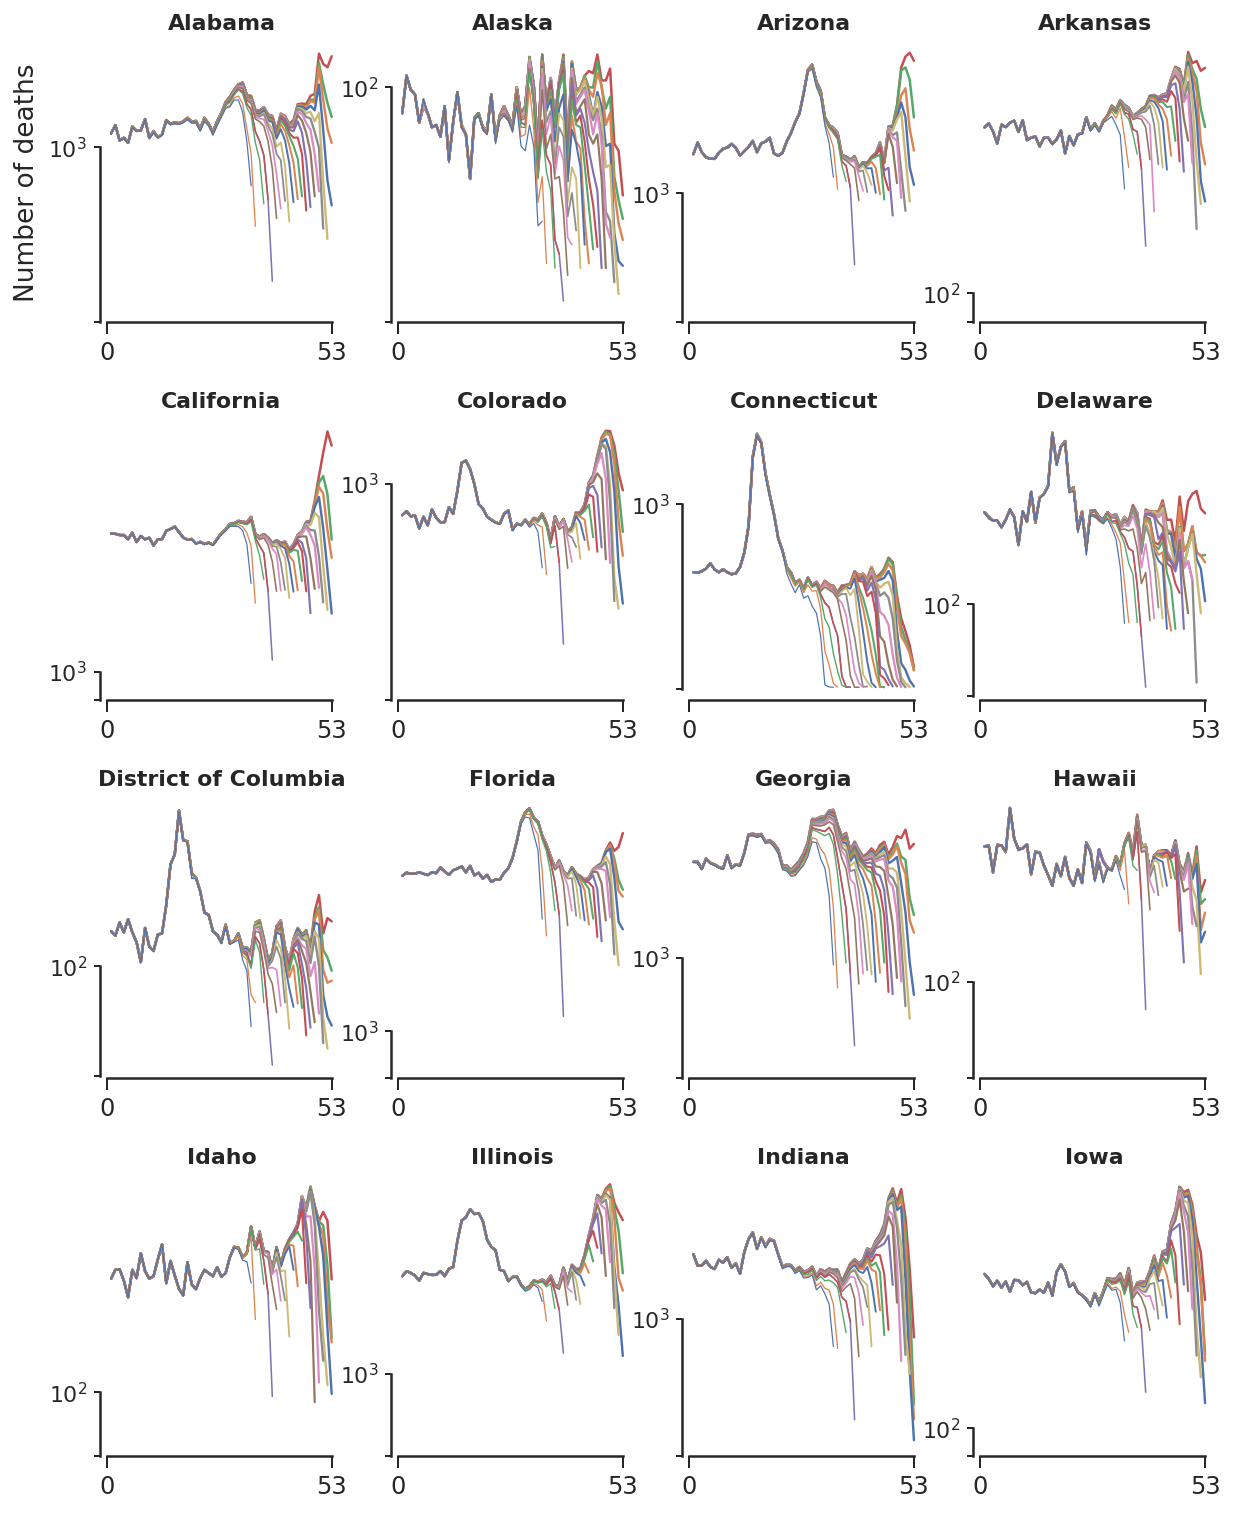

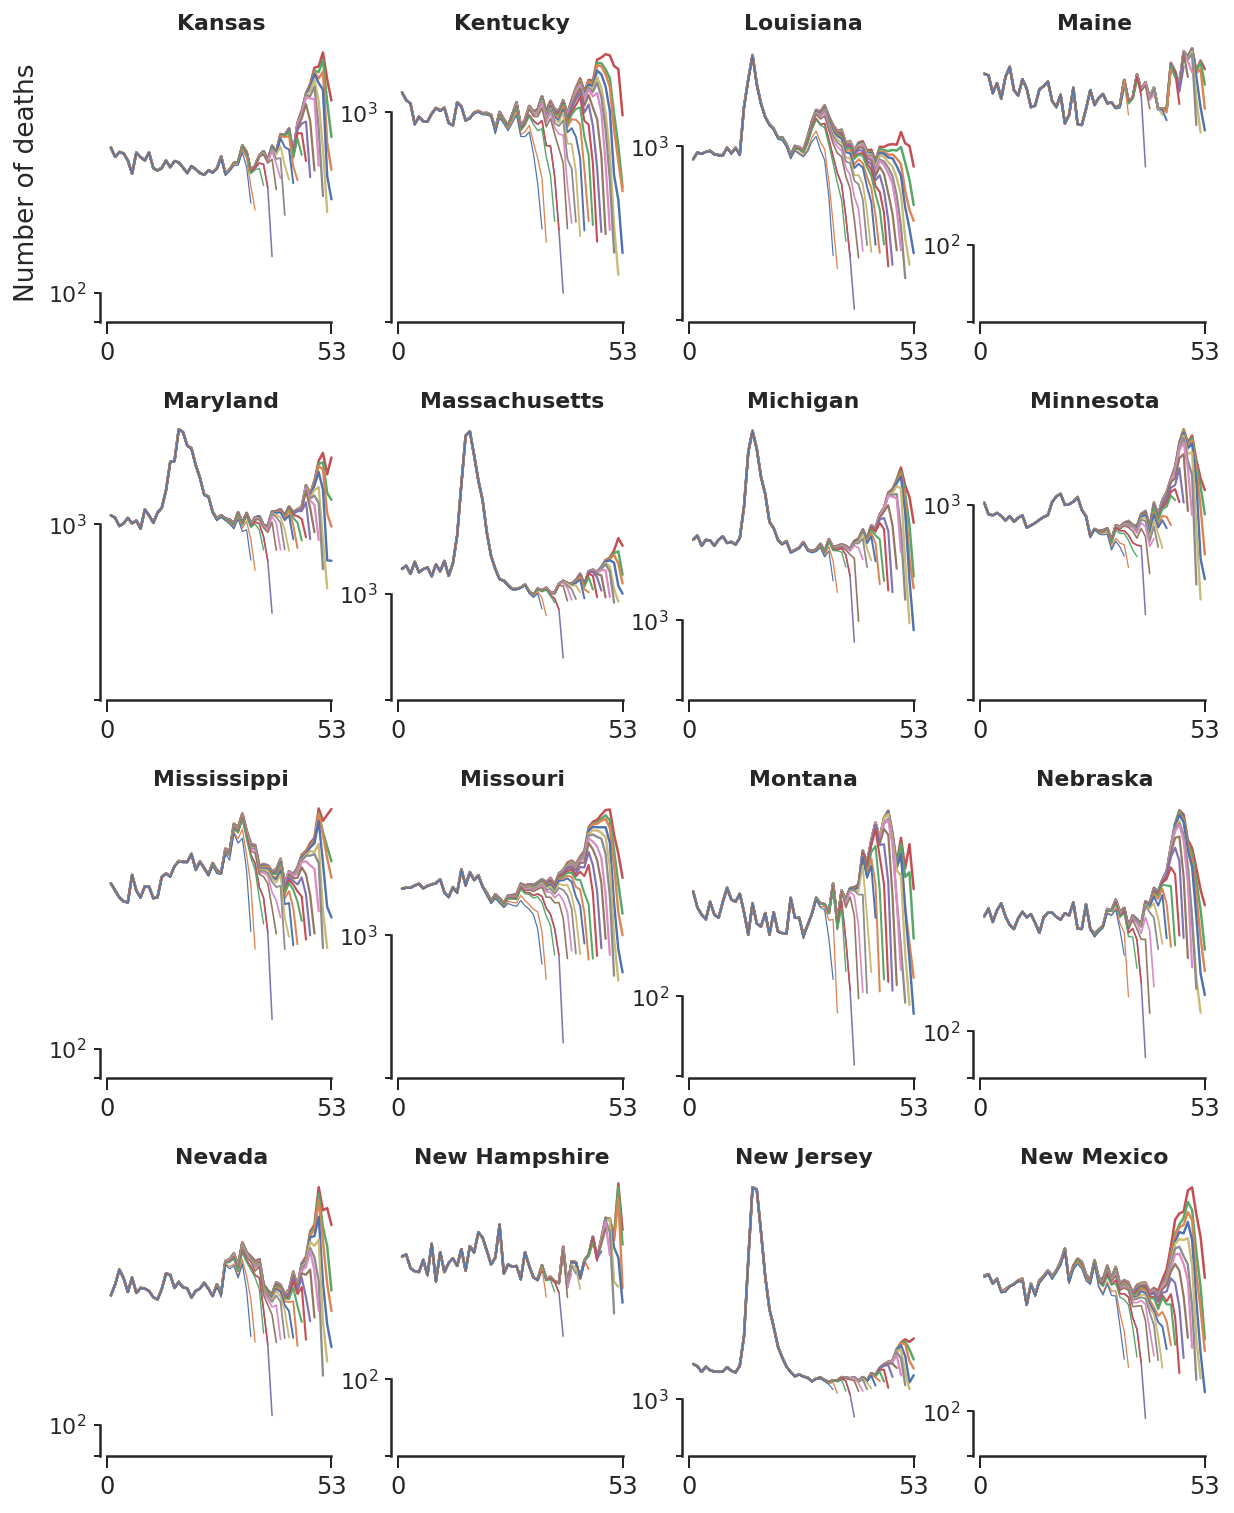

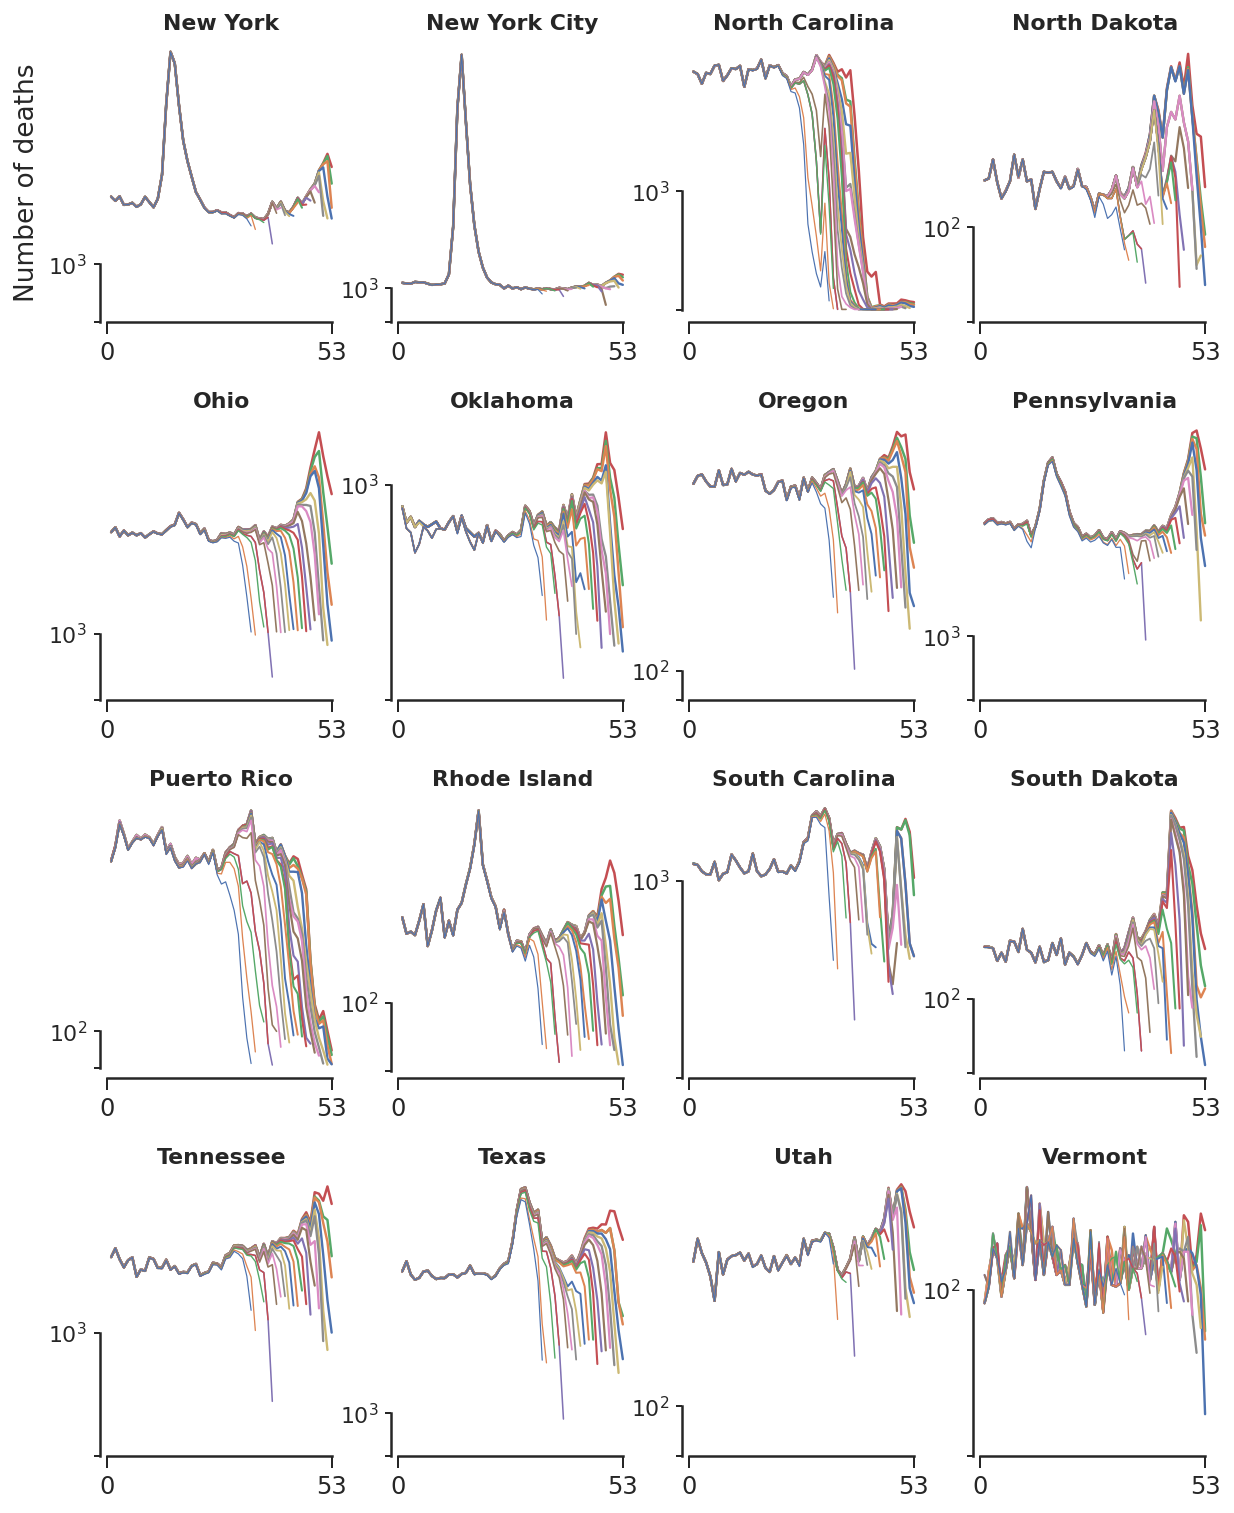

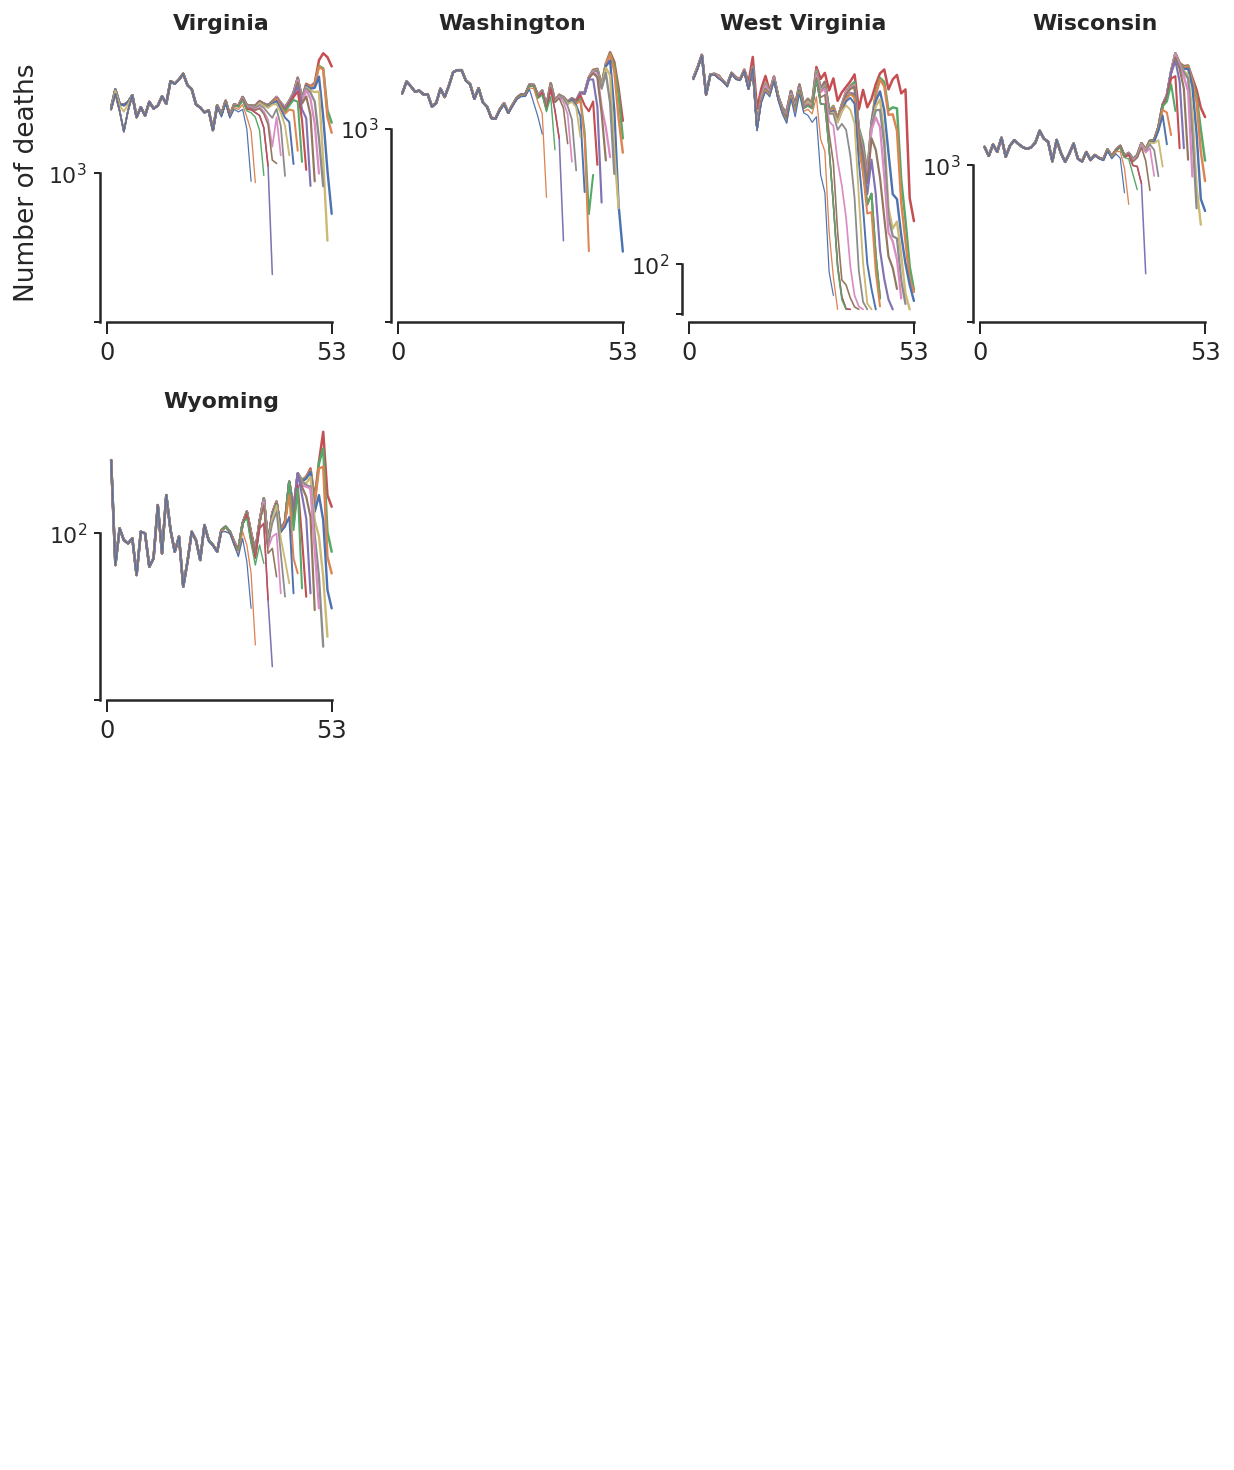

In [87]:
### plotting
for j in range(4):
    fig, axs = plt.subplots(4, 4)
    fig.subplots_adjust(hspace=.35)
    fig.set_size_inches(10,13)

    for i in range(16):
        ax = axs[i // 4][i % 4]
        
        region = 16*j + i + 1
        
        if (region <= len(df_index_jurisdictions.idx_jurisdiction.unique())):
            deaths_max = -1
            for i_, cutoff in enumerate(df.index.get_level_values('idx_snapshot').unique()):
                df_ = df.loc[lambda d: (d.index.get_level_values('idx_jurisdiction')==region)&(d.index.get_level_values('idx_snapshot')==cutoff)]
                if len(df_) > 0:
                    deaths = df_.values[0]
                    if (max(deaths)>deaths_max):
                        deaths_max = max(deaths)
                    weeks = [(int(x)-2020)*53 + int(y) for x,y in [X.split("W") for X in df_.columns.get_level_values("week")]]
                    weekmax = np.max(np.nonzero(deaths)) + 1
                    ax.plot(weeks[:weekmax], [x if x>0 else 9 for x in deaths[:weekmax]], 
                            color='C'+str(i_ % 9), lw=.6+(1-np.exp(-.05*i_)), zorder=-i_)
            #ax.set_xlabel('MMWR Week of 2020')
            if (i // 4 == 0)&(i % 4 == 0):
                ax.set_ylabel('Number of deaths')
            
            ytks_max_power = int(np.log10(deaths_max))

            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_bounds([0, 10**ytks_max_power])
            ax.spines['bottom'].set_bounds([0, 53])
            ytks = [0, 10**ytks_max_power]; ax.set_yticks(ytks); ax.set_yticklabels(["", "$10^%d$"%ytks_max_power])
            ax.tick_params(axis="y", length=3, labelsize=11)
            ax.set_title(df_index_jurisdictions.loc[lambda d: d.idx_jurisdiction==region, 'jurisdiction'].values[0],
                         fontweight='bold', fontsize=11)
            ax.set_xticks([0,53])
        else:
            ax.axis('off')
            
    #fig.savefig('../../figures/draft/Fig(not used)-%d.pdf'%(j+1), format="pdf", bbox_inches='tight')            

In [15]:
# checking if some counts are masked by CDC in the latest snapshot
df_minus_1 = df.loc[lambda d: d.index.get_level_values("idx_snapshot")==max(df.index.get_level_values("idx_snapshot").values)]\
    .loc[lambda d: (d == -1).any(axis=1)]
df_minus_1

Empty DataFrame
Columns: [(number_of_deaths, 2020W01), (number_of_deaths, 2020W02), (number_of_deaths, 2020W03), (number_of_deaths, 2020W04), (number_of_deaths, 2020W05), (number_of_deaths, 2020W06), (number_of_deaths, 2020W07), (number_of_deaths, 2020W08), (number_of_deaths, 2020W09), (number_of_deaths, 2020W10), (number_of_deaths, 2020W11), (number_of_deaths, 2020W12), (number_of_deaths, 2020W13), (number_of_deaths, 2020W14), (number_of_deaths, 2020W15), (number_of_deaths, 2020W16), (number_of_deaths, 2020W17), (number_of_deaths, 2020W18), (number_of_deaths, 2020W19), (number_of_deaths, 2020W20), (number_of_deaths, 2020W21), (number_of_deaths, 2020W22), (number_of_deaths, 2020W23), (number_of_deaths, 2020W24), (number_of_deaths, 2020W25), (number_of_deaths, 2020W26), (number_of_deaths, 2020W27), (number_of_deaths, 2020W28), (number_of_deaths, 2020W29), (number_of_deaths, 2020W30), (number_of_deaths, 2020W31), (number_of_deaths, 2020W32), (number_of_deaths, 2020W33), (number_of_deaths, 2020W34), (number_of_deaths, 2020W35), (number_of_deaths, 2020W36), (number_of_deaths, 2020W37), (number_of_deaths, 2020W38), (number_of_deaths, 2020W39), (number_of_deaths, 2020W40), (number_of_deaths, 2020W41), (number_of_deaths, 2020W42), (number_of_deaths, 2020W43), (number_of_deaths, 2020W44), (number_of_deaths, 2020W45), (number_of_deaths, 2020W46), (number_of_deaths, 2020W47), (number_of_deaths, 2020W48), (number_of_deaths, 2020W49), (number_of_deaths, 2020W50), (number_of_deaths, 2020W51), (number_of_deaths, 2020W52), (number_of_deaths, 2020W53)]
Index: []

[0 rows x 53 columns]

# <font color="purple">Reporting delay</font>

## <font color="orange">I. Non-parameteric estimation</font>

In [16]:
df_nonparametric_output = None
clrs = ['red', 'green', 'blue']
main_folder = 'reporting_delay-nonparametric'
for region in df_index_jurisdictions.idx_jurisdiction.unique():
    folder = 'nonparametric_region-%02d'%region
    posterior_glob = !cd "{stanworkdir}/{main_folder}/{folder}"; ls trace-*
    print(colored(folder + " | " + "number of chains: %d"%len(posterior_glob), clrs[region%3]))
    cmdstan_data = az.from_cmdstan(posterior = [stanworkdir+"/"+main_folder+"/"+folder+"/"+x for x in posterior_glob], log_likelihood='llk') 
    output0 = get_stats_2d(cmdstan_data,['mean_delay','fd']).rename(columns={'time':'d'})
    output0['idx_jurisdiction'] = int(folder.split("-")[-1])
    output0['folder'] = folder
    df_nonparametric_output = output0 if df_nonparametric_output is None else df_nonparametric_output.append(output0)
df_nonparametric_output

nonparametric_region-01 | number of chains: 4
nonparametric_region-02 | number of chains: 4
nonparametric_region-03 | number of chains: 4
nonparametric_region-04 | number of chains: 4
nonparametric_region-05 | number of chains: 4
nonparametric_region-06 | number of chains: 4
nonparametric_region-07 | number of chains: 4
nonparametric_region-08 | number of chains: 4
nonparametric_region-09 | number of chains: 4
nonparametric_region-10 | number of chains: 4
nonparametric_region-11 | number of chains: 4
nonparametric_region-12 | number of chains: 4
nonparametric_region-13 | number of chains: 4
nonparametric_region-14 | number of chains: 4
nonparametric_region-15 | number of chains: 4
nonparametric_region-16 | number of chains: 4
nonparametric_region-17 | number of chains: 4
nonparametric_region-18 | number of chains: 4
nonparametric_region-19 | number of chains: 4
nonparametric_region-20 | number of chains: 4
nonparametric_region-21 | number of chains: 4
nonparametric_region-22 | number o

var   d   mean  hdi2.5  hdi25  hdi75  hdi97.5   q2.5    q25  \
0   mean_delay  NA  2.804   2.743  2.782  2.825    2.867  2.743  2.783   
1           fd   0  0.488   0.481  0.486  0.490    0.494  0.481  0.485   
2           fd   1  0.221   0.210  0.217  0.225    0.232  0.210  0.217   
3           fd   2  0.115   0.102  0.111  0.120    0.129  0.102  0.111   
4           fd   3  0.094   0.080  0.089  0.099    0.108  0.080  0.089   
..         ...  ..    ...     ...    ...    ...      ...    ...    ...   
17          fd  16  0.002   0.000  0.000  0.001    0.006  0.000  0.001   
18          fd  17  0.002   0.000  0.000  0.002    0.006  0.000  0.001   
19          fd  18  0.002   0.000  0.000  0.001    0.006  0.000  0.001   
20          fd  19  0.002   0.000  0.000  0.002    0.006  0.000  0.001   
21          fd  20  0.003   0.000  0.000  0.002    0.008  0.000  0.001   

    median    q75  q97.5  ess_bulk  ess_tail  r_hat  idx_jurisdiction  \
0    2.804  2.825  2.867   10863.0    9346.0    1.0                 1   
1    0.488  0.490  0.494   11859.0    9022.0    1.0                 1   
2    0.221  0.224  0.232    9161.0    7203.0    1.0                 1   
3    0.115  0.120  0.128    8481.0    6491.0    1.0                 1   
4    0.094  0.099  0.108    7394.0    6741.0    1.0                 1   
..     ...    ...    ...       ...       ...    ...               ...   
17   0.001  0.003  0.007    7586.0    4415.0    1.0                53   
18   0.002  0.003  0.008    7829.0    4523.0    1.0                53   
19   0.001  0.003  0.007    7633.0    3967.0    1.0                53   
20   0.002  0.003  0.008    6946.0    4172.0    1.0                53   
21   0.002  0.004  0.009    7409.0    3752.0    1.0                53   

                     folder  
0   nonparametric_region-01  
1   nonparametric_region-01  
2   nonparametric_region-01  
3   nonparametric_region-01  
4   nonparametric_region-01  
..                      ...  
17  nonparametric_region-53  
18  nonparametric_region-53  
19  nonparametric_region-53  
20  nonparametric_region-53  
21  nonparametric_region-53  

[1166 rows x 17 columns]

In [17]:
df_nonparametric_output = df_nonparametric_output.merge(df_index_jurisdictions, on=['idx_jurisdiction'], how='left').sort_values('idx_jurisdiction')

In [18]:
# checking r-hat values
print(df_nonparametric_output.loc[lambda d: d.r_hat>1.1].idx_jurisdiction.unique())
df_nonparametric_output.loc[lambda d: d.r_hat>1.1]

[]


Empty DataFrame
Columns: [var, d, mean, hdi2.5, hdi25, hdi75, hdi97.5, q2.5, q25, median, q75, q97.5, ess_bulk, ess_tail, r_hat, idx_jurisdiction, folder, jurisdiction]
Index: []

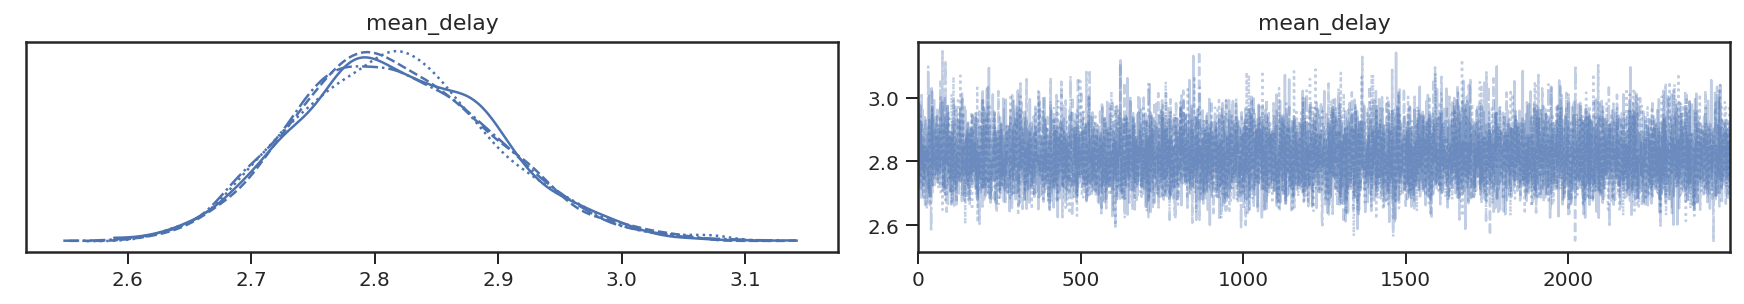

In [19]:
az.plot_trace(cmdstan_data, var_names=['mean_delay']);

## <font color="orange">II. Parameteric estimation (mixture model)</font>

In [20]:
df_parametric_output = None
clrs = ['red', 'green', 'blue']
main_folder = 'reporting_delay-unimodal'
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    for region in df_index_jurisdictions.idx_jurisdiction.unique():
        folder = 'ensemble_region-%02d'%region
        posterior_glob = !cd "{stanworkdir}/{main_folder}/{folder}"; ls trace-*
        #if (region==45)|(region==46):
        #posterior_glob = [x for x in posterior_glob if int(x.split("-")[-1][:-4])<=15]
        print(colored(folder + " | " + "number of chains: %d"%len(posterior_glob), clrs[region%3]))
        cmdstan_data = az.from_cmdstan(posterior = [stanworkdir+"/"+main_folder+"/"+folder+"/"+x for x in posterior_glob]) 
        output0 = get_stats_2d(cmdstan_data, ['mean_delay', 'sd_delay', 'q']).rename(columns={'time':'idx_model'})
        output0['idx_jurisdiction'] = int(folder.split("-")[-1])
        output0['distrib'] = 'ensemble'
        output0['folder'] = folder
        df_parametric_output = output0 if df_parametric_output is None else df_parametric_output.append(output0)
df_parametric_output

ensemble_region-01 | number of chains: 20
ensemble_region-02 | number of chains: 4
ensemble_region-03 | number of chains: 4
ensemble_region-04 | number of chains: 4
ensemble_region-05 | number of chains: 4
ensemble_region-06 | number of chains: 4
ensemble_region-07 | number of chains: 4
ensemble_region-08 | number of chains: 4
ensemble_region-09 | number of chains: 4
ensemble_region-10 | number of chains: 20
ensemble_region-11 | number of chains: 4
ensemble_region-12 | number of chains: 4
ensemble_region-13 | number of chains: 4
ensemble_region-14 | number of chains: 20
ensemble_region-15 | number of chains: 20
ensemble_region-16 | number of chains: 4
ensemble_region-17 | number of chains: 4
ensemble_region-18 | number of chains: 20
ensemble_region-19 | number of chains: 4
ensemble_region-20 | number of chains: 4
ensemble_region-21 | number of chains: 20
ensemble_region-22 | number of chains: 4
ensemble_region-23 | number of chains: 20
ensemble_region-24 | number of chains: 4
ensemble_

var idx_model   mean  hdi2.5  hdi25  hdi75  hdi97.5   q2.5    q25  \
0   mean_delay        NA  2.806   2.682  2.701  2.826    2.976  2.683  2.706   
1     sd_delay        NA  1.703   1.629  1.660  1.707    1.814  1.635  1.670   
2            q         0  0.450   0.000  0.000  0.000    1.000  0.000  0.000   
3            q         1  0.350   0.000  0.000  0.000    1.000  0.000  0.000   
4            q         2  0.200   0.000  0.000  0.000    1.000  0.000  0.000   
..         ...       ...    ...     ...    ...    ...      ...    ...    ...   
0   mean_delay        NA  2.734   2.634  2.662  2.733    2.848  2.643  2.688   
1     sd_delay        NA  1.370   1.242  1.324  1.413    1.503  1.240  1.325   
2            q         0  0.312   0.000  0.000  0.004    0.998  0.000  0.000   
3            q         1  0.652   0.000  0.996  1.000    1.000  0.000  0.005   
4            q         2  0.036   0.000  0.000  0.000    0.151  0.000  0.000   

    median    q75  q97.5  ess_bulk  ess_tail  r_hat  idx_jurisdiction  \
0    2.814  2.832  2.978      25.0      97.0   2.27                 1   
1    1.692  1.723  1.823      42.0      98.0   1.38                 1   
2    0.000  1.000  1.000      24.0      97.0   2.56                 1   
3    0.000  1.000  1.000      23.0      96.0   2.92                 1   
4    0.000  0.000  1.000      24.0     214.0   2.43                 1   
..     ...    ...    ...       ...       ...    ...               ...   
0    2.719  2.783  2.860   10235.0   23502.0   1.00                53   
1    1.370  1.414  1.502   35776.0   31629.0   1.00                53   
2    0.004  0.919  0.999    9411.0   25510.0   1.00                53   
3    0.996  1.000  1.000    9411.0   22876.0   1.00                53   
4    0.000  0.000  0.740    9599.0   19433.0   1.00                53   

     distrib              folder  
0   ensemble  ensemble_region-01  
1   ensemble  ensemble_region-01  
2   ensemble  ensemble_region-01  
3   ensemble  ensemble_region-01  
4   ensemble  ensemble_region-01  
..       ...                 ...  
0   ensemble  ensemble_region-53  
1   ensemble  ensemble_region-53  
2   ensemble  ensemble_region-53  
3   ensemble  ensemble_region-53  
4   ensemble  ensemble_region-53  

[265 rows x 18 columns]

In [21]:
df_parametric_output = df_parametric_output.merge(df_index_jurisdictions, on=['idx_jurisdiction'], how='left').sort_values('idx_jurisdiction')

In [22]:
# the r-hat values 
print(df_parametric_output.loc[lambda d: d.r_hat>1.1].idx_jurisdiction.unique())
df_parametric_output.loc[lambda d: d.r_hat>1.1]

[ 1 10 14 15 18 23 25 35 40 45 46 49 51]


var idx_model   mean  hdi2.5  hdi25  hdi75  hdi97.5   q2.5    q25  \
0    mean_delay        NA  2.806   2.682  2.701  2.826    2.976  2.683  2.706   
1      sd_delay        NA  1.703   1.629  1.660  1.707    1.814  1.635  1.670   
2             q         0  0.450   0.000  0.000  0.000    1.000  0.000  0.000   
3             q         1  0.350   0.000  0.000  0.000    1.000  0.000  0.000   
4             q         2  0.200   0.000  0.000  0.000    1.000  0.000  0.000   
..          ...       ...    ...     ...    ...    ...      ...    ...    ...   
250  mean_delay        NA  6.984   6.377  7.213  7.318    7.309  6.378  6.799   
251    sd_delay        NA  3.269   2.207  3.753  3.866    3.855  2.209  2.883   
252           q         0  0.316   0.000  0.000  0.000    1.000  0.000  0.000   
253           q         1  0.158   0.000  0.000  0.000    1.000  0.000  0.000   
254           q         2  0.526   0.000  1.000  1.000    1.000  0.000  0.000   

     median    q75  q97.5  ess_bulk  ess_tail         r_hat  idx_jurisdiction  \
0     2.814  2.832  2.978      25.0      97.0  2.270000e+00                 1   
1     1.692  1.723  1.823      42.0      98.0  1.380000e+00                 1   
2     0.000  1.000  1.000      24.0      97.0  2.560000e+00                 1   
3     0.000  1.000  1.000      23.0      96.0  2.920000e+00                 1   
4     0.000  0.000  1.000      24.0     214.0  2.430000e+00                 1   
..      ...    ...    ...       ...       ...           ...               ...   
250   7.221  7.267  7.310      25.0      68.0  2.010000e+00                51   
251   3.762  3.811  3.858      25.0      69.0  2.010000e+00                51   
252   0.000  1.000  1.000      19.0      19.0  5.322185e+15                51   
253   0.000  0.000  1.000      19.0      19.0  6.483621e+15                51   
254   1.000  1.000  1.000      19.0      19.0  8.481407e+15                51   

      distrib              folder   jurisdiction  
0    ensemble  ensemble_region-01        Alabama  
1    ensemble  ensemble_region-01        Alabama  
2    ensemble  ensemble_region-01        Alabama  
3    ensemble  ensemble_region-01        Alabama  
4    ensemble  ensemble_region-01        Alabama  
..        ...                 ...            ...  
250  ensemble  ensemble_region-51  West Virginia  
251  ensemble  ensemble_region-51  West Virginia  
252  ensemble  ensemble_region-51  West Virginia  
253  ensemble  ensemble_region-51  West Virginia  
254  ensemble  ensemble_region-51  West Virginia  

[63 rows x 19 columns]

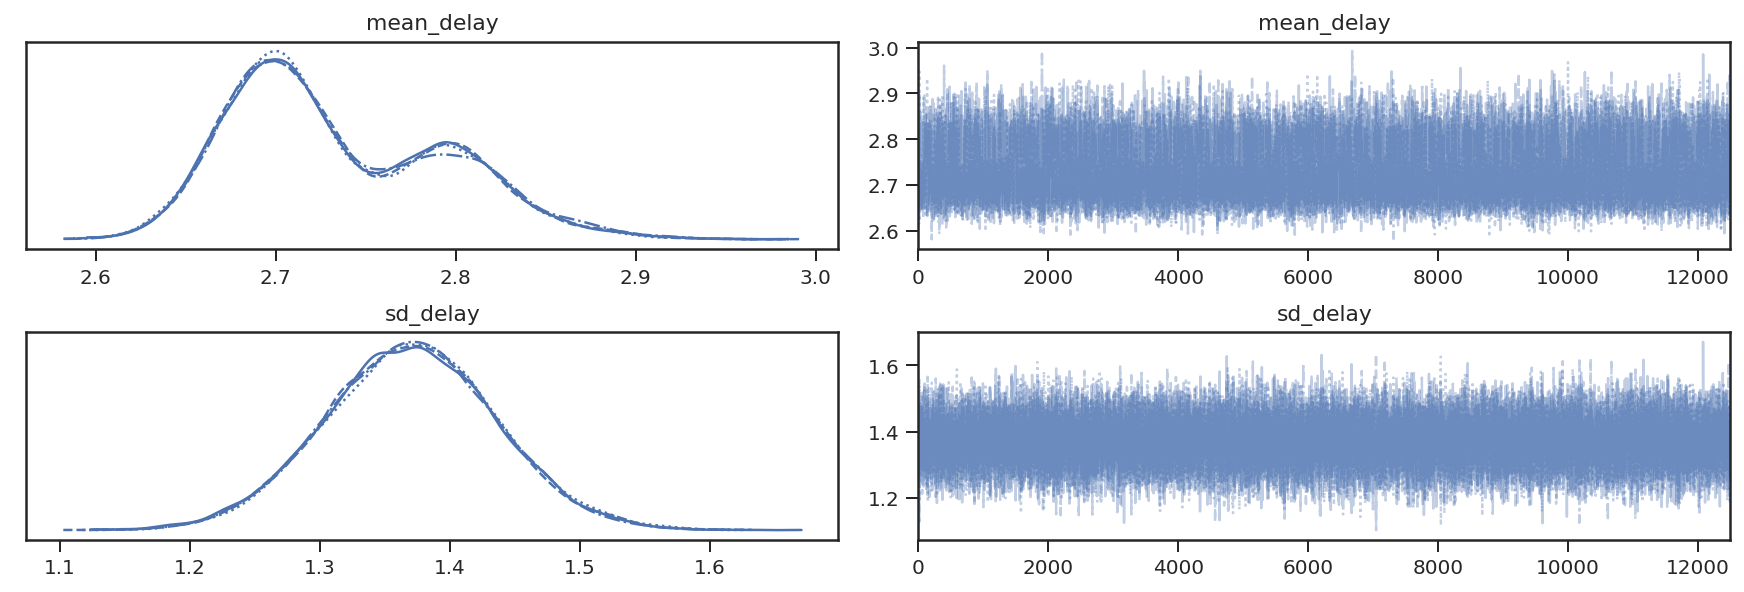

In [23]:
az.plot_trace(cmdstan_data, var_names=['mean_delay','sd_delay']);

## <font color="orange">IIb. Parameteric estimation (three distributions separetely)</font>

In [24]:
df_distribs_output = None
distribs = ['gamma', 'weibull', 'lognormal'] 
clrs = ['red', 'green', 'blue']
main_folder = 'reporting_delay-unimodal'
for region in df_index_jurisdictions.idx_jurisdiction.unique():
    output = None
    for idx_d, distrib in enumerate(distribs): 
        folder = distrib+'_region-%02d'%region
        posterior_glob = !cd "{stanworkdir}/{main_folder}/{folder}"; ls trace-*
        print(colored(folder + " | " + "number of chains: %d"%len(posterior_glob), clrs[idx_d]))
        cmdstan_data = az.from_cmdstan(posterior = [stanworkdir+"/"+main_folder+"/"+folder+"/"+x for x in posterior_glob], log_likelihood='llk') 
        output0 = get_stats_2d(cmdstan_data,['mean_delay', 'sd_delay']).drop('time',1)
        output0['idx_jurisdiction'] = int(folder.split("-")[-1])
        output0['distribution'] = distrib
        output0['folder'] = folder
        df_distribs_output = output0 if df_distribs_output is None else df_distribs_output.append(output0)
df_index_distribution = pd.DataFrame({'distribution':['gamma','weibull','lognormal'],'idx_distribution':range(3)})
df_distribs_output = df_distribs_output.merge(df_index_distribution, on='distribution', how='left')
df_distribs_output

gamma_region-01 | number of chains: 4
weibull_region-01 | number of chains: 4
lognormal_region-01 | number of chains: 4
gamma_region-02 | number of chains: 4
weibull_region-02 | number of chains: 4
lognormal_region-02 | number of chains: 4
gamma_region-03 | number of chains: 4
weibull_region-03 | number of chains: 4
lognormal_region-03 | number of chains: 4
gamma_region-04 | number of chains: 4
weibull_region-04 | number of chains: 4
lognormal_region-04 | number of chains: 4
gamma_region-05 | number of chains: 4
weibull_region-05 | number of chains: 4
lognormal_region-05 | number of chains: 4
gamma_region-06 | number of chains: 4
weibull_region-06 | number of chains: 4
lognormal_region-06 | number of chains: 4
gamma_region-07 | number of chains: 4
weibull_region-07 | number of chains: 4
lognormal_region-07 | number of chains: 4
gamma_region-08 | number of chains: 4
weibull_region-08 | number of chains: 4
lognormal_region-08 | number of chains: 4
gamma_region-09 | number of chains: 4
we

var   mean  hdi2.5  hdi25  hdi75  hdi97.5   q2.5    q25  median  \
0    mean_delay  2.818   2.796  2.810  2.825    2.840  2.796  2.811   2.818   
1      sd_delay  1.686   1.632  1.667  1.704    1.740  1.633  1.668   1.686   
2    mean_delay  2.700   2.678  2.691  2.707    2.722  2.678  2.692   2.700   
3      sd_delay  1.680   1.631  1.662  1.696    1.730  1.632  1.663   1.680   
4    mean_delay  2.963   2.936  2.953  2.970    2.988  2.937  2.954   2.963   
..          ...    ...     ...    ...    ...      ...    ...    ...     ...   
313    sd_delay  1.353   1.219  1.306  1.397    1.485  1.222  1.307   1.352   
314  mean_delay  2.697   2.638  2.677  2.717    2.755  2.638  2.677   2.697   
315    sd_delay  1.381   1.264  1.336  1.420    1.507  1.263  1.338   1.381   
316  mean_delay  2.866   2.801  2.843  2.887    2.929  2.803  2.843   2.865   
317    sd_delay  1.360   1.212  1.309  1.412    1.512  1.216  1.308   1.358   

       q75  q97.5  ess_bulk  ess_tail  r_hat  idx_jurisdiction distribution  \
0    2.826  2.840   39081.0   34798.0    1.0                 1        gamma   
1    1.705  1.741   37641.0   33586.0    1.0                 1        gamma   
2    2.707  2.722   40680.0   32437.0    1.0                 1      weibull   
3    1.697  1.730   43915.0   34559.0    1.0                 1      weibull   
4    2.972  2.989   16908.0   21819.0    1.0                 1    lognormal   
..     ...    ...       ...       ...    ...               ...          ...   
313  1.398  1.489   24654.0   29216.0    1.0                53        gamma   
314  2.717  2.756   38452.0   30601.0    1.0                53      weibull   
315  1.423  1.506   40498.0   32432.0    1.0                53      weibull   
316  2.888  2.931   15194.0   22178.0    1.0                53    lognormal   
317  1.411  1.517   14861.0   21312.0    1.0                53    lognormal   

                  folder  idx_distribution  
0        gamma_region-01                 0  
1        gamma_region-01                 0  
2      weibull_region-01                 1  
3      weibull_region-01                 1  
4    lognormal_region-01                 2  
..                   ...               ...  
313      gamma_region-53                 0  
314    weibull_region-53                 1  
315    weibull_region-53                 1  
316  lognormal_region-53                 2  
317  lognormal_region-53                 2  

[318 rows x 18 columns]

In [25]:
df_distribs_output = df_distribs_output.merge(df_index_jurisdictions, on=['idx_jurisdiction'], how='left').sort_values('idx_jurisdiction')

In [26]:
# the r-hat for Weibull in New Hampshire and Maine are not good because that jurisdiction report quite well 
# and it is difficult to fit 
print(df_distribs_output.loc[lambda d: d.r_hat>1.1].idx_jurisdiction.unique())
df_distribs_output.loc[lambda d: d.r_hat>1.1]

[]


Empty DataFrame
Columns: [var, mean, hdi2.5, hdi25, hdi75, hdi97.5, q2.5, q25, median, q75, q97.5, ess_bulk, ess_tail, r_hat, idx_jurisdiction, distribution, folder, idx_distribution, jurisdiction]
Index: []

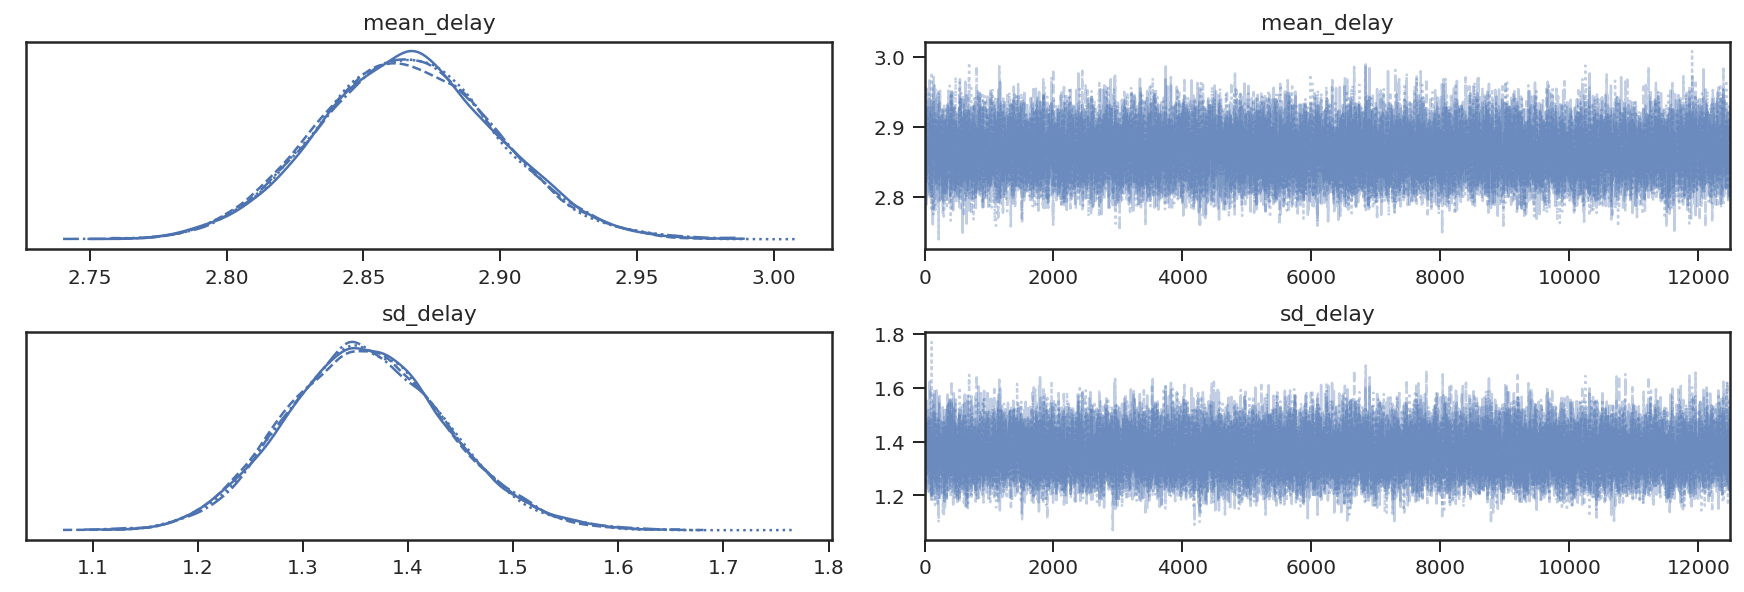

In [27]:
az.plot_trace(cmdstan_data, var_names=['mean_delay','sd_delay']);

## <font color="orange">III. Partial pool model</font>

In [28]:
%%time
main_folder = 'reporting_delay-partial'
folder = 'lognormal_52_NC'
print(colored(folder, 'red'))
posterior_glob = !cd "{stanworkdir}/{main_folder}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [stanworkdir+"/"+main_folder+"/"+folder+"/"+x for x in posterior_glob])

lognormal_52_NC
CPU times: user 248 ms, sys: 8.13 ms, total: 256 ms
Wall time: 260 ms


In [29]:
df_index_jurisdictions_partial = pd.read_pickle(stanworkdir+"/"+main_folder+"/"+folder+"/idx_jurisdictions.pkl")
df_output0 = get_stats_2d(cmdstan_data, ['nu','mu_mean_delay', 'sigma_mean_delay', 'sd_delay', 
                                         'mean_delay', 'sd_delay', 't_score'])

var idx_jurisdiction    mean  hdi2.5  hdi25   hdi75  hdi97.5  \
0                nu               NA  17.416   1.916  3.665  15.087   40.909   
1     mu_mean_delay               NA   2.716   2.446  2.607   2.797    3.007   
2  sigma_mean_delay               NA   1.079   0.085  0.543   1.314    2.186   

    q2.5    q25  median     q75   q97.5  ess_bulk  ess_tail  r_hat  
0  3.455  8.342  14.319  23.040  48.939     339.0     444.0   1.01  
1  2.430  2.621   2.716   2.814   2.996    2621.0    2887.0   1.00  
2  0.172  0.635   1.009   1.423   2.428    1971.0    2045.0   1.00

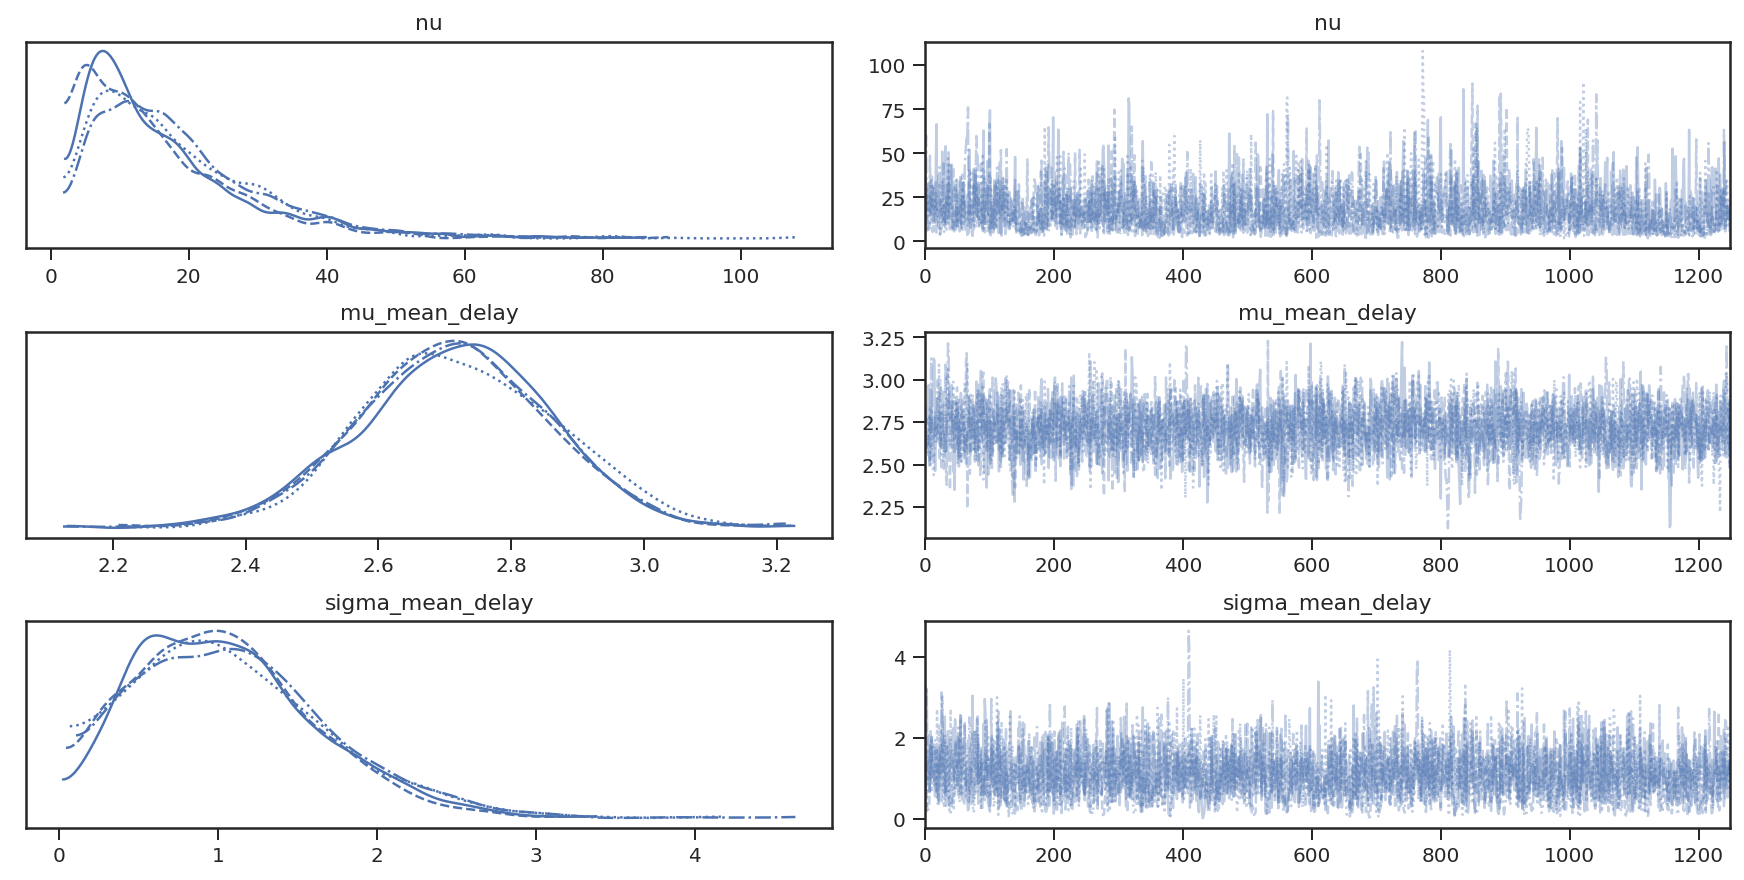

In [30]:
az.plot_trace(cmdstan_data,var_names=['nu', 'mu_mean_delay','sigma_mean_delay']);
df_output0.loc[lambda d: d['var'].isin(['nu', 'mu_mean_delay','sigma_mean_delay'])].rename(columns={'time':'idx_jurisdiction'})

In [31]:
df_output = df_output0.loc[lambda d: d['var'].isin(['mean_delay', 't_score'])].rename(columns={'time':'idx_jurisdiction'})
df_output['idx_jurisdiction'] = [int(x)+1 for x in df_output['idx_jurisdiction']]
df_output = df_output.merge(df_index_jurisdictions_partial, on=['idx_jurisdiction'], how='left').sort_values('idx_jurisdiction')
df_output

var  idx_jurisdiction   mean  hdi2.5  hdi25  hdi75  hdi97.5  \
0    mean_delay                 1  3.038   3.018  3.032  3.046    3.058   
52      t_score                 1  0.349   0.074  0.362  0.462    0.506   
1    mean_delay                 2  3.960   3.921  3.946  3.973    3.999   
53      t_score                 2  0.129   0.000  0.000  0.124    0.296   
2    mean_delay                 3  2.373   2.338  2.361  2.383    2.405   
..          ...               ...    ...     ...    ...    ...      ...   
49   mean_delay                50  5.488   5.473  5.483  5.494    5.505   
102     t_score                51  0.722   0.578  0.586  0.717    1.000   
50   mean_delay                51  2.188   2.147  2.174  2.203    2.231   
51   mean_delay                52  3.041   2.978  3.023  3.066    3.107   
103     t_score                52  0.348   0.068  0.363  0.466    0.504   

      q2.5    q25  median    q75  q97.5  ess_bulk  ess_tail  r_hat  \
0    3.018  3.031   3.038  3.045  3.058    4974.0    4008.0    1.0   
52   0.034  0.303   0.382  0.426  0.486    1718.0    2194.0    1.0   
1    3.921  3.946   3.960  3.975  3.999    4877.0    4439.0    1.0   
53   0.000  0.038   0.124  0.204  0.316    2051.0    2243.0    1.0   
2    2.340  2.363   2.374  2.385  2.406    5063.0    3412.0    1.0   
..     ...    ...     ...    ...    ...       ...       ...    ...   
49   5.472  5.483   5.488  5.494  5.504    4996.0    4033.0    1.0   
102  0.565  0.632   0.694  0.789  0.993    2232.0    2168.0    1.0   
50   2.144  2.174   2.189  2.203  2.229    4959.0    3060.0    1.0   
51   2.975  3.020   3.042  3.064  3.105    4616.0    2505.0    1.0   
103  0.033  0.301   0.380  0.426  0.488    1770.0    2428.0    1.0   

      jurisdiction  
0          Alabama  
52         Alabama  
1           Alaska  
53          Alaska  
2          Arizona  
..             ...  
49   West Virginia  
102      Wisconsin  
50       Wisconsin  
51         Wyoming  
103        Wyoming  

[104 rows x 16 columns]

In [32]:
df_output0_t_score = get_stats_2d(cmdstan_data,['t_score']).rename(columns={'time':'idx_jurisdiction'})
df_output0_t_score['idx_jurisdiction'] = df_output0_t_score['idx_jurisdiction'].astype('int') + 1
df_output0_t_score = df_output0_t_score.merge(df_index_jurisdictions_partial, on=['idx_jurisdiction'], how='left').sort_values('idx_jurisdiction')
df_output0_t_score[:5]

var  idx_jurisdiction   mean  hdi2.5  hdi25  hdi75  hdi97.5   q2.5  \
0  t_score                 1  0.349   0.074  0.362  0.462    0.506  0.034   
1  t_score                 2  0.129   0.000  0.000  0.124    0.296  0.000   
2  t_score                 3  0.657   0.503  0.543  0.645    0.933  0.520   
3  t_score                 4  0.599   0.441  0.514  0.600    0.850  0.464   
4  t_score                 5  0.475   0.268  0.455  0.530    0.664  0.241   

     q25  median    q75  q97.5  ess_bulk  ess_tail  r_hat jurisdiction  
0  0.303   0.382  0.426  0.486    1718.0    2194.0    1.0      Alabama  
1  0.038   0.124  0.204  0.316    2051.0    2243.0    1.0       Alaska  
2  0.580   0.627  0.705  0.964    2432.0    2310.0    1.0      Arizona  
3  0.538   0.577  0.634  0.895    2609.0    2505.0    1.0     Arkansas  
4  0.441   0.483  0.519  0.643    2690.0    2515.0    1.0   California

In [33]:
# identifying IQR and lower/upper 95th percentile of the t-distribution
ν = np.hstack(cmdstan_data.posterior.nu.values)
μ = np.hstack(cmdstan_data.posterior.mu_mean_delay.values)
σ = np.hstack(cmdstan_data.posterior.sigma_mean_delay.values)

import scipy.stats as ss
ppfs = np.stack([ss.t(ν[x], μ[x], σ[x]).ppf((0.025, 0.25, 0.5, 0.75, 0.975, 0.1, 0.9)) for x in range(len(ν))])
ppfs[:4]

array([[ 1.63070202,  2.29799545,  2.63847   ,  2.97894455,  3.64623798,
         1.98738057,  3.28955943],
       [ 0.87961335,  2.15434088,  2.77482   ,  3.39529912,  4.67002665,
         1.57530841,  3.97433159],
       [ 1.04119426,  2.22007773,  2.76724   ,  3.31440227,  4.49328574,
         1.6977398 ,  3.8367402 ],
       [-4.15927973,  0.5309965 ,  2.74459   ,  4.9581835 ,  9.64845973,
        -1.56543386,  7.05461386]])

In [34]:
t_ppfs = np.percentile(ppfs, q = [2.5, 50, 97.5], axis=0)
t_ppfs.round(2)

array([[-2.75,  1.  ,  2.43,  2.75,  3.07, -0.6 ,  2.9 ],
       [ 0.47,  2.01,  2.72,  3.43,  4.96,  1.34,  4.11],
       [ 2.34,  2.65,  3.  ,  4.44,  8.15,  2.5 ,  6.04]])

# <font color="purple">Figure 1A</font>

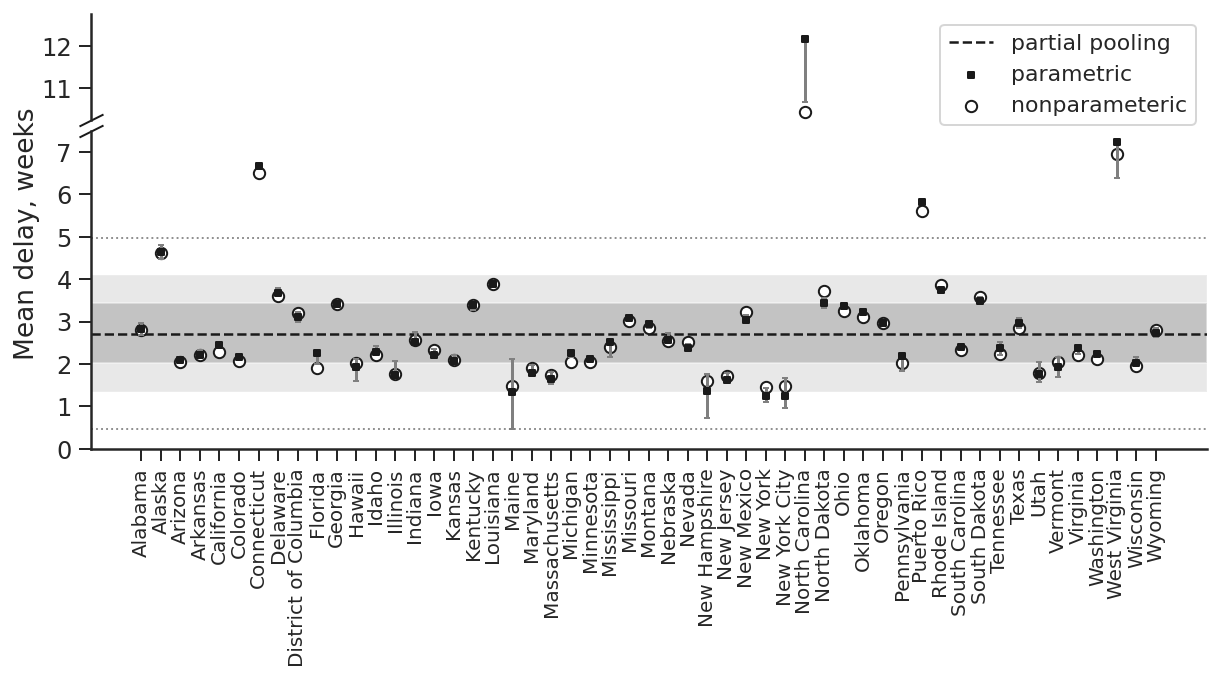

In [88]:
fig, (ax2, ax1) = plt.subplots(2, 1, sharex=True, gridspec_kw={'height_ratios': [2.5/7.5, 1]})
fig.subplots_adjust(hspace=0.05)
fig.set_size_inches(10,4)

mrks = ['s', 'o']
szs = [12, 32]

## parametric
df_output_ = df_parametric_output.loc[lambda d: (d['var']=='mean_delay')].sort_values('jurisdiction')
X = df_output_.jurisdiction
ax1.errorbar(X, .5*(df_output_['q2.5']+df_output_['q97.5']), .5*(df_output_['q97.5']-df_output_['q2.5']), capsize=1.5,
            color='grey', linestyle='None', zorder=-5)
ax1.scatter(X, df_output_['median'], marker=mrks[0], edgecolor='k', facecolor='k', s=szs[0],
           label="parametric\n(mixture model)"); 
ax2.errorbar(X, .5*(df_output_['q2.5']+df_output_['q97.5']), .5*(df_output_['q97.5']-df_output_['q2.5']), capsize=1.5,
            color='grey', linestyle='None', zorder=-5)
ax2.scatter(X, df_output_['median'], marker=mrks[0], edgecolor='k', facecolor='k', s=szs[0], 
           label="parametric");

## nonparametric
df_output_ = df_nonparametric_output.loc[lambda d: (d['var']=='mean_delay')].sort_values('jurisdiction')
X = df_output_.jurisdiction
ax1.scatter(X, df_output_['median'], marker=mrks[-1], color='k', facecolor='w', s=szs[-1], label="nonparameteric", zorder=-5.5); 
ax2.scatter(X, df_output_['median'], marker=mrks[-1], color='k', facecolor='w', s=szs[-1], label="nonparameteric", zorder=-5.5); 

# ax1.set_xlabel('Jurisdiction')
ax1.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False);
plt.xticks(rotation='vertical', fontsize=10);
ax1.set_yticks(np.arange(0, 8))
ax1.set_ylim(bottom=0, top=7.5);
ax2.set_ylim(bottom=10.25, top=12.75);

ax2.spines['bottom'].set_visible(False); ax2.spines['top'].set_visible(False); ax2.spines['right'].set_visible(False)
ax1.spines['top'].set_visible(False)
ax2.tick_params(labeltop=False)  # don't put tick labels at the top
ax1.xaxis.tick_bottom()
ax2.xaxis.set_visible(False)

fig.text(.072, 0.5, 'Mean delay, weeks', rotation=90, va='center', ha='left')

mu_mean_delay_ = df_output0.loc[lambda d: d['var']=='mu_mean_delay','mean'].values[0]
sigma_mean_delay_ = df_output0.loc[lambda d: d['var']=='sigma_mean_delay','mean'].values[0]
ax1.axhline([t_ppfs[1, 2]], linestyle='dashed', color='k', zorder=-6, lw=1.25, label="partial pooling")
ax2.axhline([t_ppfs[1, 2]], linestyle='dashed', color='k', zorder=-6, lw=1.25, label="partial pooling")

ax1.axhspan(t_ppfs[1, -2], t_ppfs[1, -1], facecolor='C7', alpha=0.2, zorder=-7)
ax1.axhspan(t_ppfs[1, 1], t_ppfs[1, 3], facecolor='C7', alpha=0.4, zorder=-7)
[ax1.axhline(t_ppfs[1, 2+2*x], linestyle='dotted', color='C7', zorder=-6, lw=.95) for x in [-1, 1]]

d = .5  # proportion of vertical to horizontal extent of the slanted line
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color='k', mec='k', mew=1, clip_on=False)
ax2.plot([0], transform=ax2.transAxes, **kwargs)
ax1.plot([1], transform=ax1.transAxes, **kwargs)
ax2.legend(fontsize=11,frameon=True)

fig.savefig('../../figures/draft/Fig1A.pdf', format="pdf", bbox_inches='tight')

In [89]:
df_means_within_IQR = df_nonparametric_output.loc[lambda d: (d['var']=='mean_delay')].sort_values('jurisdiction').loc[lambda d: (d['mean']>=t_ppfs[1, 1])&(d['mean']<=t_ppfs[1, 3]),['mean','jurisdiction']]
df_means_within_IQR

mean          jurisdiction
0     2.804               Alabama
44    2.058               Arizona
66    2.218              Arkansas
88    2.277            California
110   2.080              Colorado
176   3.204  District of Columbia
220   3.416               Georgia
242   2.033                Hawaii
264   2.204                 Idaho
308   2.556               Indiana
330   2.320                  Iowa
352   2.085                Kansas
374   3.381              Kentucky
484   2.058              Michigan
506   2.046             Minnesota
528   2.410           Mississippi
550   3.004              Missouri
572   2.846               Montana
594   2.548              Nebraska
616   2.508                Nevada
682   3.219            New Mexico
792   3.250                  Ohio
814   3.119              Oklahoma
836   2.959                Oregon
858   2.032          Pennsylvania
924   2.322        South Carolina
968   2.239             Tennessee
990   2.853                 Texas
1034  2.056               Vermont
1056  2.223              Virginia
1078  2.121            Washington
1144  2.817               Wyoming

In [90]:
(df_means_within_IQR.shape[0])

32

In [91]:
df_nonparametric_output.loc[lambda d: (d['mean']==max(df_nonparametric_output['mean']))&(d['var']=='mean_delay')]

var   d    mean  hdi2.5  hdi25   hdi75  hdi97.5    q2.5    q25  \
748  mean_delay  NA  10.448  10.423  10.44  10.457   10.473  10.423  10.44   

     median     q75   q97.5  ess_bulk  ess_tail  r_hat  idx_jurisdiction  \
748  10.448  10.457  10.474    9146.0    8364.0    1.0                35   

                      folder    jurisdiction  
748  nonparametric_region-35  North Carolina

### First, checking that North Carolina deviates from the others

In [92]:
stanmaindir = 'small_tasks'
!mkdir -p {stanworkdir}/{stanmaindir}
standirname = stanworkdir+'/'+stanmaindir+'/NC_outlier'
!mkdir -p {standirname}

In [81]:
## stan code
stan_code = """
data {
    int<lower = 1> J; 
    vector<lower = 0>[J] mean_delay;
    real<lower = 0> NC_delay;
}

parameters {
    real<lower = 0> nu;
    real<lower = 0> mu;
    real<lower = 0> sigma;
}

model {
    nu ~ cauchy(0.0, 5.0);
    mu ~ std_normal();
    sigma ~ cauchy(0.0, 5.0);
    
    target += student_t_lpdf(mean_delay | nu, mu, sigma); 
}

generated quantities {
    real pvalue = exp(student_t_lccdf(NC_delay | nu, mu, sigma));
}
"""

stanscriptdir = '../Dropbox/'+standirname[9:]

bash_file = """#!/bin/bash
cwd=$(pwd)
cd """+standistribdir+"""
make -j2 """+stanscriptdir+"""/fit
cd """+stanscriptdir+"""
mkdir -p diagnostics
for i in {1..4}
do
    echo Running ${i}
    SEEDNUMBER=$((1+$i))
    ./fit \\
        method=sample num_samples=12500 num_warmup=10000 thin=1 save_warmup=0 \\
            algorithm=hmc \\
                engine=nuts \\
        random seed=${SEEDNUMBER} \\
        id=$i \\
        data file=Data.R \\
        output file=trace-$i.csv refresh=2000\\
            diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
done
echo Finished haha!
"""

smpl = df_nonparametric_output.loc[lambda d: (d['jurisdiction']!='North Carolina')&(d['var']=='mean_delay'), 'mean'].values
NC_delay = df_nonparametric_output.loc[lambda d: (d['jurisdiction']=='North Carolina')&(d['var']=='mean_delay'), 'mean'].values[0]

# data file
stan_data = dict({
    'J': len(smpl),
    'mean_delay': smpl,
    'NC_delay': NC_delay
})
pystan.misc.stan_rdump(stan_data, standirname+'/Data.R')

f = open(standirname+"/fit.stan", "w"); f.write(stan_code); f.close()
f = open(standirname+"/fit_bash.sh", "w"); f.write(bash_file); f.close()

# compilation
!rm -f {standirname+"/fit"}
os.system("bash "+standirname+"/fit_bash.sh")

0

In [83]:
%%time
posterior_glob = !cd "{standirname}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [standirname+"/"+x for x in posterior_glob], log_likelihood='llk')
df_output__ = get_stats(cmdstan_data, ['pvalue','mu'])
df_output__

CPU times: user 296 ms, sys: 16 ms, total: 312 ms
Wall time: 316 ms


var time   mean  hdi2.5  hdi25  hdi75  hdi97.5  q2.5    q25  median  \
0  pvalue   NA  0.002   0.000  0.000  0.001    0.007  0.00  0.000   0.001   
1      mu   NA  2.418   2.169  2.322  2.499    2.686  2.17  2.327   2.414   

     q75  q97.5  ess_bulk  ess_tail  r_hat  
0  0.002  0.010   29229.0   26399.0    1.0  
1  2.505  2.688   23719.0   29517.0    1.0

## <font color="orange">Appendix Figure 1</font>

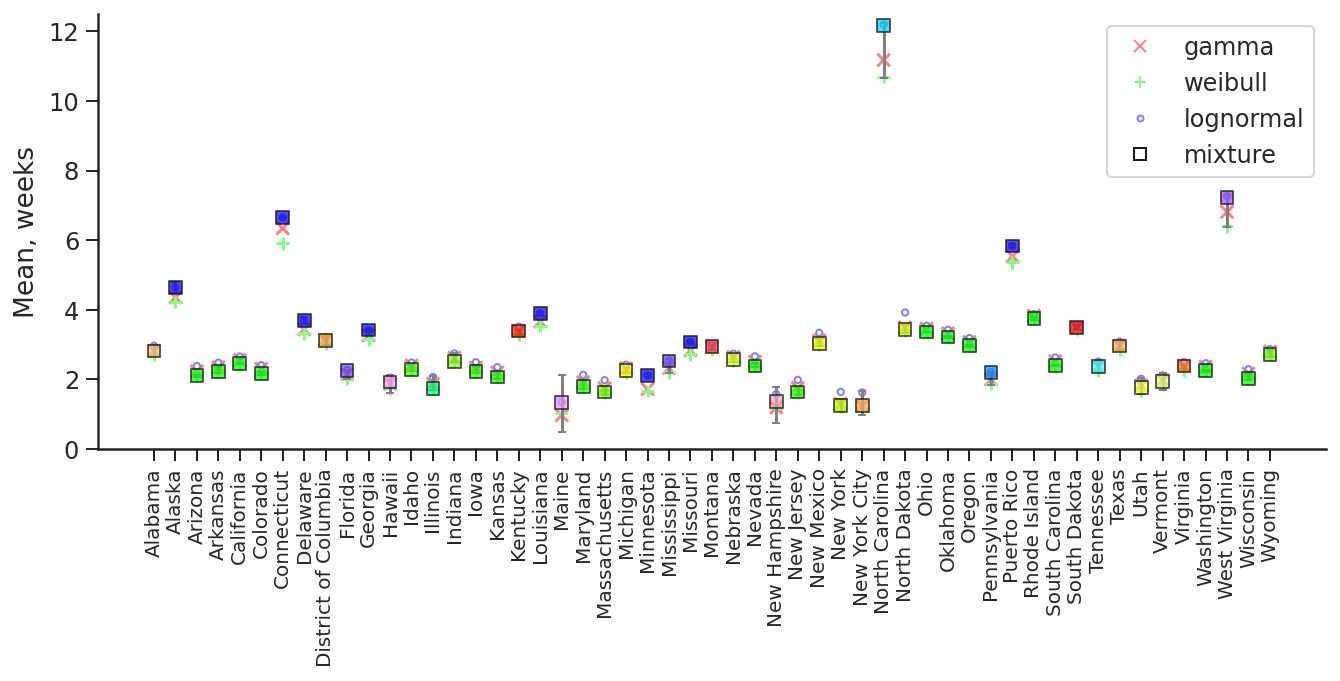

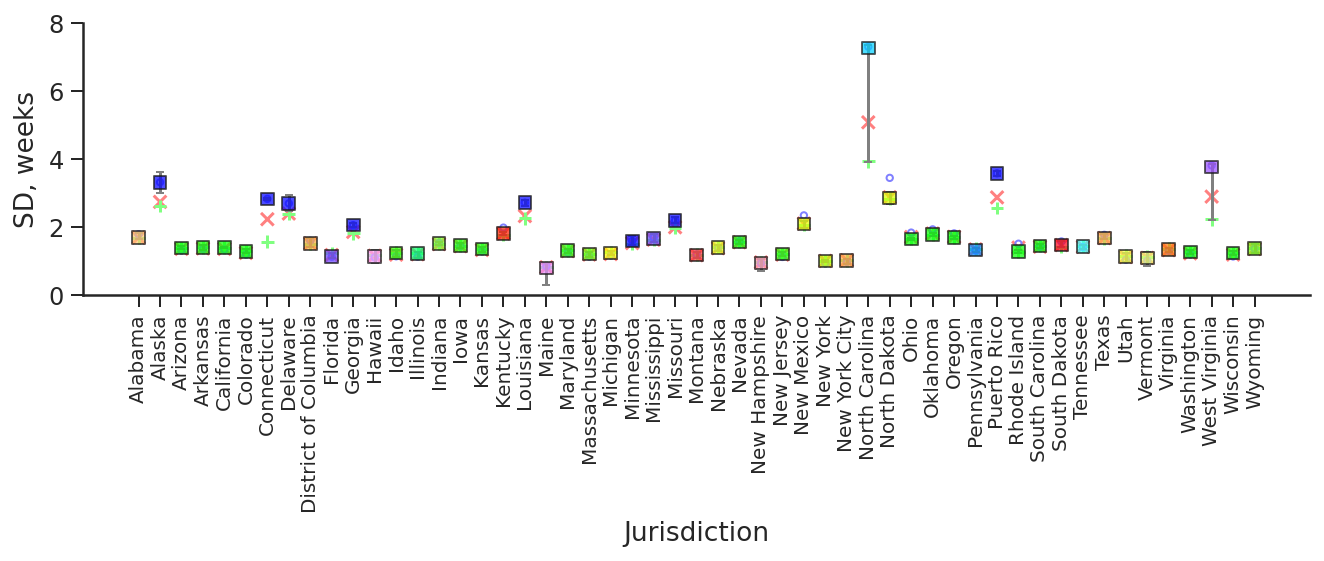

In [93]:
lbls = ['Mean', 'SD']
mrks = ['x', '+', '.']
mrk_clrs = [(1,0.5,0.5), (0.5,1,0.5), (0.5,0.5,1)]
ylms = [12.5, 8]
szs = [4, 2.5]
legend_elements = [Line2D([0], [0], marker=mrks[idx_], color='w', 
                          label=df_index_distribution.loc[lambda d: d.idx_distribution==idx_].distribution.values[0], 
                          markeredgecolor=mrk_clrs[idx_], markerfacecolor='w',
                          markersize=6) for idx_ in df_index_distribution.idx_distribution.values]
legend_elements = list(np.r_[legend_elements, [Line2D([0], [0], marker='s', color='w',
                                                      label='mixture', markeredgecolor='k', markersize=6)]])

for idx0_, var_ in enumerate(['mean_delay', 'sd_delay']):
    fig, ax = plt.subplots()
    fig.set_size_inches(11, szs[idx0_])
    for idx0__, distrib in enumerate(['gamma', 'weibull','lognormal']): #

        df_output_ = df_distribs_output.loc[lambda d: (d['var']==var_)&(d['distribution']==distrib)].sort_values('jurisdiction')
        X = df_output_.jurisdiction

        clrs = [mrk_clrs[idx_] for idx_ in df_output_.idx_distribution]
        if (distrib=='lognormal'):
            ax.scatter(X, df_output_['median'], marker=mrks[idx0__], facecolor='None', 
                       edgecolor=clrs, s=40, alpha=1, zorder=-6)
        else:
            ax.scatter(X, df_output_['median'], marker=mrks[idx0__], c=clrs,  
                       edgecolor=clrs, s=40, alpha=1, zorder=-6)
    
    df_output_ = df_parametric_output.sort_values('jurisdiction').loc[lambda d: d['var']==var_]
    X = df_output_.jurisdiction

    Y = np.stack([df_parametric_output.sort_values('jurisdiction')\
            .loc[lambda d: (d['var']=='q')&(d['idx_model']==str(x)),'mean'].values for x in range(3)], 1)
    clrs = list(map(tuple, Y/np.max(Y,-1)[:,None]))
#     ax.errorbar(X, .5*(df_output_['q25']+df_output_['q75']), .5*(df_output_['q75']-df_output_['q25']), linewidth=3.25,
#                 color='grey', linestyle='None', zorder=-4)
    ax.errorbar(X, .5*(df_output_['q2.5']+df_output_['q97.5']), .5*(df_output_['q97.5']-df_output_['q2.5']), capsize=2,
                color='grey', linestyle='None', zorder=-5)
    ax.scatter(X, df_output_['median'], marker='s', edgecolor='k', alpha=.7, facecolor=clrs, s=40); 

    ax.set_yticks(np.arange(0,ylms[idx0_]+2,2))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False);
    plt.xticks(rotation='vertical', fontsize=10);
    if idx0_==0:
        ax.legend(handles=legend_elements, fontsize=12)
    else:
        ax.set_xlabel('Jurisdiction')
    ax.set_ylabel(lbls[idx0_] +', weeks')
    ax.set_ylim(bottom=0,top=ylms[idx0_])
    
    fig.savefig('../../figures/draft/FigS1-'+str(idx0_+1)+'.pdf', format="pdf", bbox_inches='tight')

## <font color="orange">Figure 2</font>

### Checking if other jurisdictions *significantly* deviating from the others

/home/aakhmetz/anaconda/lib/python3.8/site-packages/pandas/core/arraylike.py:358: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


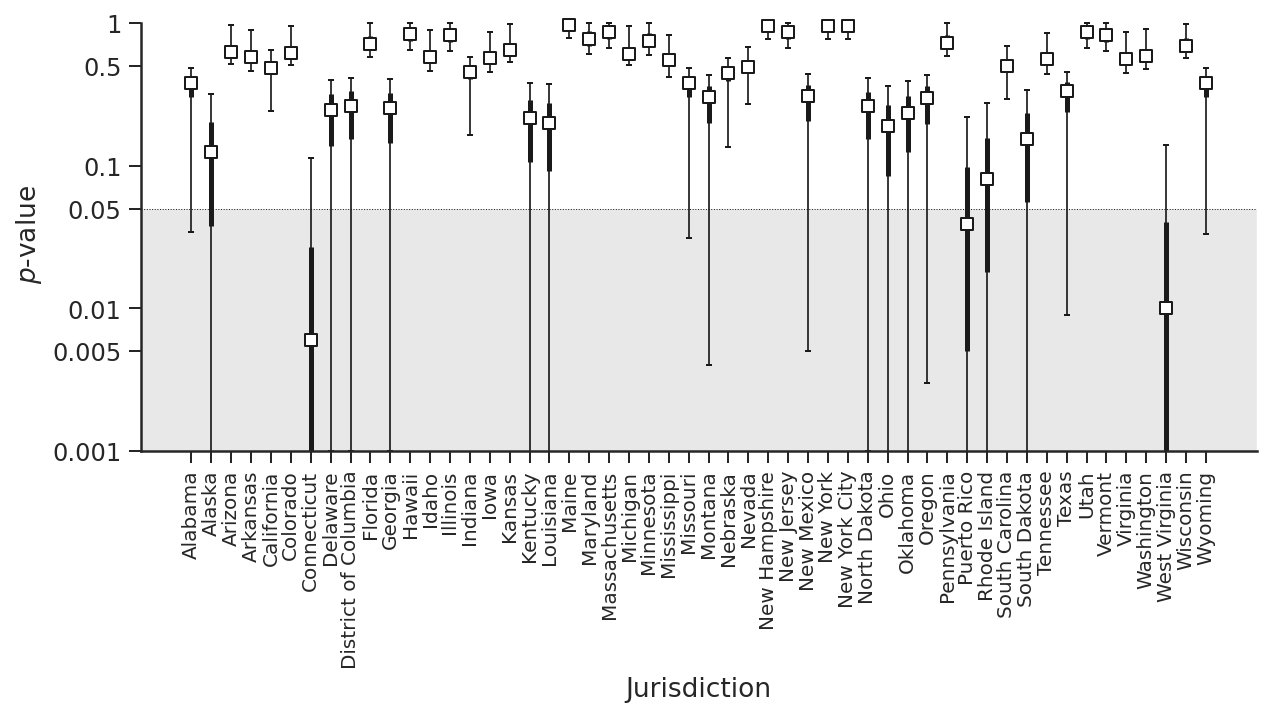

In [94]:
fig, ax = plt.subplots()
fig.set_size_inches(10,4)

ymin = -3
df_output_ = df_output0_t_score.copy()
X = df_output_.jurisdiction

y_lower = np.array([x if np.isfinite(x) else 2*ymin for x in np.log10(df_output_['q25']).values])
y_upper = np.array([x if np.isfinite(x) else 2*ymin for x in np.log10(df_output_['q75']).values])
ax.errorbar(X, .5*(y_lower+y_upper), .5*(y_upper-y_lower), linewidth=2.5, color='k', linestyle='None', zorder=-4)

y_lower = np.array([x if np.isfinite(x) else 2*ymin for x in np.log10(df_output_['q2.5']).values])
y_upper = np.array([x if np.isfinite(x) else 2*ymin for x in np.log10(df_output_['q97.5']).values])
ax.errorbar(X, .5*(y_lower+y_upper), .5*(y_upper-y_lower), capsize=1.5, linewidth = .85, color='k', linestyle='None', zorder=-5)

ax.scatter(X, np.log10(df_output_['median']), marker='s', edgecolor='k', facecolor='w', s=40);
    
[ax.axhline(y, linestyle='dotted', color='k', zorder=-5, lw=.5) for y in np.log10([.05])]
ax.axhspan(ymin-4, np.log10(0.05), facecolor='C7', alpha=0.2, zorder=-7)
    
ax.set_xlabel('Jurisdiction'); ax.set_ylabel('$p$-value')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_bounds([ymin, 0])
plt.xticks(rotation='vertical', fontsize=10);
ax.set_ylim(bottom=ymin,top=0.05)
ytks = [.001,.005,.01,0.05,0.1,0.5,1]; ax.set_yticks(np.log10(ytks)); ax.set_yticklabels(ytks);

fig.savefig('../../figures/draft/FigS2.pdf', format="pdf", bbox_inches='tight')

In [95]:
df_output0_t_score_outliers = df_output0_t_score.loc[lambda d: d['median']<0.05]
df_output0_t_score_outliers

var  idx_jurisdiction   mean  hdi2.5  hdi25  hdi75  hdi97.5  q2.5  \
6   t_score                 7  0.020     0.0    0.0  0.006    0.091   0.0   
39  t_score                40  0.061     0.0    0.0  0.039    0.194   0.0   
49  t_score                50  0.028     0.0    0.0  0.010    0.115   0.0   

      q25  median    q75  q97.5  ess_bulk  ess_tail  r_hat   jurisdiction  
6   0.000   0.006  0.027  0.114    2437.0    2418.0    1.0    Connecticut  
39  0.005   0.039  0.098  0.220    2290.0    2251.0    1.0    Puerto Rico  
49  0.001   0.010  0.040  0.139    2404.0    2331.0    1.0  West Virginia

In [96]:
df_output.loc[lambda d: (d['var']=='mean_delay')&(d.jurisdiction.isin(df_output0_t_score_outliers.jurisdiction.values))]

var  idx_jurisdiction   mean  hdi2.5  hdi25  hdi75  hdi97.5   q2.5  \
6   mean_delay                 7  5.817   5.801  5.812  5.823    5.833  5.801   
39  mean_delay                40  4.694   4.679  4.689  4.699    4.709  4.679   
49  mean_delay                50  5.488   5.473  5.483  5.494    5.505  5.472   

      q25  median    q75  q97.5  ess_bulk  ess_tail  r_hat   jurisdiction  
6   5.812   5.817  5.823  5.833    5100.0    3800.0    1.0    Connecticut  
39  4.689   4.694  4.700  4.709    5415.0    4259.0    1.0    Puerto Rico  
49  5.483   5.488  5.494  5.504    4996.0    4033.0    1.0  West Virginia

## <font color="orange">Figure 1B</font>

['North Carolina' 'West Virginia' 'Connecticut' 'Puerto Rico' 'Alaska']


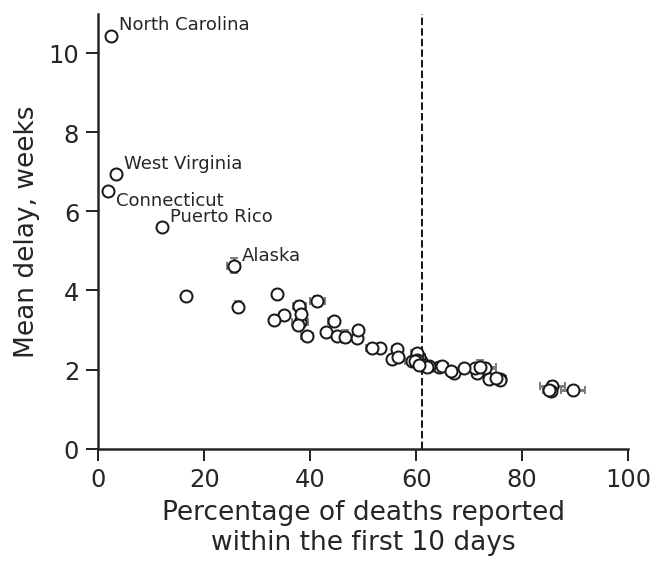

In [97]:
fig, ax = plt.subplots()
fig.set_size_inches(4.75, 4)
df_output_ = df_nonparametric_output.loc[lambda d: (d['var']=='mean_delay')].sort_values('jurisdiction')
df_output__ = df_nonparametric_output.loc[lambda d: (d['var']=='fd')&(d['d']==str(0))].sort_values('jurisdiction')
X = df_output_.jurisdiction

jurisdictions_to_annotate = df_output_.sort_values('mean',ascending=False).jurisdiction.values[:5]
print(jurisdictions_to_annotate)

ax.errorbar(df_output__['mean'].values, .5*(df_output_['q2.5']+df_output_['q97.5']), .5*(df_output_['q97.5']-df_output_['q2.5']), capsize=2,
            color='grey', linestyle='None', zorder=-5)
ax.errorbar(.5*(df_output__['q97.5'].values + df_output__['q2.5'].values), 
            df_output_['mean'],
            xerr=.5*(df_output__['q97.5'].values - df_output__['q2.5'].values ), capsize=2,
            color='grey', linestyle='None', zorder=-5)
ax.scatter(df_output__['mean'].values, df_output_['mean'], marker='o', facecolor='w', edgecolor='k', s=36); 

ax.axvline([0.61], linestyle='dashed', color='k', zorder=-6, lw=1)
#ax.axhline([t_ppfs[1, 2]], linestyle='dashed', color='k', zorder=-6, lw=1)

df_output_to_annotate = df_output_.loc[lambda d: d['jurisdiction'].isin(jurisdictions_to_annotate)]
df_output__to_annotate = df_output__.loc[lambda d: d['jurisdiction'].isin(jurisdictions_to_annotate)]

for idx_ in range(len(jurisdictions_to_annotate)):
    jurisdiction_ = df_output_to_annotate.jurisdiction.values[idx_]
    xshift = .015
    yshift = .15
    if (jurisdiction_=='Rhode Island'):
        xshift = -.12; yshift = .25
    if (jurisdiction_=='Louisiana'):
        xshift = -.065; yshift = .3
    if jurisdiction_=='Connecticut': yshift=-.35
    ax.annotate(jurisdiction_, 
                xy=(df_output__to_annotate['mean'].values[idx_]+xshift, df_output_to_annotate['mean'].values[idx_]+yshift), fontsize=9)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
ax.set_xlabel('Percentage of deaths reported\nwithin the first 10 days')
ax.set_ylabel('Mean delay, weeks')
ax.set_ylim(bottom=0,top=11)
ax.set_xlim(left=0,right=1)
xtks = np.arange(0,1.2,.2)
ax.set_xticks(xtks)
ax.set_xticklabels([int(100*x) for x in xtks])

fig.savefig('../../figures/draft/Fig1B.pdf', format="pdf", bbox_inches='tight')

# <font color="purple">Census data</font>

Needed for later

In [98]:
data_folder = "../../data_raw/census"
!ls {data_folder}

na-est2019-01.xlsx
population_estimates_2010-2019.csv
population_estimates_2010-2019_description.txt
population_estimates_2010-2019_meta.csv


In [99]:
df_pop = pd.read_csv(data_folder + "/population_estimates_2010-2019.csv").loc[lambda d: d['DATE_CODE'].str.contains("2019")]\
    .rename(columns={'NAME':'jurisdiction', 'POP':'population'}).loc[:, ['jurisdiction','population']].reset_index(drop=True)
pop_NYC = 8336817
df_pop = df_pop.append(pd.DataFrame({'jurisdiction': ['New York City'], 'population': [pop_NYC]}))
df_pop.loc[lambda d: d.jurisdiction=='New York', 'population'] = df_pop.loc[lambda d: d.jurisdiction=='New York', 'population'].values[0] - pop_NYC
df_pop[:5]

jurisdiction  population
0      Alabama     4903185
1       Alaska      731545
2      Arizona     7278717
3     Arkansas     3017804
4   California    39512223

# <font color="purple">Number of reported COVID-19 deaths from September to December 2020</font>

December is excluded from the analysis

In [100]:
data_folder = "../../data_raw/case_counts"
deaths_files=!ls {data_folder} | grep ^death
deaths_files

['death_daily_trends__alabama.csv',
 'death_daily_trends__alaska.csv',
 'death_daily_trends__arizona.csv',
 'death_daily_trends__arkansas.csv',
 'death_daily_trends__california.csv',
 'death_daily_trends__colorado.csv',
 'death_daily_trends__connecticut.csv',
 'death_daily_trends__delaware.csv',
 'death_daily_trends__district_of_columbia.csv',
 'death_daily_trends__florida.csv',
 'death_daily_trends__georgia.csv',
 'death_daily_trends__hawaii.csv',
 'death_daily_trends__idaho.csv',
 'death_daily_trends__illinois.csv',
 'death_daily_trends__indiana.csv',
 'death_daily_trends__iowa.csv',
 'death_daily_trends__kansas.csv',
 'death_daily_trends__kentucky.csv',
 'death_daily_trends__louisiana.csv',
 'death_daily_trends__maine.csv',
 'death_daily_trends__maryland.csv',
 'death_daily_trends__massachusetts.csv',
 'death_daily_trends__michigan.csv',
 'death_daily_trends__minnesota.csv',
 'death_daily_trends__mississippi.csv',
 'death_daily_trends__missouri.csv',
 'death_daily_trends__montana.cs

In [101]:
df_deaths_files = pd.DataFrame({'file': deaths_files, 
              'jurisdiction': [x.split("__")[-1][:-4].replace("_"," ").title().replace(" Of "," of ") for x in deaths_files]})
df_deaths_files[:5]

file jurisdiction
0     death_daily_trends__alabama.csv      Alabama
1      death_daily_trends__alaska.csv       Alaska
2     death_daily_trends__arizona.csv      Arizona
3    death_daily_trends__arkansas.csv     Arkansas
4  death_daily_trends__california.csv   California

In [102]:
df_deaths_reported = None
date_upper =pd.to_datetime('2020-12-01')
date_lower = pd.to_datetime('2020-09-01')
for idx_ in range(df_deaths_files.shape[0]):
    case_file_ = df_deaths_files.loc[idx_, 'file']
    jurisdiction_ = df_deaths_files.loc[idx_, 'jurisdiction']
    df_ = pd.read_csv(data_folder+"/"+case_file_,skiprows=3)
    df_['Date'] = pd.to_datetime(df_.Date)
    pop_ = df_pop.loc[lambda d: d.jurisdiction==jurisdiction_, 'population'].values[0]
    deaths_ = df_.loc[lambda d: (d['Date']<date_upper)&(d['Date']>=date_lower),'New Deaths'].sum()
    df_deaths_ = pd.DataFrame({'jurisdiction': [jurisdiction_], 'deaths': [deaths_], 'pop': [pop_]})
    df_deaths_reported = df_deaths_ if df_deaths_reported is None else df_deaths_reported.append(df_deaths_)
df_deaths_reported = df_nonparametric_output.loc[lambda d: (d['var']=='mean_delay')].sort_values('jurisdiction')\
    .loc[:,['jurisdiction', 'mean', 'q2.5', 'q97.5']].merge(df_deaths_reported)
df_deaths_reported['rate'] = df_deaths_reported['deaths']/df_deaths_reported['pop']*1e5 / pd.Timedelta(date_upper - date_lower).days * 7
df_deaths_reported[:5] #(d['var']=='fd')&(d['d']==str(0))

jurisdiction   mean   q2.5  q97.5  deaths       pop      rate
0      Alabama  2.804  2.743  2.867    1413   4903185  2.216769
1       Alaska  4.625  4.447  4.809      83    731545  0.872758
2      Arizona  2.058  2.017  2.104    1612   7278717  1.703597
3     Arkansas  2.218  2.152  2.290    1705   3017804  4.346003
4   California  2.277  2.259  2.300    6208  39512223  1.208584

(0.0, 8.567628142675801)

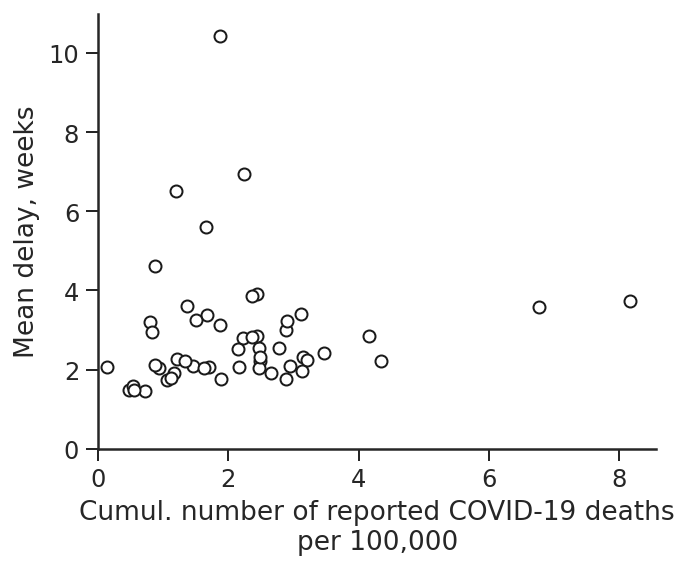

In [103]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 4)

ax.scatter(df_deaths_reported['rate'].values, df_deaths_reported['mean'].values, 
           marker='o', facecolor='w', edgecolor='k', s=36); 

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
ax.set_xlabel('Cumul. number of reported COVID-19 deaths\nper 100,000')
ax.set_ylabel('Mean delay, weeks')
ax.set_ylim(bottom=0,top=11)
ax.set_xlim(left=0)
# xtks = np.arange(0,1.2,.2)
# ax.set_xticks(xtks)
# ax.set_xticklabels([int(100*x) for x in xtks]);

### <font color="blue">Alternative linear regression model with a non-zero slope</font>

In [104]:
standirname = stanworkdir+'/'+stanmaindir+'/linear_regression_deaths'
!mkdir -p {standirname}
stanscriptdir = '../Dropbox/'+standirname[9:]

In [54]:
%%time
stan_code = """
data {
    int<lower = 1> J; // number of points / jurisdictions
    vector<lower = 0>[J] mean_delay; // calculated mean delays
    vector<lower = 0>[J] rate; // rate per 100,000
    
    real<lower = 0> Xmax;
    int<lower = 2> M;
}

parameters {
    real a;
    real b;

    real<lower = 0> nu;
    real<lower = 0> sigma;
}

model {
    a ~ std_normal();
    b ~ std_normal();
    nu ~ cauchy(0, 5);
    sigma ~ cauchy(0, 5);
    
    target += student_t_lpdf(mean_delay | nu, a + b * rate, sigma); 
}

generated quantities {
    vector[J] llk;
    
    for (j in 1:J)
        llk[j] = student_t_lpdf(mean_delay[j] | nu, a + b * rate[j], sigma);
    
    vector[M] X;
    vector[M] Y;
    
    for (m in 1:M) {
        X[m] = 1.0 * m / M * Xmax;
        Y[m] = a + b * X[m];
    }
}
"""

bash_file = """#!/bin/bash
cwd=$(pwd)
cd """+standistribdir+"""
make -j4 """+stanscriptdir+"""/fit
cd """+stanscriptdir+"""
mkdir -p diagnostics
for i in {1..4}
do
    echo Running ${i}
    SEEDNUMBER=$((1+$i))
    ./fit \\
        method=sample num_samples=12500 num_warmup=10000 thin=1 save_warmup=0 \\
            algorithm=hmc \\
                engine=nuts \\
        random seed=${SEEDNUMBER} \\
        id=$i \\
        data file=Data.R \\
        output file=trace-$i.csv \\
            diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
done
echo Finished haha!
"""

# data file
stan_data = dict({
    'J': df_deaths_reported.shape[0],
    'rate': df_deaths_reported['rate'].values,
    'mean_delay': df_deaths_reported['mean'].values,
    'M': 50,
    'Xmax': 9
})
pystan.misc.stan_rdump(stan_data, standirname+'/Data.R')

f = open(standirname+"/fit.stan", "w")
f.write(stan_code)
f.close()

# bash file
f = open(standirname+"/fit_bash.sh", "w")
f.write(bash_file)
f.close()

# compilation
!rm -f {standirname+"/fit"}
os.system("bash "+standirname+"/fit_bash.sh")

CPU times: user 2.86 ms, sys: 20.3 ms, total: 23.2 ms
Wall time: 6.93 s


0

In [105]:
%%time
posterior_glob = !cd "{standirname}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [standirname+"/"+x for x in posterior_glob], log_likelihood='llk')
df_output_ = get_stats(cmdstan_data, ['a', 'b', 'Y', 'X'])
df_output_[:11]

/home/aakhmetz/anaconda/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/aakhmetz/anaconda/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
/home/aakhmetz/anaconda/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)


CPU times: user 7.49 s, sys: 31.1 ms, total: 7.52 s
Wall time: 7.52 s


var time   mean  hdi2.5  hdi25  hdi75  hdi97.5   q2.5    q25  median  \
0    a   NA  1.795   1.471  1.662  1.881    2.134  1.490  1.678   1.785   
1    b   NA  0.240   0.128  0.213  0.283    0.354  0.122  0.206   0.242   
2    Y    1  1.838   1.529  1.719  1.928    2.160  1.547  1.727   1.828   
3    Y    2  1.881   1.592  1.762  1.961    2.191  1.605  1.775   1.872   
4    Y    3  1.925   1.646  1.811  2.000    2.217  1.662  1.824   1.915   
5    Y    4  1.968   1.711  1.860  2.040    2.254  1.720  1.872   1.959   
6    Y    5  2.011   1.764  1.903  2.074    2.280  1.775  1.920   2.003   
7    Y    6  2.054   1.811  1.958  2.122    2.302  1.829  1.967   2.047   
8    Y    7  2.097   1.870  2.003  2.159    2.341  1.882  2.014   2.090   
9    Y    8  2.141   1.923  2.050  2.200    2.374  1.933  2.061   2.134   
10   Y    9  2.184   1.970  2.106  2.251    2.405  1.984  2.107   2.177   

      q75  q97.5  ess_bulk  ess_tail  r_hat  
0   1.900  2.157   21289.0   22099.0    1.0  
1   0.276  0.348   22529.0   22756.0    1.0  
2   1.938  2.183   21548.0   22386.0    1.0  
3   1.976  2.212   21878.0   22951.0    1.0  
4   2.015  2.239   22301.0   23681.0    1.0  
5   2.054  2.267   22839.0   24381.0    1.0  
6   2.093  2.294   23521.0   25524.0    1.0  
7   2.132  2.327   24389.0   26778.0    1.0  
8   2.172  2.357   25495.0   28553.0    1.0  
9   2.212  2.390   26888.0   29519.0    1.0  
10  2.252  2.424   28645.0   31154.0    1.0

## <font color="orange">Figure 1B</font>

['North Dakota' 'South Dakota' 'Arkansas' 'Montana']


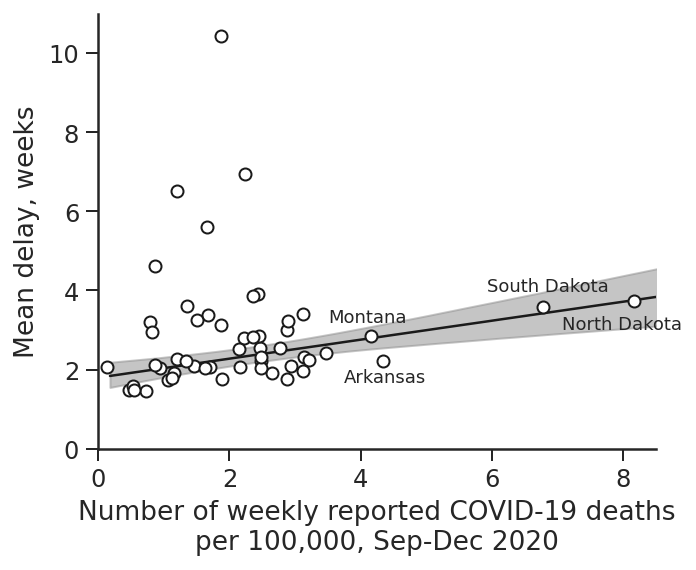

In [106]:
fig, ax = plt.subplots()
fig.set_size_inches(5, 4)

ax.fill_between(df_output_.loc[lambda d: d['var']=='X', 'mean'],
                df_output_.loc[lambda d: d['var']=='Y', 'q2.5'],
                df_output_.loc[lambda d: d['var']=='Y', 'q97.5'],
                color='C7', alpha=.5)
ax.plot(df_output_.loc[lambda d: d['var']=='X', 'mean'],
        df_output_.loc[lambda d: d['var']=='Y', 'mean'], 
        color='k', lw=1.25)

ax.scatter(df_deaths_reported['rate'], df_deaths_reported['mean'], 
           marker='o', facecolor='w', edgecolor='k', s=36, zorder=3); 


jurisdictions_to_annotate = df_deaths_reported.sort_values('rate',ascending=False).jurisdiction.values[:4]
print(jurisdictions_to_annotate)

df_output_to_annotate = df_deaths_reported.loc[lambda d: d['jurisdiction'].isin(jurisdictions_to_annotate)]

xshift_ = [-.6, -.65, -1.1, -.85]
yshift_ = [-.55, .35, -.7, .4]
for idx_ in range(len(jurisdictions_to_annotate)):
    jurisdiction_ = df_output_to_annotate.jurisdiction.values[idx_]
    ax.annotate(jurisdiction_, 
                xy=(df_output_to_annotate['rate'].values[idx_]+xshift_[idx_], df_output_to_annotate['mean'].values[idx_]+yshift_[idx_]), fontsize=9)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False);
ax.set_xlabel('Number of weekly reported COVID-19 deaths\nper 100,000, Sep-Dec 2020')
ax.set_ylabel('Mean delay, weeks')
ax.set_ylim(bottom=0,top=11)
ax.set_xlim(left=0,right=8.5);

fig.savefig('../../figures/draft/Fig1C.pdf', format="pdf", bbox_inches='tight')

In [107]:
Y_ = [1/b for b in np.hstack(cmdstan_data.posterior.b)]
print(np.mean(Y_)) 
np.quantile(Y_, [.025, .5, .975])

4.495890295509731


array([2.8697334 , 4.13226556, 8.15895105])

### <font color="blue">Null linear regression model with a zero slope</font>

In [61]:
standirname_null = stanworkdir+'/'+stanmaindir+'/linear_regression_deaths_null'
!mkdir -p {standirname_null}

stanscriptdir = '../Dropbox/'+standirname_null[9:]

In [62]:
# null model
## stan code
stan_code_null = """
data {
    int<lower = 1> J; // number of points / jurisdictions
    vector<lower = 0>[J] mean_delay; // calculated mean delays
}

parameters {
    real a;

    real<lower = 0> nu;
    real<lower = 0> sigma;
}

model {
    a ~ std_normal();
    nu ~ cauchy(0, 5);
    sigma ~ cauchy(0, 5);
    
    target += student_t_lpdf(mean_delay | nu, a, sigma); 
}

generated quantities {
    vector[J] llk;
    
    for (j in 1:J)
        llk[j] = student_t_lpdf(mean_delay[j] | nu, a, sigma);
}
"""

bash_file = """#!/bin/bash
cwd=$(pwd)
cd """+standistribdir+"""
make -j4 """+stanscriptdir+"""/fit
cd """+stanscriptdir+"""
mkdir -p diagnostics
for i in {1..4}
do
    echo Running ${i}
    SEEDNUMBER=$((1+$i))
    ./fit \\
        method=sample num_samples=12500 num_warmup=10000 thin=1 save_warmup=0 \\
            algorithm=hmc \\
                engine=nuts \\
        random seed=${SEEDNUMBER} \\
        id=$i \\
        data file=Data.R \\
        output file=trace-$i.csv refresh=2000 \\
            diagnostic_file=diagnostics/diagnostics-$i.csv > diagnostics/output-$i.txt &
done
echo Finished haha!
"""

# data file
stan_data = dict({
    'J': df_deaths_reported.shape[0],
    'mean_delay': df_deaths_reported['mean'].values
})
pystan.misc.stan_rdump(stan_data, standirname_null+'/Data.R')

f = open(standirname_null+"/fit.stan", "w")
f.write(stan_code_null)
f.close()

# bash file
f = open(standirname_null+"/fit_bash.sh", "w")
f.write(bash_file)
f.close()

# compilation
!rm -f {standirname_null+"/fit"}
os.system("bash "+standirname_null+"/fit_bash.sh")

0

CPU times: user 656 ms, sys: 24 ms, total: 680 ms
Wall time: 683 ms


var time   mean  hdi2.5  hdi25  hdi75  hdi97.5  q2.5    q25  median  q75  \
0   a   NA  1.795   1.471  1.662  1.881    2.134  1.49  1.678   1.785  1.9   

   q97.5  ess_bulk  ess_tail  r_hat  
0  2.157   21289.0   22099.0    1.0

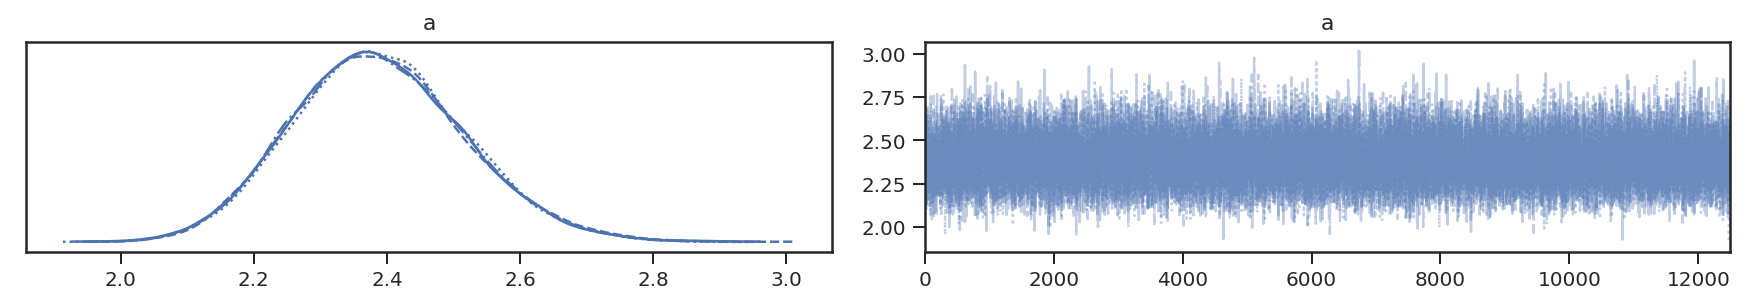

In [63]:
%%time
posterior_glob = !cd "{standirname_null}"; ls trace-*
cmdstan_data_null = az.from_cmdstan(posterior = [standirname_null+"/"+x for x in posterior_glob], log_likelihood='llk')
df_output_ = get_stats(cmdstan_data, ['a'])
az.plot_trace(cmdstan_data_null, var_names=['a']);
df_output_

Comparing alternative and null models

In [64]:
az.compare({"null": cmdstan_data_null, "alternative": cmdstan_data}, method='stacking', ic='loo', scale='deviance')

rank         loo     p_loo      d_loo    weight         se  \
alternative     0  158.664464  4.008368   0.000000  0.932287  21.657506   
null            1  168.760893  3.517203  10.096429  0.067713  20.036955   

                  dse  warning loo_scale  
alternative  0.000000    False  deviance  
null         7.066496    False  deviance

# <font color="purple">Final plots for nowcasting and excess mortality</font>

### As an example, for one particular jurisdiction

In [65]:
region = 5
stanworkdir = '../../../NTU_Backup/mortality-US_all_states_20210204/reporting_delay-nonparametric'
folder = 'nonparametric_region-%02d'%region
print(colored(folder, 'red'))

posterior_glob = !cd "{stanworkdir}/{folder}"; ls trace-*
cmdstan_data = az.from_cmdstan(posterior = [stanworkdir+"/"+folder+"/"+x for x in posterior_glob]) 

deaths_pred = np.vstack(cmdstan_data.posterior.deaths_pred)

df_deaths = pd.read_pickle(stanworkdir+"/"+folder+"/df_deaths_counts.pkl")
df_index_snapshots = pd.read_pickle(stanworkdir+"/"+folder+"/idx_snapshots.pkl")
latest_snapshot = df_index_snapshots.loc[lambda d: d.idx_snapshot==max(df_index_snapshots.idx_snapshot)]
df_deaths0 = df_deaths.loc[lambda d: d.index.get_level_values("idx_snapshot")==latest_snapshot.idx_snapshot.values[0]]

df_deaths_ = df_deaths0.values[0]
df_deaths_ = [x if x>=0 else 5 for x in df_deaths_]

# reporting week
T = df_index_snapshots.loc[lambda d: d.idx_snapshot==np.max(df_index_snapshots.idx_snapshot.values)].reporting_week.values[0]
T = [(int(x)-2020)*53 + int(y) for x,y in [T.split("W")]][0]
# weeks
w = df_deaths.columns.get_level_values('week').values
w = [(int(x)-2020)*53 + int(y) for x,y in [X.split("W") for X in w]]

deaths_predicted_ = np.percentile(deaths_pred, q = [2.5, 25, 50, 75, 97.5], axis=0)

deaths_predicted = np.transpose(np.r_[[w], [df_deaths_], deaths_predicted_]).astype(int)
df_deaths_predicted = pd.DataFrame(deaths_predicted)
df_deaths_predicted.columns = ['week', 'deaths', 'q2.5', 'q25', 'median', 'q75', 'q97.5']
df_deaths_predicted['iso_week'] = [str(2020 + w // 54) + "W" + str(w % 54) for w in df_deaths_predicted['week']]
df_deaths_predicted['date'] = [isoweek.Week(2020 + w // 54, w % 54).monday() for w in df_deaths_predicted['week']]
df_deaths_predicted['x_day'] = (pd.to_datetime(df_deaths_predicted['date']) - pd.Timestamp('20200101')).dt.days
df_deaths_predicted['idx_jurisdiction'] = region
df_deaths_predicted['jurisdiction'] = df_index_jurisdictions.loc[lambda d: d.idx_jurisdiction==region, 'jurisdiction'].values[0]
df_deaths_predicted[-5:]

nonparametric_region-05


week  deaths  q2.5   q25  median   q75  q97.5 iso_week        date  x_day  \
48    49    7053  7058  7063    7066  7070   7079  2020W49  2020-11-30    334   
49    50    7919  7925  7930    7934  7938   7948  2020W50  2020-12-07    341   
50    51    8742  8749  8755    8759  8764   8774  2020W51  2020-12-14    348   
51    52    9492  9500  9507    9511  9516   9527  2020W52  2020-12-21    355   
52    53    8993  9004  9013    9019  9026   9043  2020W53  2020-12-28    362   

    idx_jurisdiction jurisdiction  
48                 5   California  
49                 5   California  
50                 5   California  
51                 5   California  
52                 5   California

### For all jurisdictions

In [66]:
def get_df_death_counts(region, lastdate):
    stanworkdir = '../../../NTU_Backup/mortality-US_all_states_'+lastdate+'/reporting_delay-nonparametric'
    folder = 'nonparametric_region-%02d'%region
    print(colored(folder, 'red'))

    posterior_glob = !cd "{stanworkdir}/{folder}"; ls trace-*
    cmdstan_data = az.from_cmdstan(posterior = [stanworkdir+"/"+folder+"/"+x for x in posterior_glob]) 

    deaths_pred = np.vstack(cmdstan_data.posterior.deaths_pred)

    df_deaths = pd.read_pickle(stanworkdir+"/"+folder+"/df_deaths_counts.pkl")
    df_index_snapshots = pd.read_pickle(stanworkdir+"/"+folder+"/idx_snapshots.pkl")
    latest_snapshot = df_index_snapshots.loc[lambda d: d.idx_snapshot==max(df_index_snapshots.idx_snapshot)]
    df_deaths0 = df_deaths.loc[lambda d: d.index.get_level_values("idx_snapshot")==latest_snapshot.idx_snapshot.values[0]]

    df_deaths_ = df_deaths0.values[0]
    df_deaths_ = [x if x>=0 else 5 for x in df_deaths_]

    # reporting week
    T = df_index_snapshots.loc[lambda d: d.idx_snapshot==np.max(df_index_snapshots.idx_snapshot.values)].reporting_week.values[0]
    T = [(int(x)-2020)*53 + int(y) for x,y in [T.split("W")]][0]
    # weeks
    w = df_deaths.columns.get_level_values('week').values
    w = [(int(x)-2020)*53 + int(y) for x,y in [X.split("W") for X in w]]

    deaths_predicted_ = np.percentile(deaths_pred, q = [2.5, 25, 50, 75, 97.5], axis=0)
    deaths_predicted = np.transpose(np.r_[[w], [df_deaths_], deaths_predicted_]).astype(int)
    
    ## output
    df_deaths_predicted = pd.DataFrame(deaths_predicted)
    df_deaths_predicted.columns = ['week', 'deaths', 'q2.5', 'q25', 'median', 'q75', 'q97.5']
    df_deaths_predicted['iso_week'] = [str(2020 + w // 54) + "W" + str(w % 54) for w in df_deaths_predicted['week']]
    df_deaths_predicted['date'] = [isoweek.Week(2020 + w // 54, w % 54).wednesday() for w in df_deaths_predicted['week']]
    df_deaths_predicted['x_day'] = (pd.to_datetime(df_deaths_predicted['date']) - pd.Timestamp('20200101')).dt.days
    df_deaths_predicted['idx_jurisdiction'] = region
    df_deaths_predicted['jurisdiction'] = df_index_jurisdictions.loc[lambda d: d.idx_jurisdiction==region, 'jurisdiction'].values[0]
    df_deaths_predicted['lastsnapshot'] = lastdate
    return df_deaths_predicted

In [67]:
%%time
df_deaths_predicted = None
clrs_ = ['red', 'blue', 'green', 'yellow']
idx_ = 0
for region in df_index_jurisdictions.idx_jurisdiction.unique():
    print(colored(df_index_jurisdictions.loc[lambda d: d.idx_jurisdiction==region, 'jurisdiction'].values[0], clrs_[idx_%4]))
    for lastdate_ in alldates:
        df_deaths_predicted_ = get_df_death_counts(region, lastdate_)
        df_deaths_predicted = df_deaths_predicted_ if df_deaths_predicted is None else df_deaths_predicted.append(df_deaths_predicted_)
    idx_ += 1
df_deaths_predicted[:5]

Alabama
nonparametric_region-01
nonparametric_region-01
nonparametric_region-01
nonparametric_region-01
Alaska
nonparametric_region-02
nonparametric_region-02
nonparametric_region-02
nonparametric_region-02
Arizona
nonparametric_region-03
nonparametric_region-03
nonparametric_region-03
nonparametric_region-03
Arkansas
nonparametric_region-04
nonparametric_region-04
nonparametric_region-04
nonparametric_region-04
California
nonparametric_region-05
nonparametric_region-05
nonparametric_region-05
nonparametric_region-05
Colorado
nonparametric_region-06
nonparametric_region-06
nonparametric_region-06
nonparametric_region-06
Connecticut
nonparametric_region-07
nonparametric_region-07
nonparametric_region-07
nonparametric_region-07
Delaware
nonparametric_region-08
nonparametric_region-08
nonparametric_region-08
nonparametric_region-08
District of Columbia
nonparametric_region-09
nonparametric_region-09
nonparametric_region-09
nonparametric_region-09
Florida
nonparametric_region-10
nonparamet

week  deaths  q2.5   q25  median   q75  q97.5 iso_week        date  x_day  \
0     1    1081  1081  1081    1081  1081   1081   2020W1  2020-01-01      0   
1     2    1127  1127  1127    1127  1127   1127   2020W2  2020-01-08      7   
2     3    1039  1039  1039    1039  1039   1039   2020W3  2020-01-15     14   
3     4    1054  1054  1054    1054  1054   1054   2020W4  2020-01-22     21   
4     5    1026  1026  1026    1026  1026   1026   2020W5  2020-01-29     28   

   idx_jurisdiction jurisdiction lastsnapshot  
0                 1      Alabama     20210114  
1                 1      Alabama     20210114  
2                 1      Alabama     20210114  
3                 1      Alabama     20210114  
4                 1      Alabama     20210114

### Historical death counts

In [68]:
df_hist = pd.read_pickle("df_historical_deaths.pkl")
df_hist[:5]

jurisdiction  year  week  number_of_deaths  idx_jurisdiction
0      Alabama  2014     1               355                 1
1      Alabama  2014     2               872                 1
2      Alabama  2014     3              1044                 1
3      Alabama  2014     4              1022                 1
4      Alabama  2014     5              1040                 1

In [69]:
df_hist = df_hist.drop('idx_jurisdiction',1).merge(df_index_jurisdictions, on='jurisdiction', how='right')
df_hist[:5]

jurisdiction  year  week  number_of_deaths  idx_jurisdiction
0      Alabama  2014     1               355                 1
1      Alabama  2014     2               872                 1
2      Alabama  2014     3              1044                 1
3      Alabama  2014     4              1022                 1
4      Alabama  2014     5              1040                 1

In [70]:
df_hist['date'] = [isoweek.Week(y, w).monday() for y, w in zip(df_hist['year'].astype(int), df_hist['week'].astype(int))]
df_hist['x_day'] = [pd.to_datetime(x1) - pd.Timestamp('%d0101'%x2) for x1,x2 in zip(df_hist['date'], df_hist['year'])]
df_hist['x_day'] = df_hist['x_day'].dt.days
df_hist[:5]

jurisdiction  year  week  number_of_deaths  idx_jurisdiction        date  \
0      Alabama  2014     1               355                 1  2013-12-30   
1      Alabama  2014     2               872                 1  2014-01-06   
2      Alabama  2014     3              1044                 1  2014-01-13   
3      Alabama  2014     4              1022                 1  2014-01-20   
4      Alabama  2014     5              1040                 1  2014-01-27   

   x_day  
0     -2  
1      5  
2     12  
3     19  
4     26

### Historical data

In [71]:
%%time
stanworkdir_historical = '../../../NTU_Backup/mortality-US_all_states_20210114/historical'
folder_historical = 'baseline_final'
print(colored(folder_historical, 'red'))
posterior_glob_historical = !cd "{stanworkdir_historical}/{folder_historical}"; ls trace-*
cmdstan_data_historical = az.from_cmdstan(posterior = [stanworkdir_historical+"/"+folder_historical+"/"+x for x in posterior_glob_historical])

baseline_final
CPU times: user 4.95 s, sys: 150 ms, total: 5.1 s
Wall time: 5.11 s


In [72]:
%%time
df_output_historical_ = get_stats_2d(cmdstan_data_historical, ['deaths_baseline'])
df_output_historical_[:11]

CPU times: user 52 s, sys: 5.18 ms, total: 52 s
Wall time: 52 s


var  time      mean  hdi2.5   hdi25   hdi75  hdi97.5  \
0   deaths_baseline   0,0  1094.522  1018.0  1067.0  1113.0   1159.0   
1   deaths_baseline   0,1  1091.296  1016.0  1066.0  1113.0   1155.0   
2   deaths_baseline   0,2  1087.046  1014.0  1062.0  1109.0   1153.0   
3   deaths_baseline   0,3  1083.075  1015.0  1060.0  1106.0   1151.0   
4   deaths_baseline   0,4  1077.774  1009.0  1049.0  1096.0   1143.0   
5   deaths_baseline   0,5  1073.302  1007.0  1043.0  1089.0   1141.0   
6   deaths_baseline   0,6  1068.095   999.0  1039.0  1086.0   1136.0   
7   deaths_baseline   0,7  1062.462   993.0  1036.0  1082.0   1128.0   
8   deaths_baseline   0,8  1055.916   987.0  1030.0  1076.0   1124.0   
9   deaths_baseline   0,9  1048.939   980.0  1019.0  1065.0   1114.0   
10  deaths_baseline  0,10  1041.668   972.0  1017.0  1063.0   1108.0   

        q2.5     q25  median     q75   q97.5  ess_bulk  ess_tail  r_hat  
0   1024.975  1071.0  1094.0  1117.0  1166.0    9402.0   10011.0    1.0  
1   1022.000  1067.0  1091.0  1115.0  1161.0   10071.0    9396.0    1.0  
2   1018.000  1063.0  1087.0  1111.0  1158.0    9757.0    9858.0    1.0  
3   1015.000  1060.0  1083.0  1107.0  1152.0   10128.0    9898.0    1.0  
4   1011.000  1054.0  1077.5  1101.0  1145.0   10058.0    9323.0    1.0  
5   1007.000  1050.0  1072.0  1096.0  1142.0    9878.0    9896.0    1.0  
6   1000.000  1044.0  1068.0  1092.0  1138.0    9644.0    9615.0    1.0  
7    996.000  1039.0  1062.0  1086.0  1131.0    9424.0    9056.0    1.0  
8    986.000  1033.0  1056.0  1079.0  1124.0    9531.0    9463.0    1.0  
9    982.000  1026.0  1049.0  1072.0  1116.0    8872.0    9058.0    1.0  
10   975.000  1018.0  1041.0  1065.0  1111.0    9054.0    9860.0    1.0

In [73]:
df_index_jurisdictions_historical = pd.read_pickle(stanworkdir_historical+"/"+folder_historical+"/idx_jurisdictions.pkl")

In [74]:
df_output_historical = df_output_historical_.copy()
df_output_historical[['idx_jurisdiction', 'week']] = df_output_historical['time'].str.split(',',expand=True)
df_output_historical['idx_jurisdiction'] = df_output_historical['idx_jurisdiction'].astype('int') + 1
df_output_historical['week'] = df_output_historical['week'].astype('int') + 1
df_output_historical = df_output_historical.merge(df_index_jurisdictions_historical, on='idx_jurisdiction', how='left')
df_output_historical = df_output_historical.drop('idx_jurisdiction', 1).merge(df_index_jurisdictions, on='jurisdiction', how='left')
df_output_historical

var   time      mean  hdi2.5   hdi25   hdi75  hdi97.5  \
0     deaths_baseline    0,0  1094.522  1018.0  1067.0  1113.0   1159.0   
1     deaths_baseline    0,1  1091.296  1016.0  1066.0  1113.0   1155.0   
2     deaths_baseline    0,2  1087.046  1014.0  1062.0  1109.0   1153.0   
3     deaths_baseline    0,3  1083.075  1015.0  1060.0  1106.0   1151.0   
4     deaths_baseline    0,4  1077.774  1009.0  1049.0  1096.0   1143.0   
...               ...    ...       ...     ...     ...     ...      ...   
2804  deaths_baseline  52,48  1106.750  1040.0  1084.0  1131.0   1178.0   
2805  deaths_baseline  52,49  1112.783  1044.0  1081.0  1130.0   1183.0   
2806  deaths_baseline  52,50  1117.078  1045.0  1094.0  1142.0   1185.0   
2807  deaths_baseline  52,51  1120.681  1044.0  1087.0  1136.0   1189.0   
2808  deaths_baseline  52,52  1124.127  1054.0  1099.0  1148.0   1200.0   

          q2.5     q25  median     q75   q97.5  ess_bulk  ess_tail  r_hat  \
0     1024.975  1071.0  1094.0  1117.0  1166.0    9402.0   10011.0    1.0   
1     1022.000  1067.0  1091.0  1115.0  1161.0   10071.0    9396.0    1.0   
2     1018.000  1063.0  1087.0  1111.0  1158.0    9757.0    9858.0    1.0   
3     1015.000  1060.0  1083.0  1107.0  1152.0   10128.0    9898.0    1.0   
4     1011.000  1054.0  1077.5  1101.0  1145.0   10058.0    9323.0    1.0   
...        ...     ...     ...     ...     ...       ...       ...    ...   
2804  1037.000  1083.0  1106.0  1131.0  1177.0    9518.0    9819.0    1.0   
2805  1043.000  1088.0  1113.0  1137.0  1183.0    9842.0    9705.0    1.0   
2806  1047.000  1092.0  1117.0  1141.0  1188.0    8610.0    9710.0    1.0   
2807  1049.000  1096.0  1120.0  1145.0  1195.0    8535.0    9074.0    1.0   
2808  1051.000  1099.0  1124.0  1149.0  1198.0    8244.0    8918.0    1.0   

      week jurisdiction  idx_jurisdiction  
0        1      Alabama                 1  
1        2      Alabama                 1  
2        3      Alabama                 1  
3        4      Alabama                 1  
4        5      Alabama                 1  
...    ...          ...               ...  
2804    49    Wisconsin                52  
2805    50    Wisconsin                52  
2806    51    Wisconsin                52  
2807    52    Wisconsin                52  
2808    53    Wisconsin                52  

[2809 rows x 18 columns]

In [75]:
# date will be by wednesday (middle of the week)
df_output_historical['date'] = [isoweek.Week(2020, w).wednesday() for w in df_output_historical['week'].astype(int)]
df_output_historical['x_day'] = [pd.to_datetime(x1) - pd.Timestamp('20200101') for x1 in df_output_historical['date']]
df_output_historical['x_day'] = df_output_historical['x_day'].dt.days
df_output_historical[:5]

var time      mean  hdi2.5   hdi25   hdi75  hdi97.5      q2.5  \
0  deaths_baseline  0,0  1094.522  1018.0  1067.0  1113.0   1159.0  1024.975   
1  deaths_baseline  0,1  1091.296  1016.0  1066.0  1113.0   1155.0  1022.000   
2  deaths_baseline  0,2  1087.046  1014.0  1062.0  1109.0   1153.0  1018.000   
3  deaths_baseline  0,3  1083.075  1015.0  1060.0  1106.0   1151.0  1015.000   
4  deaths_baseline  0,4  1077.774  1009.0  1049.0  1096.0   1143.0  1011.000   

      q25  median     q75   q97.5  ess_bulk  ess_tail  r_hat  week  \
0  1071.0  1094.0  1117.0  1166.0    9402.0   10011.0    1.0     1   
1  1067.0  1091.0  1115.0  1161.0   10071.0    9396.0    1.0     2   
2  1063.0  1087.0  1111.0  1158.0    9757.0    9858.0    1.0     3   
3  1060.0  1083.0  1107.0  1152.0   10128.0    9898.0    1.0     4   
4  1054.0  1077.5  1101.0  1145.0   10058.0    9323.0    1.0     5   

  jurisdiction  idx_jurisdiction        date  x_day  
0      Alabama                 1  2020-01-01      0  
1      Alabama                 1  2020-01-08      7  
2      Alabama                 1  2020-01-15     14  
3      Alabama                 1  2020-01-22     21  
4      Alabama                 1  2020-01-29     28

### Plots

In [108]:
## xticks
xstep = 4
x_ = np.r_[12 - np.arange(0,12,xstep), [1]]
xtks = ['2020%02d01'%x for x in x_]
xtks = [(pd.Timestamp(x) - pd.Timestamp('20200101')).days for x in xtks]
xtk_labels = [month_names[x][:3] for x in x_]
xtks, xtk_labels

([335, 213, 91, 0], ['Dec', 'Aug', 'Apr', 'Jan'])

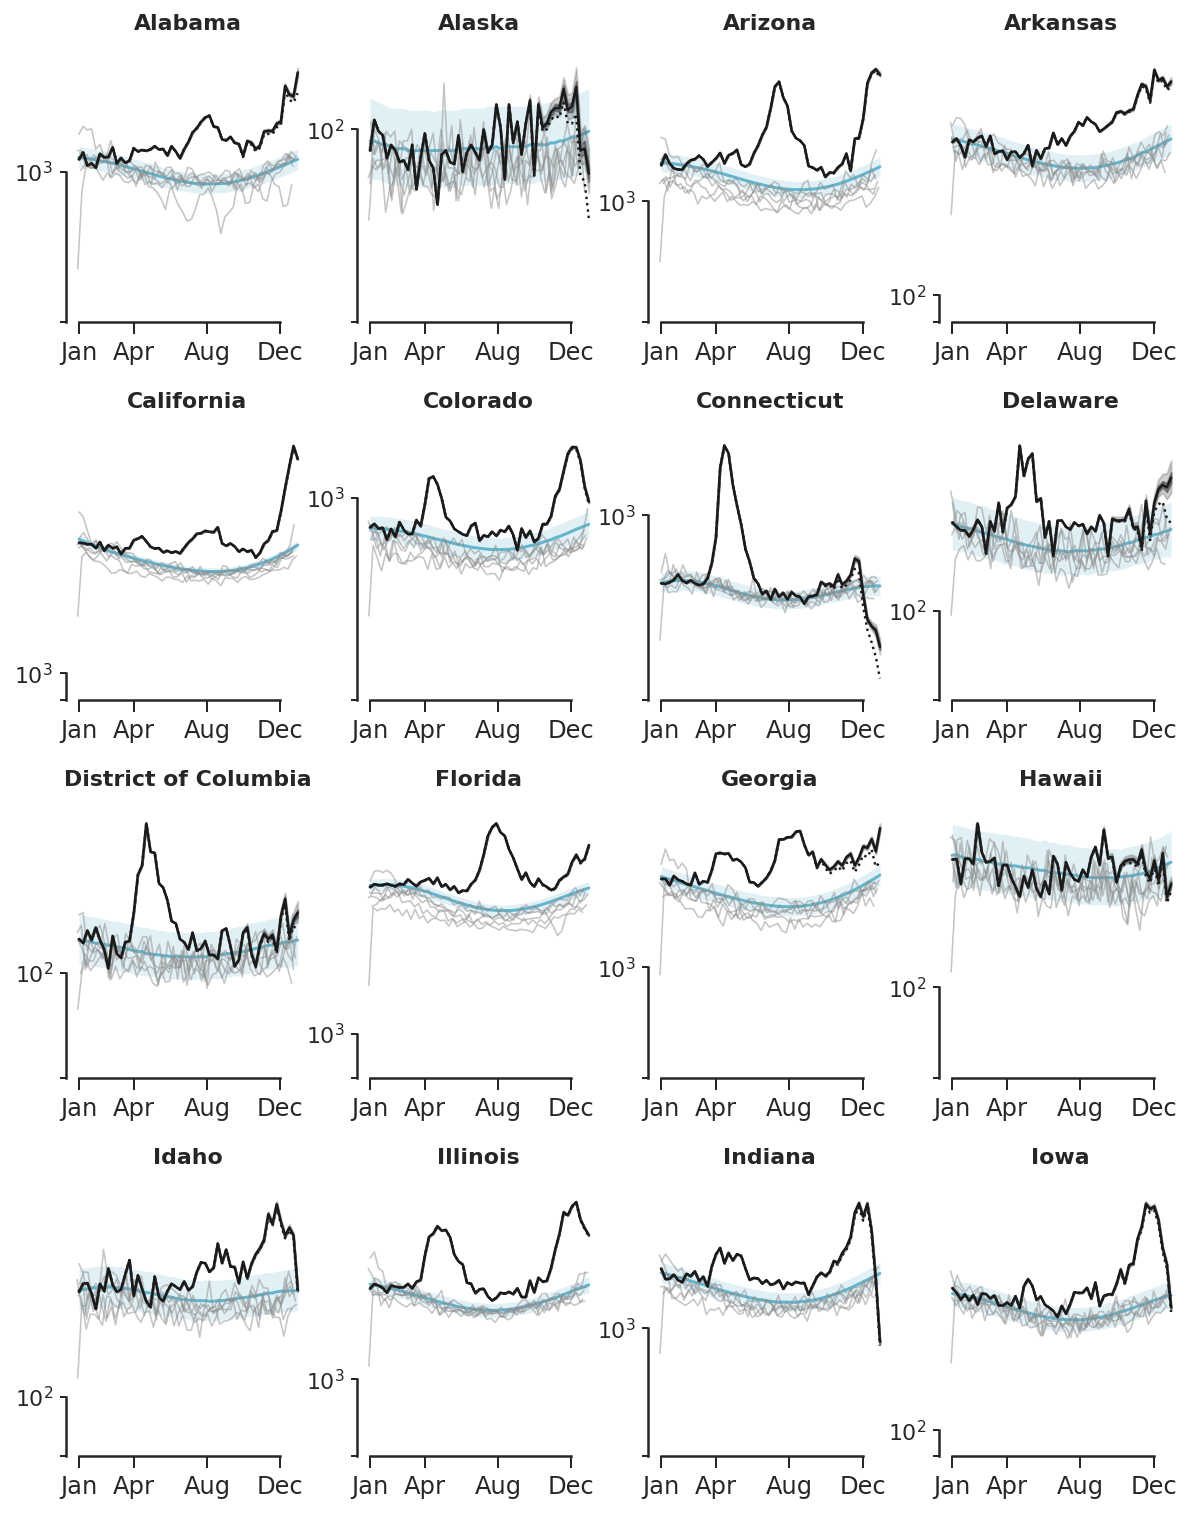

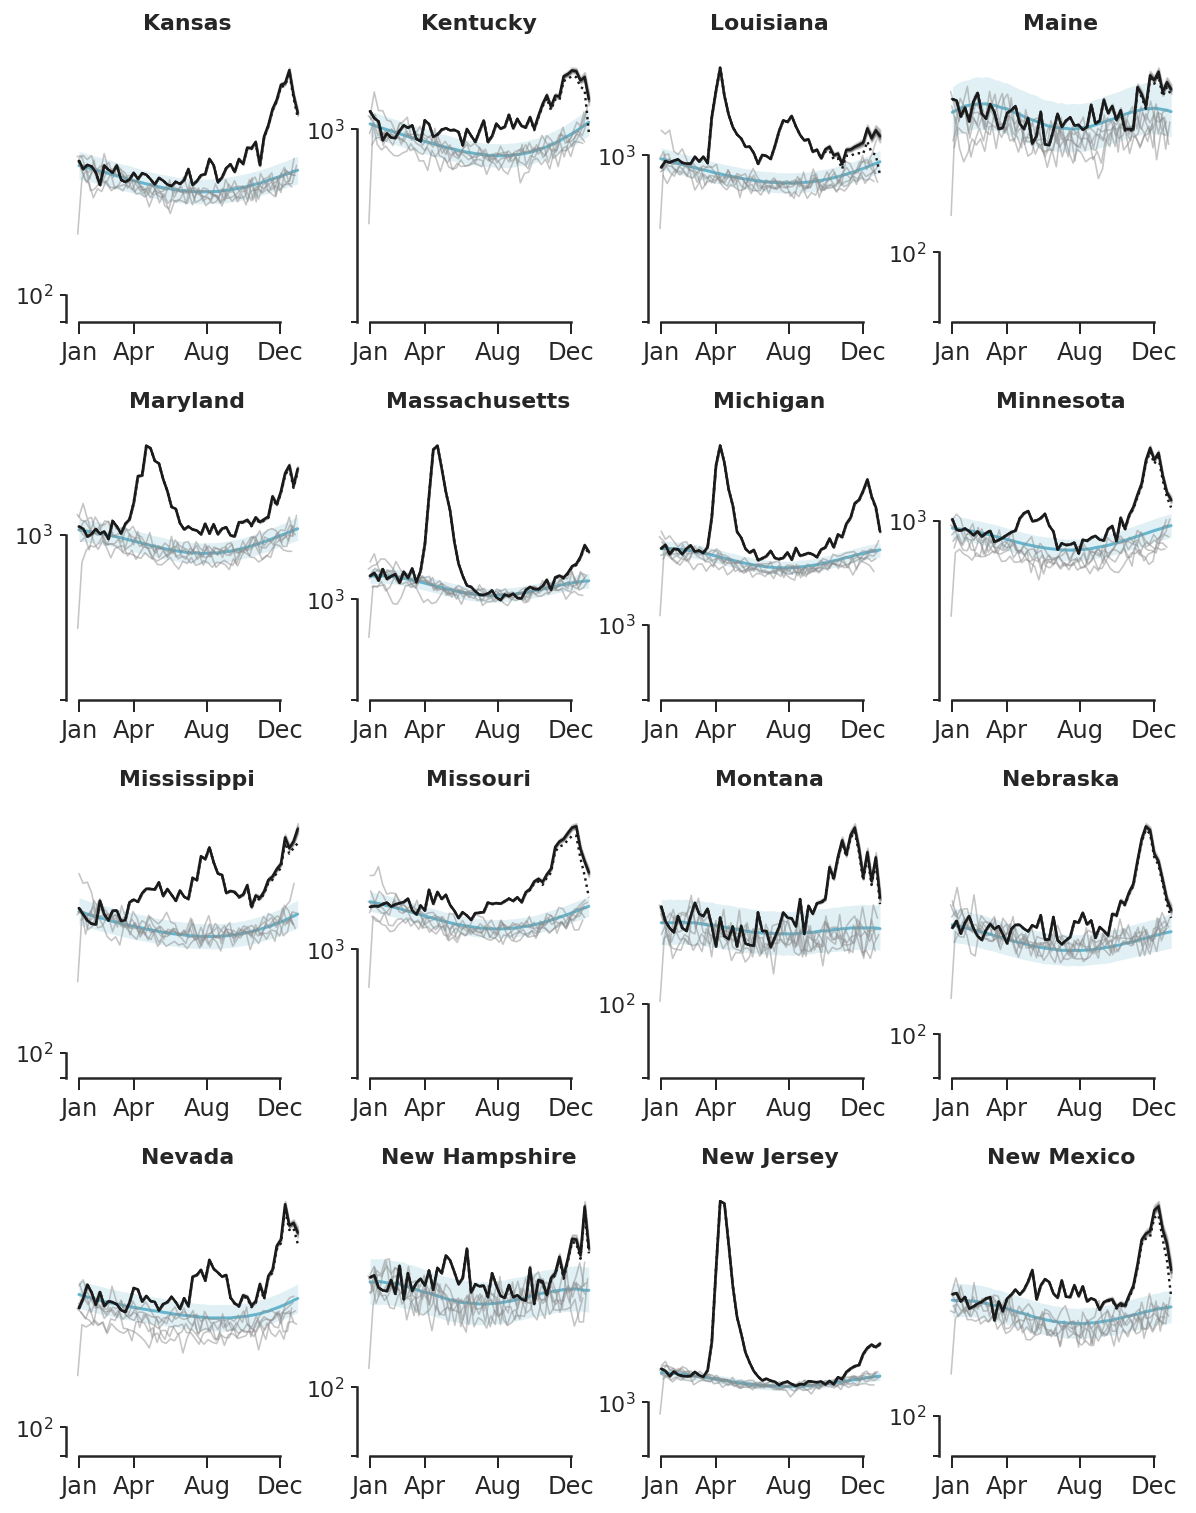

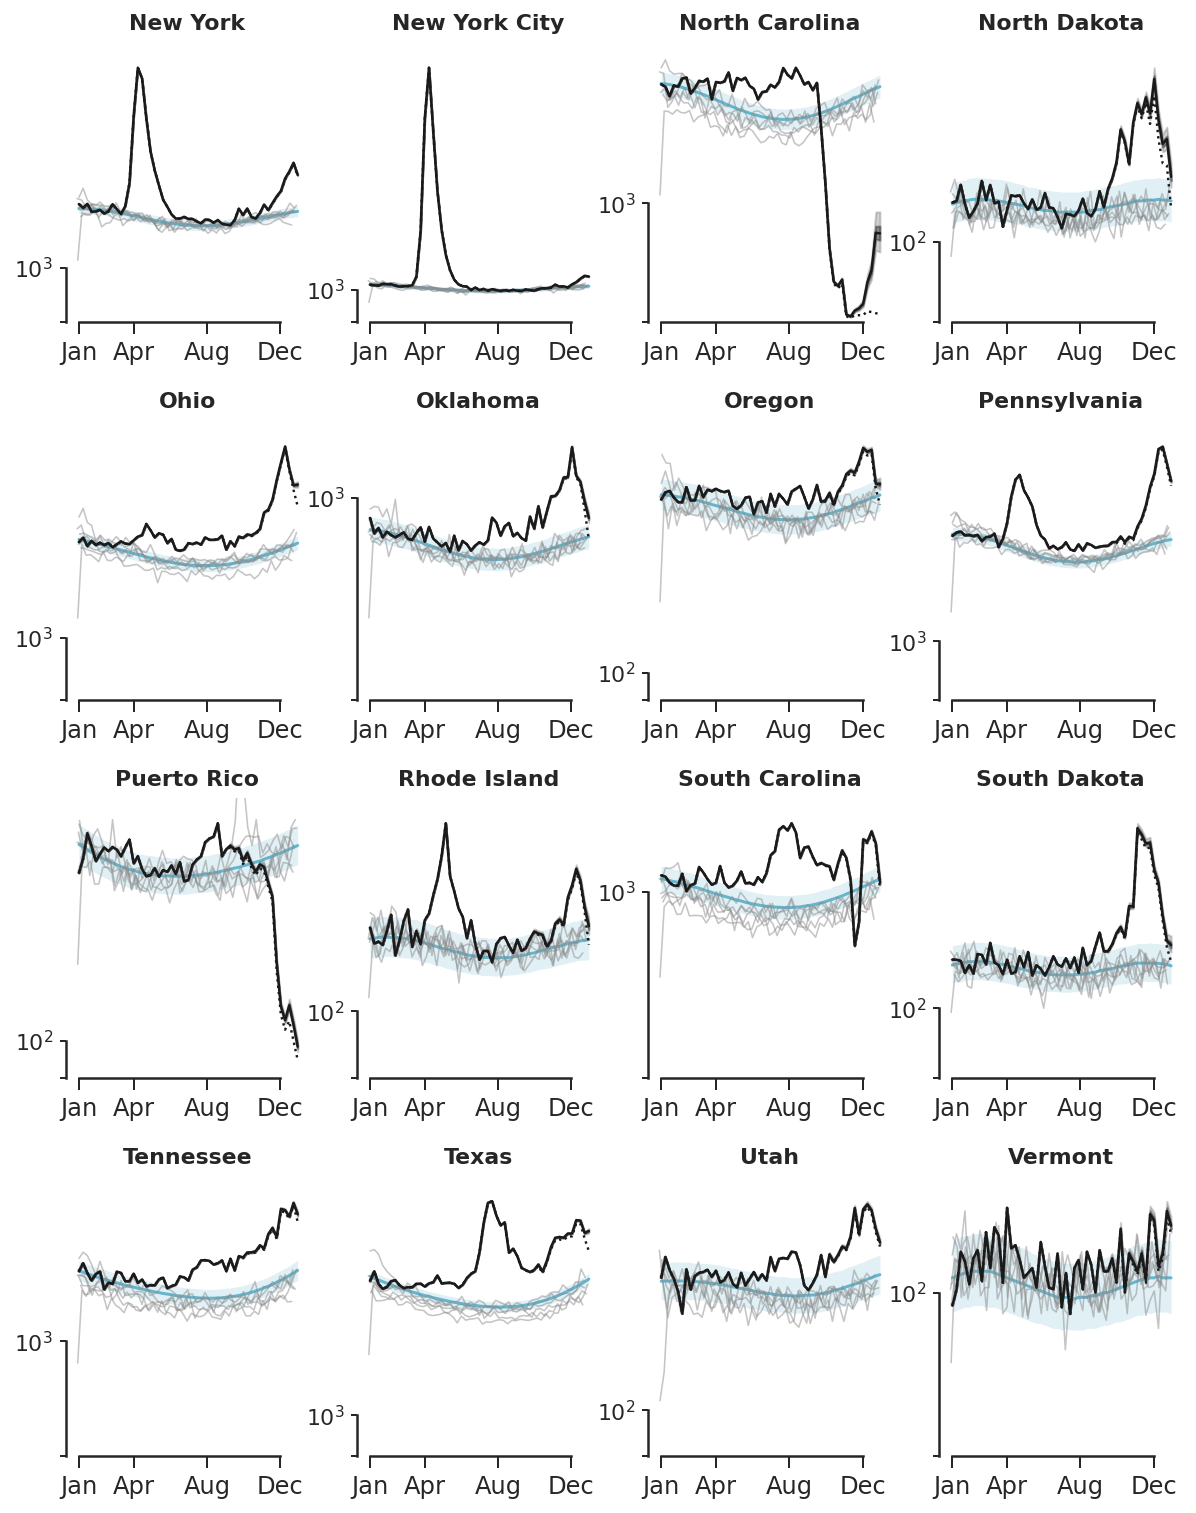

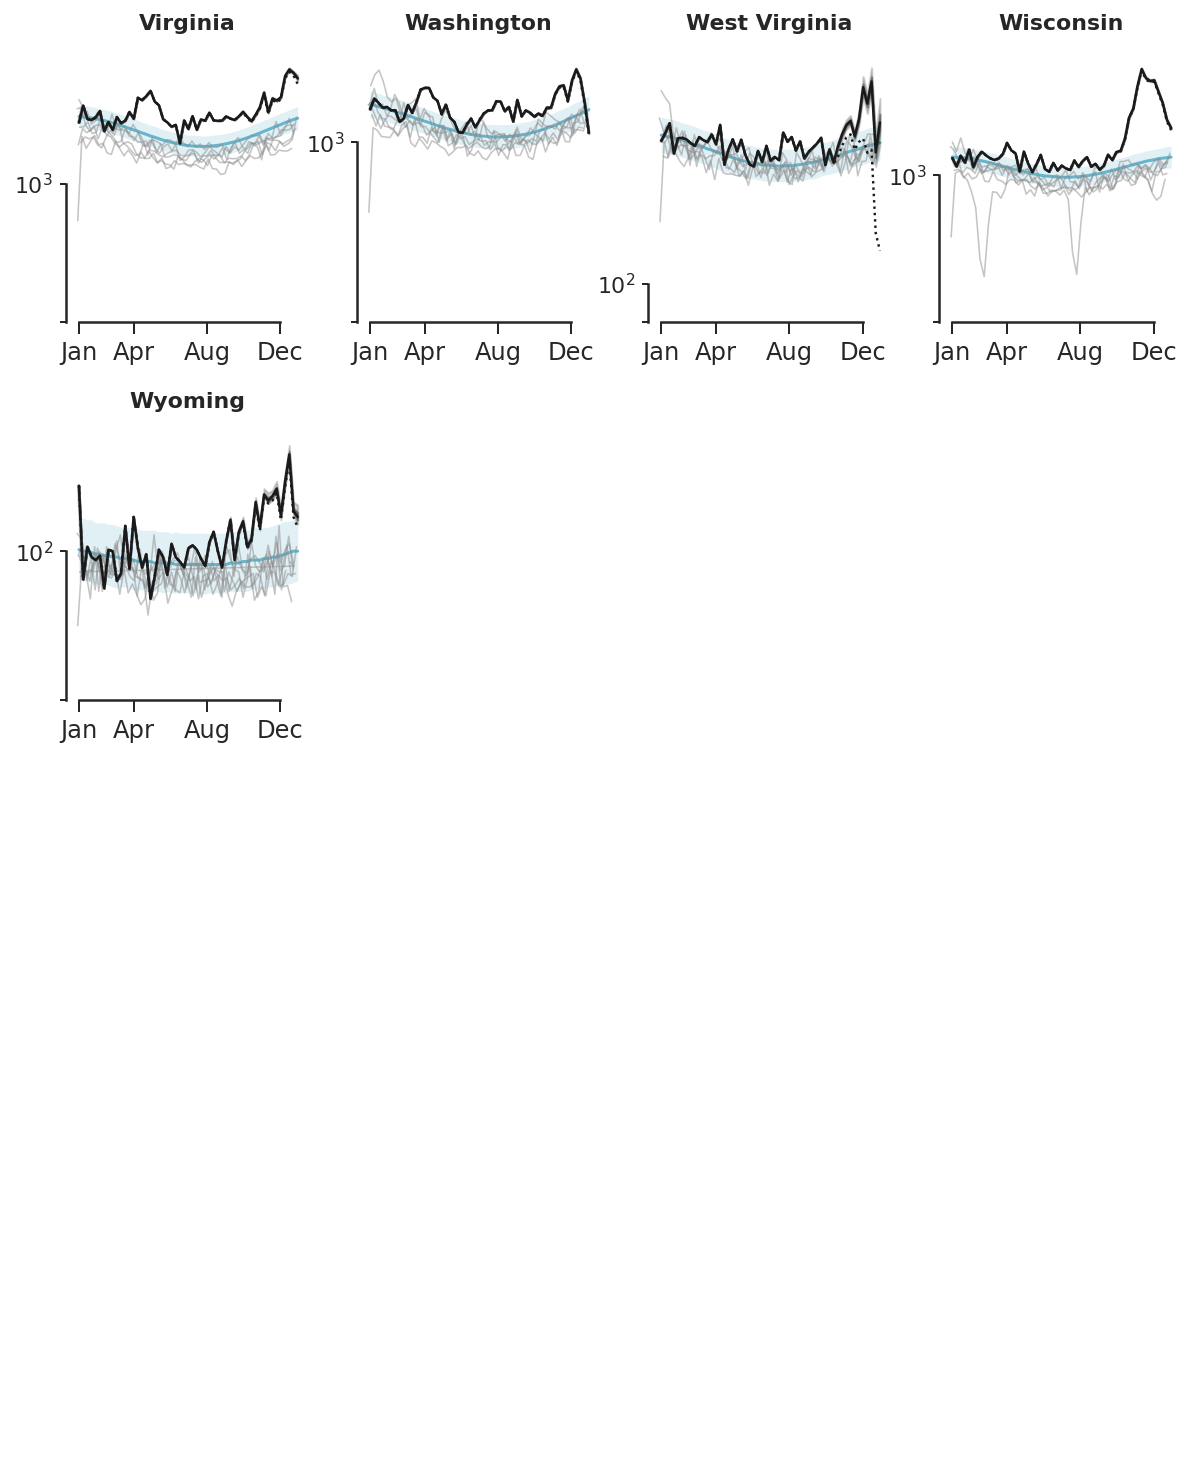

In [111]:
clrs_ = ['C7', 'C9', 'k']
for j in range(4):
    fig, axs = plt.subplots(4, 4)
    fig.subplots_adjust(hspace=.35)
    fig.set_size_inches(10,13)

    for i in range(16):
        ax = axs[i // 4][i % 4]
        
        region = 16*j + i + 1
        
        if (region <= len(df_output_historical.idx_jurisdiction.unique())):
            # baseline deaths counts
            df_output_historical_ = df_output_historical.loc[lambda d: d.idx_jurisdiction == region]
            X = df_output_historical_['x_day']
            ax.fill_between(X, df_output_historical_['q2.5'], df_output_historical_['q97.5'], 
                            color=clrs_[0], alpha=.2, facecolor=clrs_[1], lw=0,
                            zorder=-8.5)
            ax.plot(X, df_output_historical_['median'], c=clrs_[1], linestyle='solid', lw=1.5, zorder=-6.5)
            
            # historical data for raw deaths counts 
            years = list(df_hist.year.unique())
            for year in years:
                df_hist_ = df_hist.loc[lambda d: (d.idx_jurisdiction == region)&(d['year']==year)]
                ax.plot(df_hist_['x_day'].values, list(df_hist_['number_of_deaths'].values), 
                        color='C7', alpha=.5, lw=.8)

            df_ = df_deaths_predicted.loc[lambda d: (d.idx_jurisdiction == region)&(d.lastsnapshot==lastdate)]
            jurisdiction_ = df_.jurisdiction.values[0]
            X = df_['x_day']
            ytks_max_power = int(np.log10(max(df_['deaths'].values)))

            ax.plot(X, df_['deaths'], c=clrs_[-1], linestyle='dotted', lw=1.2)
            ax.fill_between(X, df_['q2.5'], df_['q97.5'], color=clrs_[-1], zorder=1.5, alpha=.2)
            ax.fill_between(X, df_['q25'], df_['q75'], color=clrs_[-1], zorder=2, alpha=.4)
            ax.plot(X, df_['median'], color=clrs_[-1], zorder=3, lw=1.25)
            
            ax.set_ylim([0,max(df_['q97.5'])*1.1])

            #ax.set_xlabel('Week'); ax.set_ylabel('Deaths')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_bounds([0, 10**ytks_max_power])
            ax.spines['bottom'].set_bounds([min(xtks), max(xtks)])
            ytks = [0, 10**ytks_max_power]; ax.set_yticks(ytks); ax.set_yticklabels(["", "$10^%d$"%ytks_max_power])
            ax.tick_params(axis="y", length=3, labelsize=11)
            ax.set_xticks(xtks); ax.set_xticklabels(xtk_labels)
            ax.set_title(jurisdiction_, fontweight='bold', fontsize=11)
        else:
            ax.axis('off')
            
    fig.savefig('../../figures/draft/FigS4-%d.pdf'%(j+1), format="pdf", bbox_inches='tight')    

## <font color="orange">Figure 2</font>

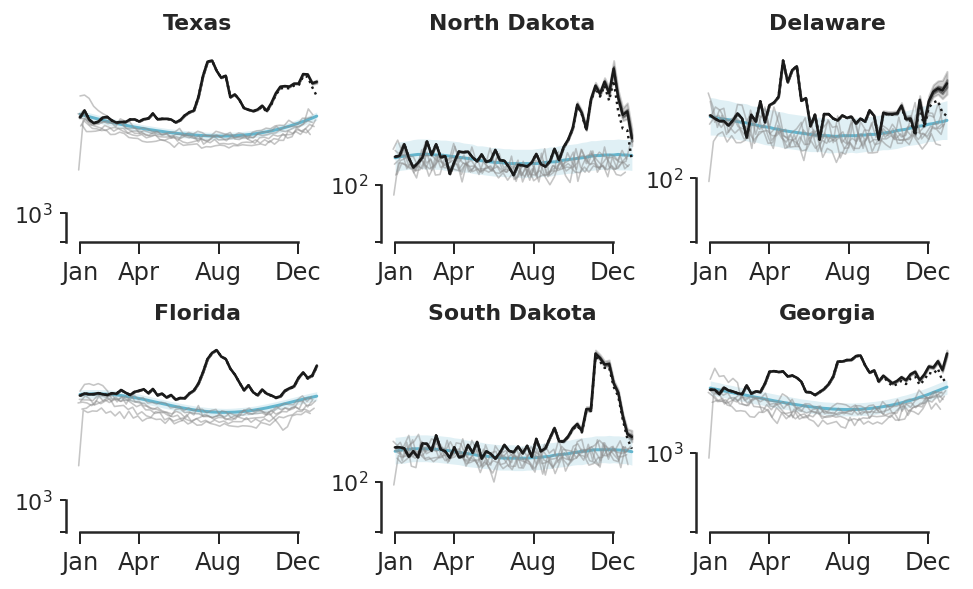

In [112]:
clrs_ = ['C7', 'C9', 'k']
fig, axs = plt.subplots(2,3)
fig.subplots_adjust(hspace=.45)
fig.set_size_inches(8, 4.5)

juristictions_to_plot = np.r_[df_deaths_reported.sort_values('deaths', ascending=False).jurisdiction.tolist()[:2], 
                              df_deaths_reported.sort_values('rate', ascending=False).jurisdiction.tolist()[:2], 
                              ['Delaware', 'Georgia']]

for i, juristiction_ in enumerate(juristictions_to_plot):
    ax = axs[i % 2][i // 2]

    # baseline deaths counts
    df_output_historical_ = df_output_historical.loc[lambda d: d.jurisdiction == juristiction_]
    X = df_output_historical_['x_day']
    ax.fill_between(X, df_output_historical_['q2.5'], df_output_historical_['q97.5'], 
                    color=clrs_[0], alpha=.2, facecolor=clrs_[1], lw=0,
                    zorder=-8.5)
    ax.plot(X, df_output_historical_['median'], c=clrs_[1], linestyle='solid', lw=1.5, zorder=-6.5)

    # historical data for raw deaths counts 
    years = list(df_hist.year.unique())
    for year in years:
        df_hist_ = df_hist.loc[lambda d: (d.jurisdiction == juristiction_)&(d['year']==year)]
        ax.plot(df_hist_['x_day'].values, list(df_hist_['number_of_deaths'].values), 
                color='C7', alpha=.5, lw=.8)

    df_ = df_deaths_predicted.loc[lambda d: (d.jurisdiction == juristiction_)&(d.lastsnapshot==lastdate)]
    jurisdiction_ = df_.jurisdiction.values[0]
    X = df_['x_day']
    ytks_max_power = int(np.log10(max(df_['deaths'].values)))

    ax.plot(X, df_['deaths'], c=clrs_[-1], linestyle='dotted', lw=1.2)
    ax.fill_between(X, df_['q2.5'], df_['q97.5'], color=clrs_[-1], zorder=1.5, alpha=.2)
    ax.fill_between(X, df_['q25'], df_['q75'], color=clrs_[-1], zorder=2, alpha=.4)
    ax.plot(X, df_['median'], color=clrs_[-1], zorder=3, lw=1.25)
    
    ymx = max(df_['q97.5'])
    ax.set_ylim([0,ymx*1.1])

    #ax.set_xlabel('Week'); ax.set_ylabel('Deaths')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_bounds([0, 10**ytks_max_power])
    ax.spines['bottom'].set_bounds([min(xtks), max(xtks)])
    ytks = [0, 10**ytks_max_power]; ax.set_yticks(ytks); ax.set_yticklabels(["", "$10^%d$"%ytks_max_power])
    ax.tick_params(axis="y", length=3, labelsize=11)
    ax.set_xticks(xtks); ax.set_xticklabels(xtk_labels)
    ax.set_title(jurisdiction_, fontweight='bold', fontsize=11)
            
fig.savefig('../../figures/draft/Fig2.pdf', format="pdf", bbox_inches='tight')    

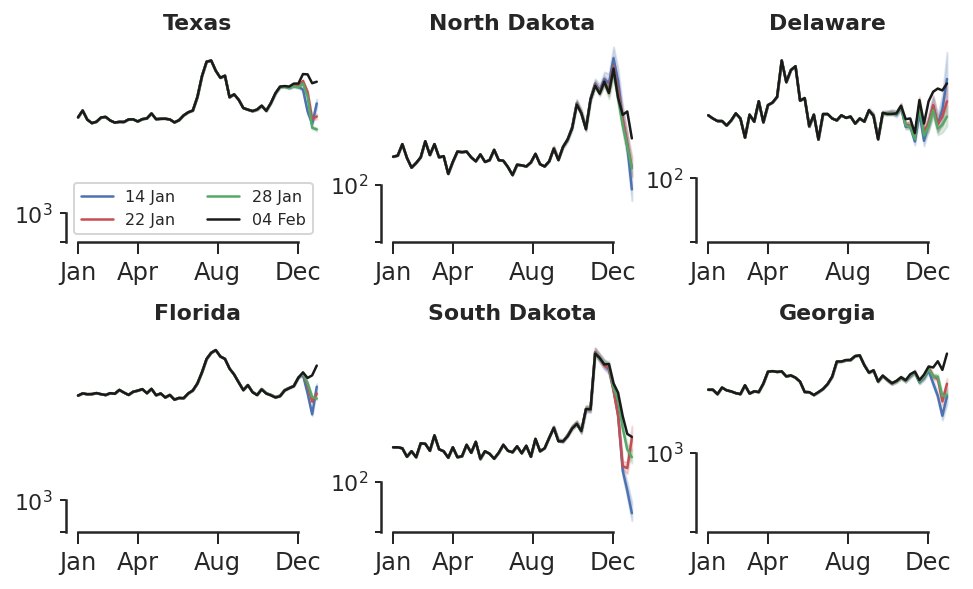

In [113]:
clrs0_ = ['C0', 'C3', 'C2', 'k']
fig, axs = plt.subplots(2,3)
fig.subplots_adjust(hspace=.45)
fig.set_size_inches(8, 4.5)

juristictions_to_plot = np.r_[df_deaths_reported.sort_values('deaths', ascending=False).jurisdiction.tolist()[:2], 
                              df_deaths_reported.sort_values('rate', ascending=False).jurisdiction.tolist()[:2], ['Delaware', 'Georgia']]

for i, juristiction_ in enumerate(juristictions_to_plot):
    ax = axs[i % 2][i // 2]

    for idx_, lastdate_ in enumerate(alldates[:-1]):
        df_ = df_deaths_predicted.loc[lambda d: (d.jurisdiction == juristiction_)&(d.lastsnapshot==alldates[idx_])]
        jurisdiction_ = df_.jurisdiction.values[0]
        X = df_['x_day']
        ytks_max_power = int(np.log10(max(df_['deaths'].values)))
        ax.fill_between(X, df_['q2.5'], df_['q97.5'], color=clrs0_[idx_], zorder=1.5, alpha=.2)
        ax.plot(X, df_['median'], color=clrs0_[idx_], zorder=3, lw=1.25, label=pd.to_datetime(alldates[idx_]).strftime("%d %b"))

    idx_ += 1
    df_ = df_deaths_predicted.loc[lambda d: (d.jurisdiction == juristiction_)&(d.lastsnapshot==alldates[idx_])]
    jurisdiction_ = df_.jurisdiction.values[0]
    X = df_['x_day']
    ytks_max_power = int(np.log10(max(df_['deaths'].values)))

    ax.plot(X, df_['median'], color=clrs0_[-1], zorder=3, lw=1.25, label=pd.to_datetime(alldates[idx_]).strftime("%d %b"))
    
    ymx = max(df_['q97.5'])
    ax.set_ylim([0,ymx*1.1])

    #ax.set_xlabel('Week'); ax.set_ylabel('Deaths')
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_bounds([0, 10**ytks_max_power])
    ax.spines['bottom'].set_bounds([min(xtks), max(xtks)])
    ytks = [0, 10**ytks_max_power]; ax.set_yticks(ytks); ax.set_yticklabels(["", "$10^%d$"%ytks_max_power])
    ax.tick_params(axis="y", length=3, labelsize=11)
    ax.set_xticks(xtks); ax.set_xticklabels(xtk_labels)
    ax.set_title(jurisdiction_, fontweight='bold', fontsize=11)
    
    if (i==0):
        ax.legend(fontsize=8, ncol=2)
            
fig.savefig('../../figures/draft/FigS3.pdf', format="pdf", bbox_inches='tight')    

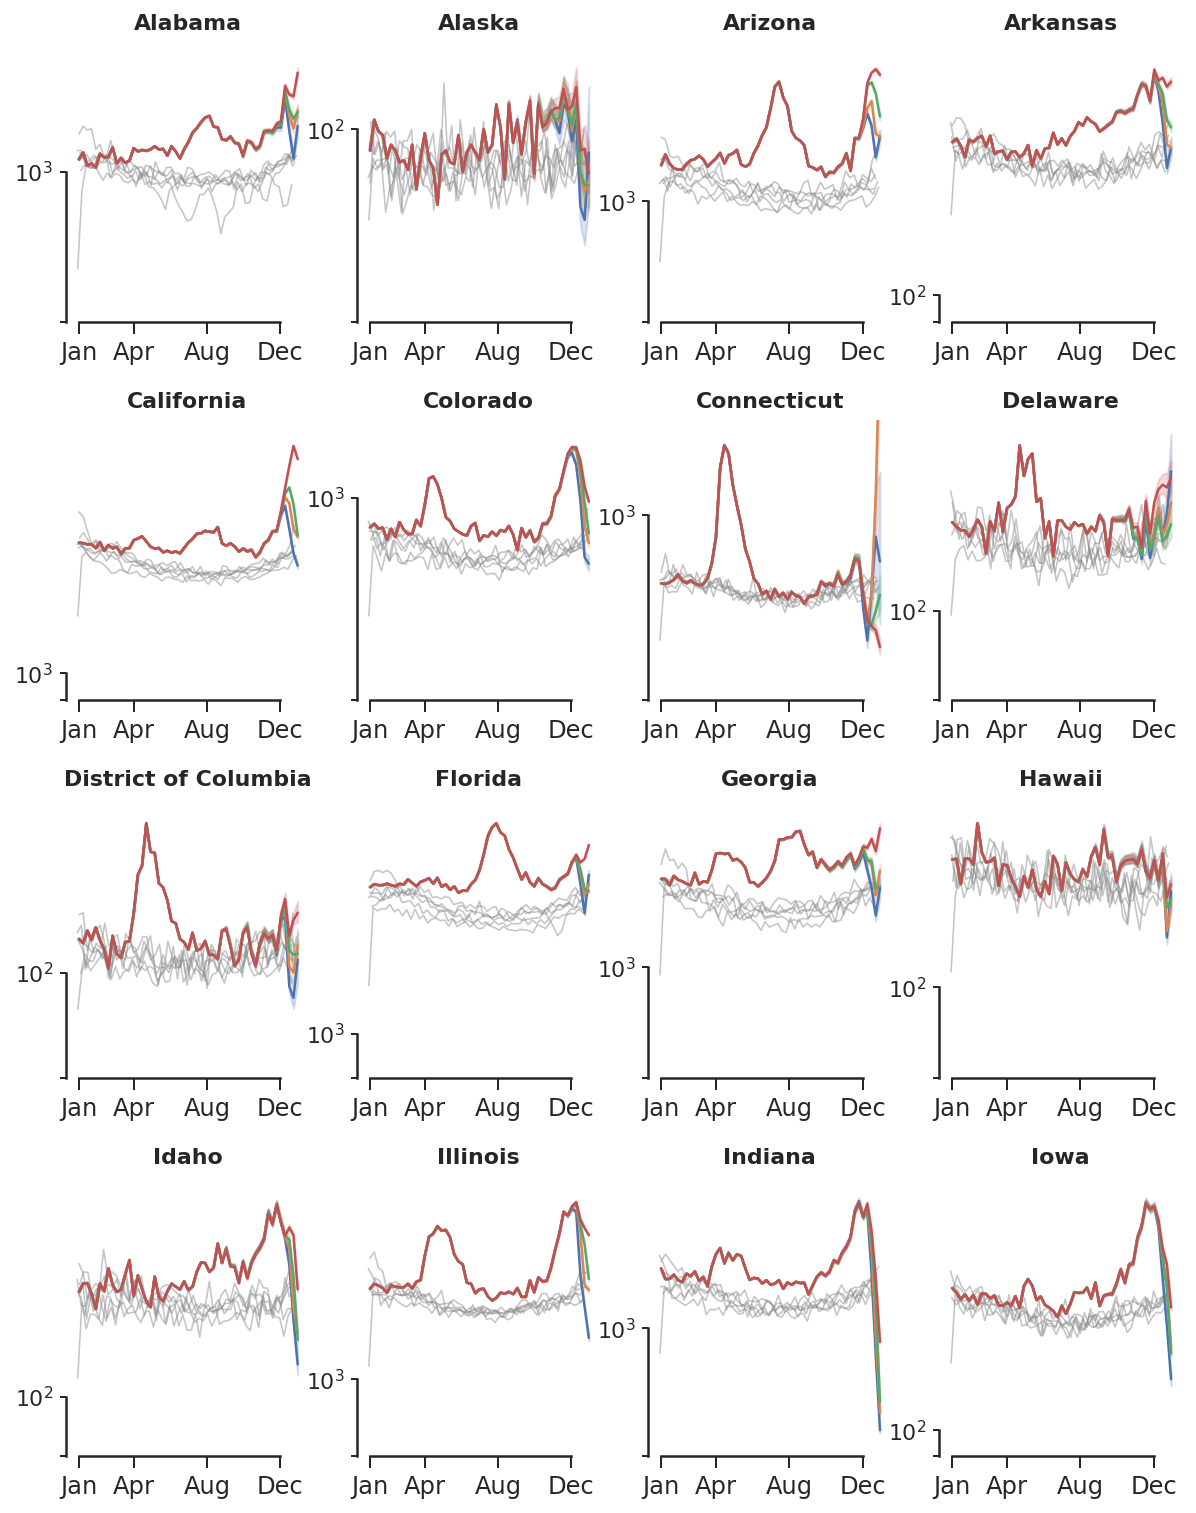

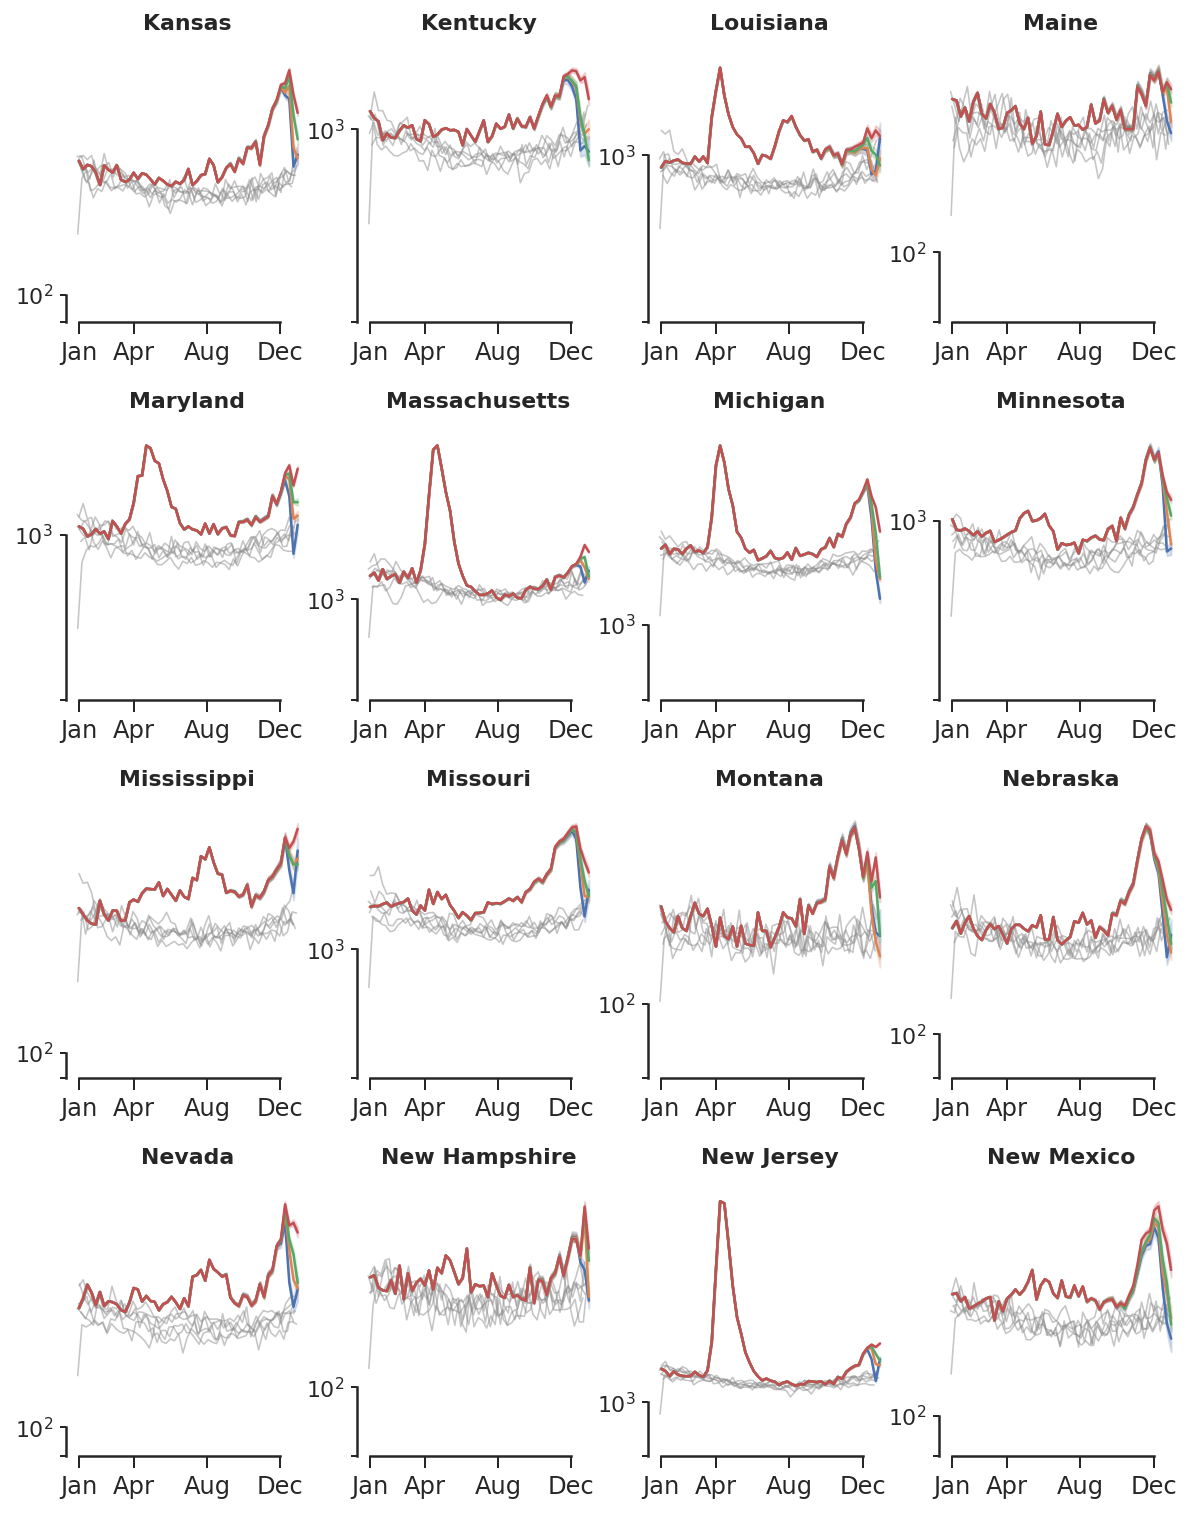

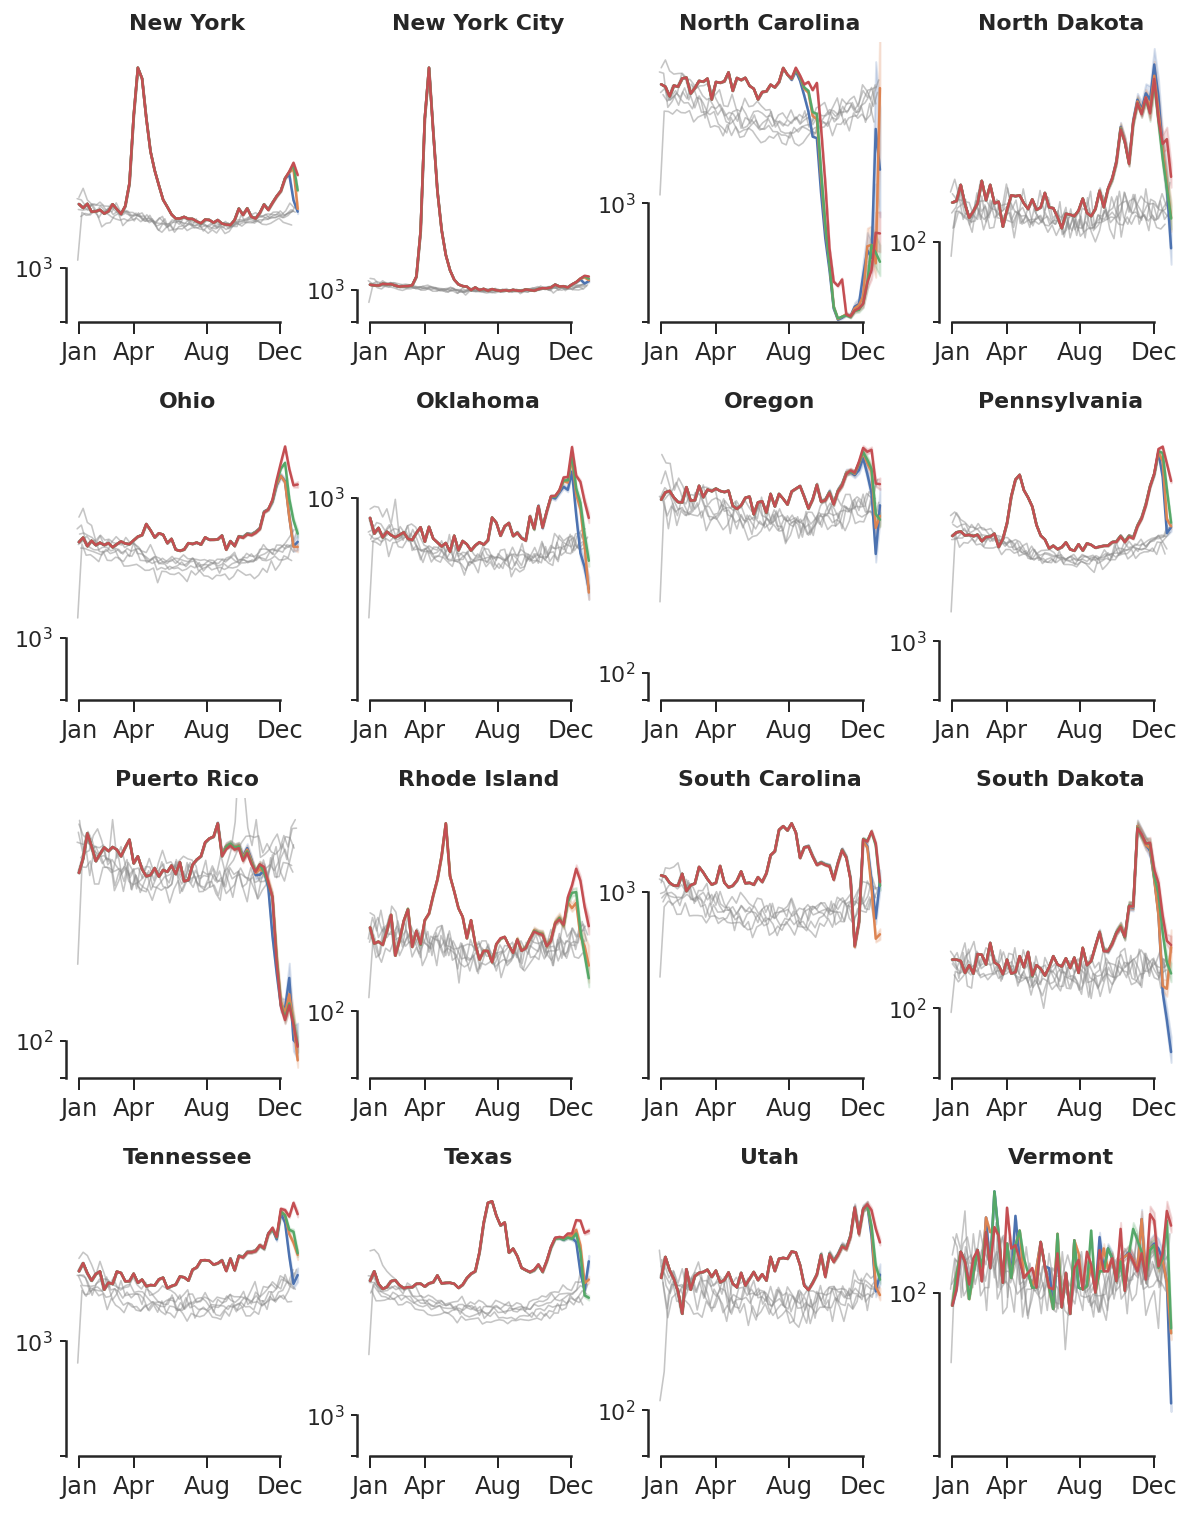

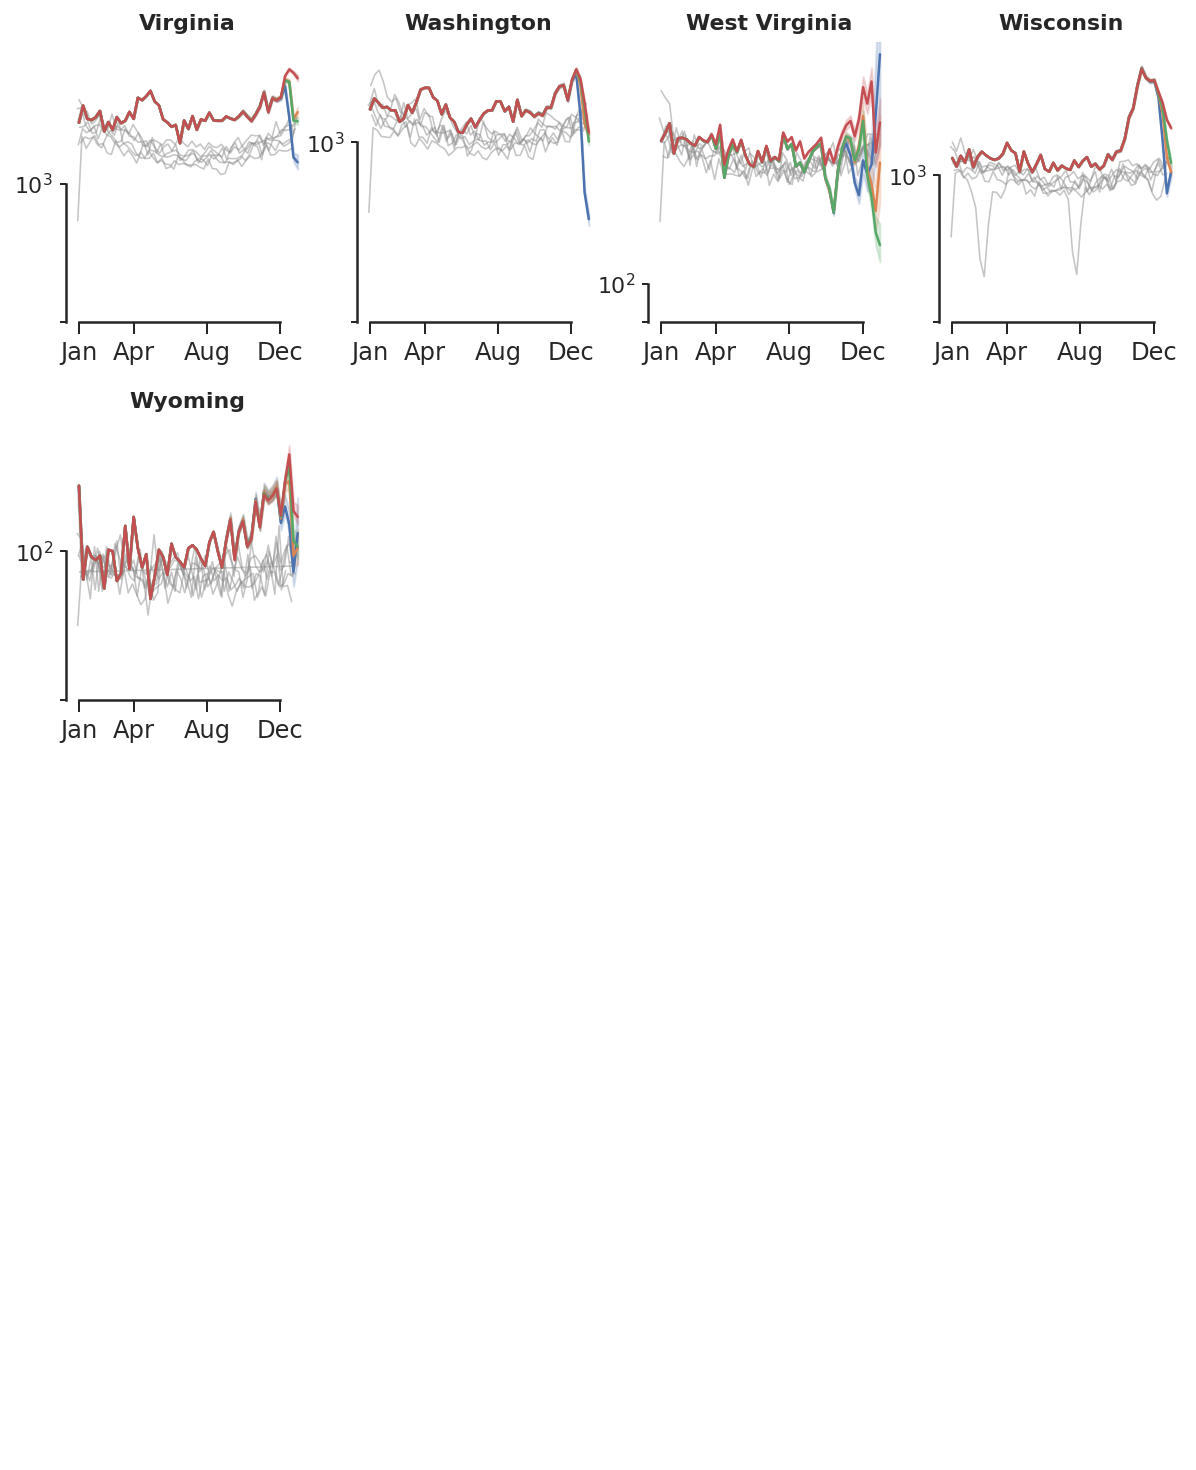

In [114]:
clrs_ = ['C0','C1','C2','C3']
for j in range(4):
    fig, axs = plt.subplots(4, 4)
    fig.subplots_adjust(hspace=.35)
    fig.set_size_inches(10,13)

    for i in range(16):
        ax = axs[i // 4][i % 4]
        
        region = 16*j + i + 1
        
        if (region <= len(df_index_jurisdictions.idx_jurisdiction.unique())):
            # historical data for raw deaths counts 
            years = list(df_hist.year.unique())
            for year in years:
                df_hist_ = df_hist.loc[lambda d: (d.idx_jurisdiction == region)&(d['year']==year)]
                ax.plot(df_hist_['x_day'].values, list(df_hist_['number_of_deaths'].values), 
                        color='C7', alpha=.5, lw=.8)

            for idx_, lastdate_ in enumerate(alldates[:-1]):
                df_ = df_deaths_predicted.loc[lambda d: (d.idx_jurisdiction == region)&(d.lastsnapshot==alldates[idx_])]
                jurisdiction_ = df_.jurisdiction.values[0]
                X = df_['x_day']
                ytks_max_power = int(np.log10(max(df_['deaths'].values)))
                ax.fill_between(X, df_['q2.5'], df_['q97.5'], color=clrs_[idx_], zorder=1.5, alpha=.2)
                ax.plot(X, df_['median'], color=clrs_[idx_], zorder=3, lw=1.25)
                
            idx_ += 1
            df_ = df_deaths_predicted.loc[lambda d: (d.idx_jurisdiction == region)&(d.lastsnapshot==alldates[idx_])]
            jurisdiction_ = df_.jurisdiction.values[0]
            X = df_['x_day']
            ytks_max_power = int(np.log10(max(df_['deaths'].values)))

            ax.fill_between(X, df_['q2.5'], df_['q97.5'], color=clrs_[idx_], zorder=1.5, alpha=.2)
            ax.plot(X, df_['median'], color=clrs_[idx_], zorder=3, lw=1.25)
            
            ax.set_ylim([0,max(df_['q97.5'])*1.1])

            #ax.set_xlabel('Week'); ax.set_ylabel('Deaths')
            ax.spines['right'].set_visible(False)
            ax.spines['top'].set_visible(False)
            ax.spines['left'].set_bounds([0, 10**ytks_max_power])
            ax.spines['bottom'].set_bounds([min(xtks), max(xtks)])
            ytks = [0, 10**ytks_max_power]; ax.set_yticks(ytks); ax.set_yticklabels(["", "$10^%d$"%ytks_max_power])
            ax.tick_params(axis="y", length=3, labelsize=11)
            ax.set_xticks(xtks); ax.set_xticklabels(xtk_labels)
            ax.set_title(jurisdiction_, fontweight='bold', fontsize=11)
        else:
            ax.axis('off')

In [115]:
df_output_historical.loc[lambda d: d['date']>=pd.to_datetime('2020-09-01'), ['jurisdiction', 'week', 'mean']]

jurisdiction  week      mean
35        Alabama    36   924.132
36        Alabama    37   928.735
37        Alabama    38   933.254
38        Alabama    39   938.246
39        Alabama    40   945.433
...           ...   ...       ...
2804    Wisconsin    49  1106.750
2805    Wisconsin    50  1112.783
2806    Wisconsin    51  1117.078
2807    Wisconsin    52  1120.681
2808    Wisconsin    53  1124.127

[954 rows x 3 columns]

## <font color="orange"> Table 1 & Appendix Table 1 </font>

In [116]:
df_nonparametric_output['var'] = df_nonparametric_output['var'].astype('str')

In [167]:
def get_excess_deaths(region, firstweek):
    jurisdiction_ = df_index_jurisdictions.loc[lambda d: d.idx_jurisdiction==region, 'jurisdiction'].values[0]
    stanworkdir = '../../../NTU_Backup/mortality-US_all_states_'+lastdate+'/reporting_delay-nonparametric'
    folder = 'nonparametric_region-%02d'%region

    posterior_glob = !cd "{stanworkdir}/{folder}"; ls trace-*
    cmdstan_data = az.from_cmdstan(posterior = [stanworkdir+"/"+folder+"/"+x for x in posterior_glob]) 

    deaths_pred = np.vstack(cmdstan_data.posterior.deaths_pred)

    df_deaths = pd.read_pickle(stanworkdir+"/"+folder+"/df_deaths_counts.pkl")
    df_index_snapshots = pd.read_pickle(stanworkdir+"/"+folder+"/idx_snapshots.pkl")
    latest_snapshot = df_index_snapshots.loc[lambda d: d.idx_snapshot==max(df_index_snapshots.idx_snapshot)]

    deaths_baseline_median = df_output_historical.loc[lambda d: d.jurisdiction==jurisdiction_].sort_values("date")['median'].values
    deaths_baseline_upper = df_output_historical.loc[lambda d: d.jurisdiction==jurisdiction_].sort_values("date")['q97.5'].values

    excess_deaths_median = deaths_pred - deaths_baseline_median    
    excess_deaths_median[excess_deaths_median<0] = 0
    excess_deaths_median = np.sum(excess_deaths_median[:,(firstweek-1):], axis=-1)
    
    excess_deaths_upper = deaths_pred - deaths_baseline_upper    
    excess_deaths_upper[excess_deaths_upper<0] = 0
    excess_deaths_upper = np.sum(excess_deaths_upper[:,(firstweek-1):], axis=-1)
    
    observed_deaths = np.sum(deaths_pred[:,(firstweek-1):], axis=-1)
    observed_deaths_unadjusted = np.sum(df_deaths.loc[lambda d: d.index.get_level_values('idx_snapshot')==max(df_deaths.index.get_level_values('idx_snapshot'))].values[0][(firstweek-1):])
    
    expected_deaths = np.sum(deaths_baseline_median[(firstweek-1):])
    excess_deaths_percentage_median = excess_deaths_median / expected_deaths * 100
    excess_deaths_percentage_upper = excess_deaths_upper / expected_deaths * 100
    
    observed_deaths_ = np.percentile(observed_deaths, q = [2.5, 50, 97.5], axis=0)
    excess_deaths_median_ = np.percentile(excess_deaths_median, q = [50], axis=0)
    excess_deaths_upper_ = np.percentile(excess_deaths_upper, q = [50], axis=0)
    excess_deaths_percentage_median_ = np.percentile(excess_deaths_percentage_median, q = [50], axis=0)
    excess_deaths_percentage_upper_ = np.percentile(excess_deaths_percentage_upper, q = [50], axis=0)
    
    excess_deaths_predicted = np.transpose(np.r_[observed_deaths_, 
                                                 observed_deaths_unadjusted,
                                                 expected_deaths, 
                                                 excess_deaths_median_, 
                                                 excess_deaths_upper_, 
                                                 excess_deaths_percentage_median_, 
                                                 excess_deaths_percentage_upper_][:,None])
    
    ## output
    df_excess_deaths_predicted = pd.DataFrame(excess_deaths_predicted)
    df_excess_deaths_predicted.columns = ['observed_deaths_lower', 'observed_deaths', 'observed_deaths_upper', 
                                          'observed_deaths_unadjusted', 'expected_deaths', 
                                          'excess_deaths_median', 'excess_deaths_upper', 
                                          'excess_deaths_rel_median', 'excess_deaths_rel_upper']
    df_excess_deaths_predicted['idx_jurisdiction'] = region
    df_excess_deaths_predicted['jurisdiction'] = jurisdiction_
    df_excess_deaths_predicted['lastsnapshot'] = lastdate
    return df_excess_deaths_predicted

In [168]:
get_excess_deaths(33, 30)

observed_deaths_lower  observed_deaths  observed_deaths_upper  \
0                50498.0          50567.0                50655.0   

   observed_deaths_unadjusted  expected_deaths  excess_deaths_median  \
0                     50403.0          45017.0                5583.0   

   excess_deaths_upper  excess_deaths_rel_median  excess_deaths_rel_upper  \
0             3856.975                 12.401981                 8.567819   

   idx_jurisdiction jurisdiction lastsnapshot  
0                33     New York     20210204

In [169]:
%%time
# from the beginning of March [week 10] till the end of the year
df_excess_deaths = None
clrs_ = ['red', 'blue', 'green', 'yellow']
idx_ = 0
for region in df_index_jurisdictions.idx_jurisdiction.unique():
    print(colored(df_index_jurisdictions.loc[lambda d: d.idx_jurisdiction==region, 'jurisdiction'].values[0], clrs_[idx_%4]))
    df_excess_deaths_ = get_excess_deaths(region, 10)
    df_excess_deaths = df_excess_deaths_ if df_excess_deaths is None else df_excess_deaths.append(df_excess_deaths_)
    idx_ += 1
df_excess_deaths[:5]

Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
New York City
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Puerto Rico
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming
CPU times: user 8.95 s, sys: 542 ms, total: 9.49 s
Wall time: 9.81 s


observed_deaths_lower  observed_deaths  observed_deaths_upper  \
0                53985.0          54066.0                54153.0   
0                 4121.0           4148.5                 4180.0   
0                65954.0          66003.0                66069.0   
0                32161.0          32208.0                32265.0   
0               270093.0         270183.0               270316.0   

   observed_deaths_unadjusted  expected_deaths  excess_deaths_median  \
0                     53626.0          42919.0               11147.0   
0                      4033.0           4021.0                 316.0   
0                     65887.0          51564.5               14438.5   
0                     32086.0          26819.0                5450.0   
0                    269998.0         224603.0               45580.0   

   excess_deaths_upper  excess_deaths_rel_median  excess_deaths_rel_upper  \
0             8379.900                 25.972180                19.524919   
0               14.000                  7.858742                 0.348172   
0            11316.950                 28.000853                21.947173   
0             3617.975                 20.321414                13.490343   
0            39126.875                 20.293585                17.420460   

   idx_jurisdiction jurisdiction lastsnapshot  
0                 1      Alabama     20210204  
0                 2       Alaska     20210204  
0                 3      Arizona     20210204  
0                 4     Arkansas     20210204  
0                 5   California     20210204

In [184]:
%%R -i df_nonparametric_output -i df_excess_deaths
options(warn=-1)
library(dplyr); library(glue); library(magrittr); library(kableExtra); library(IRdisplay)
df_nonparametric_output %<>%
    rename(Jurisdiction = jurisdiction) %>%
    filter(var=='mean_delay') %>%
    mutate(`Mean delay, weeks`=glue('{sprintf("%.1f", mean)} ({sprintf("%.1f", q2.5)}, {sprintf("%.1f", q97.5)})')) 

df_excess_deaths %<>% 
    rename(Jurisdiction = jurisdiction) %>%
    mutate(excess_deaths_median = as.integer(excess_deaths_median),
           excess_deaths_upper = as.integer(excess_deaths_upper),
           expected_deaths = as.integer(expected_deaths),
           observed_deaths_lower = as.integer(observed_deaths_lower),
           observed_deaths_upper = as.integer(observed_deaths_upper),
           observed_deaths = as.integer(observed_deaths),
           observed_deaths_unadjusted = as.integer(observed_deaths_unadjusted),
           `Observed deaths`=glue('{sprintf("%d", observed_deaths)} ({sprintf("%d", observed_deaths_lower)}, {sprintf("%d", observed_deaths_upper)})'),
           `Observed deaths\nunadjusted`=glue('{sprintf("%d", observed_deaths_unadjusted)}'),
           `Expected deaths`=glue('{sprintf("%d", expected_deaths)}'),
           `Excess deaths`=glue('{sprintf("%d", excess_deaths_upper)}-{sprintf("%d", excess_deaths_median)}'),
           `Excess deaths, %`=glue('{sprintf("%.1f", excess_deaths_rel_upper)}-{sprintf("%.1f", excess_deaths_rel_median)}')) %>%
    left_join(df_nonparametric_output)

df_excess_deaths %<>% 
    select(Jurisdiction, `Observed deaths`, `Expected deaths`, `Excess deaths`, `Excess deaths, %`, `Observed deaths\nunadjusted`, excess_deaths_rel_upper) 

df_excess_deaths %>%
    select(-excess_deaths_rel_upper) %>%
    kable("html", escape = F) %>%
    kable_styling("hover", full_width = F) %>%
    as.character() %>%
    cat(., file = "table1.html")

df_excess_deaths %>%
    arrange(excess_deaths_rel_upper) %>%
    head(5) %>%
    select(-excess_deaths_rel_upper) %>%
    kable("html", escape = F) %>%
    kable_styling("hover", full_width = F) %>%
    as.character() %>%
    cat(., file = "table1_head.html")

df_excess_deaths %>%
    arrange(excess_deaths_rel_upper) %>%
    tail(5) %>%
    select(-excess_deaths_rel_upper) %>%
    kable("html", escape = F) %>%
    kable_styling("hover", full_width = F) %>%
    as.character() %>%
    cat(., file = "table1_tail.html")

options(warn=0)

Joining, by = c("idx_jurisdiction", "Jurisdiction")


In [1]:
from IPython.display import IFrame

IFrame(src='./table1.html', width=700, height=500)

In [4]:
IFrame(src='./table1_head.html', width=700, height=280)

In [5]:
IFrame(src='./table1_tail.html', width=700, height=280)

In [188]:
%%time
# from the beginning of September [week 36] till the end of the year
df_excess_deaths = None
clrs_ = ['red', 'blue', 'green', 'yellow']
idx_ = 0
for region in df_index_jurisdictions.idx_jurisdiction.unique():
    print(colored(df_index_jurisdictions.loc[lambda d: d.idx_jurisdiction==region, 'jurisdiction'].values[0], clrs_[idx_%4]))
    df_excess_deaths_ = get_excess_deaths(region, 36)
    df_excess_deaths = df_excess_deaths_ if df_excess_deaths is None else df_excess_deaths.append(df_excess_deaths_)
    idx_ += 1
df_excess_deaths[:5]

Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
District of Columbia
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
New York City
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Puerto Rico
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming
CPU times: user 8.83 s, sys: 510 ms, total: 9.34 s
Wall time: 9.66 s


observed_deaths_lower  observed_deaths  observed_deaths_upper  \
0                23261.0          23342.0                23429.0   
0                 1831.0           1858.5                 1890.0   
0                26938.0          26987.0                27053.0   
0                14785.0          14832.0                14889.0   
0               117297.0         117387.0               117520.0   

   observed_deaths_unadjusted  expected_deaths  excess_deaths_median  \
0                     22902.0          17838.0                5504.0   
0                      1743.0           1688.0                 226.0   
0                     26871.0          21132.0                5855.0   
0                     14710.0          11234.0                3598.0   
0                    117202.0          93433.0               23954.0   

   excess_deaths_upper  excess_deaths_rel_median  excess_deaths_rel_upper  \
0             4296.950                 30.855477                24.088743   
0               12.000                 13.388626                 0.710900   
0             4551.975                 27.706795                21.540673   
0             2643.000                 32.027773                23.526794   
0            21232.950                 25.637623                22.725322   

   idx_jurisdiction jurisdiction lastsnapshot  
0                 1      Alabama     20210204  
0                 2       Alaska     20210204  
0                 3      Arizona     20210204  
0                 4     Arkansas     20210204  
0                 5   California     20210204

In [189]:
%%R -i df_excess_deaths
options(warn=-1)
library(dplyr); library(glue); library(magrittr); library(kableExtra); library(IRdisplay)

df_excess_deaths %<>% 
    rename(Jurisdiction = jurisdiction) %>%
    mutate(excess_deaths_median = as.integer(excess_deaths_median),
           excess_deaths_upper = as.integer(excess_deaths_upper),
           expected_deaths = as.integer(expected_deaths),
           observed_deaths_lower = as.integer(observed_deaths_lower),
           observed_deaths_upper = as.integer(observed_deaths_upper),
           observed_deaths = as.integer(observed_deaths),
           observed_deaths_unadjusted = as.integer(observed_deaths_unadjusted),
           `Observed deaths`=glue('{sprintf("%d", observed_deaths)} ({sprintf("%d", observed_deaths_lower)}, {sprintf("%d", observed_deaths_upper)})'),
           `Observed deaths\nunadjusted`=glue('{sprintf("%d", observed_deaths_unadjusted)}'),
           `Expected deaths`=glue('{sprintf("%d", expected_deaths)}'),
           `Excess deaths`=glue('{sprintf("%d", excess_deaths_upper)}-{sprintf("%d", excess_deaths_median)}'),
           `Excess deaths, %`=glue('{sprintf("%.1f", excess_deaths_rel_upper)}-{sprintf("%.1f", excess_deaths_rel_median)}')) %>%
    left_join(df_nonparametric_output)

df_excess_deaths %<>% 
    select(Jurisdiction, `Observed deaths`, `Expected deaths`, `Excess deaths`, `Excess deaths, %`, `Observed deaths\nunadjusted`, excess_deaths_rel_upper) 

df_excess_deaths %>%
    select(-excess_deaths_rel_upper) %>%
    kable("html", escape = F) %>%
    kable_styling("hover", full_width = F) %>%
    as.character() %>%
    cat(., file = "appendix_table1_Sep_to_Dec.html")

df_excess_deaths %>%
    arrange(excess_deaths_rel_upper) %>%
    head(5) %>%
    select(-excess_deaths_rel_upper) %>%
    kable("html", escape = F) %>%
    kable_styling("hover", full_width = F) %>%
    as.character() %>%
    cat(., file = "appendix_table1_head_Sep_to_Dec.html")

df_excess_deaths %>%
    arrange(excess_deaths_rel_upper) %>%
    tail(5) %>%
    select(-excess_deaths_rel_upper) %>%
    kable("html", escape = F) %>%
    kable_styling("hover", full_width = F) %>%
    as.character() %>%
    cat(., file = "appendix_table1_tail_Sep_to_Dec.html")

options(warn=0)

Joining, by = c("idx_jurisdiction", "Jurisdiction")


/home/aakhmetz/anaconda/lib/python3.8/site-packages/rpy2/robjects/pandas2ri.py:60: UserWarning: Error while trying to convert the column "jurisdiction". Fall back to string conversion. The error is: <class 'numpy.str_'>
  warnings.warn('Error while trying to convert '


In [190]:
from IPython.display import IFrame

IFrame(src='./appendix_table1_Sep_to_Dec.html', width=700, height=500)

In [194]:
IFrame(src='./appendix_table1_head_Sep_to_Dec.html', width=700, height=280)

In [193]:
IFrame(src='./appendix_table1_tail_Sep_to_Dec.html', width=700, height=280)